In [1]:
import tensorflow as tf
import numpy as np
import scipy.io as cpio
import os
import time

# Define the folder that contains all data files
# Each data file contains the variables:
#    s: The spectrogram [size = 513 x time_steps]
#    f: Frequencies [size = 513]
#    t: Time steps
#    labels: The tagging data [size = time_steps]

#data_directory = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_data'
#data_directory = '/Users/yardenc/Documents/Experiments/BengaleseFinchSongs/gr41rd51/mat'
data_directory ='/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat'
# data_directory = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_annotated'
#data_directory = '/Users/yardenc/Documents/Experiments/Imaging/Data/CanaryData/lrb853_15/movs/wav/mat'
# This folder must also contain a matlab file 'file_list.mat' with cell array 'keys' that holds the data file names

data_list = cpio.loadmat(data_directory + '/file_list.mat')
number_of_files = len(data_list['keys'][0])
print "There are ", number_of_files, " entries for training." 
# The folder for saving training checkpoints
#training_records_dir = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_records'
#training_records_dir = '/Users/yardenc/Documents/Experiments/BengaleseFinchSongs/gr41rd51/training_records'
training_records_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records'
#test_data_directory = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_data/test'
#test_data_directory = '/Users/yardenc/Documents/Experiments/BengaleseFinchSongs/gr41rd51/mat'
test_data_directory ='/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat/test_data'
#results_dir = '/Users/yardenc/Documents/Experiments/BengaleseFinchSongs/gr41rd51'
#results_dir = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_data/test'
results_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat/test_data'
results_file = 'Results_Oct_06_2017'

There are  100  entries for training.


In [2]:
# Parameters
input_vec_size = 513 #= lstm_size
batch_size = 11
n_lstm_layers = 2
n_syllables = 27#25 #28 #25 #44 #including zero
learning_rate = 0.001
n_max_iter = 50001
time_steps = 370 #370
window_time_steps = 11

In [3]:
def label_inference_graph(spectrogram, num_hidden, num_layers, seq_length):
    #First convolutional layers
     # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=tf.reshape(spectrogram,[batch_size,-1,input_vec_size,1]), #time_steps
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[1, 8], strides=[1,8])
    # Convolutional Layer #2 and Pooling Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=64,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[1, 8], strides=[1,8])
    # Second the dynamic bi-directional, multi-layered LSTM
    with tf.name_scope('biRNN'):
        with tf.variable_scope('fwd'):
            lstm_f1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_f2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_f3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_f = tf.contrib.rnn.MultiRNNCell([lstm_f1,lstm_f2], state_is_tuple=True)
        with tf.variable_scope('bck'):
            lstm_b1 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            lstm_b2 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            #lstm_b3 = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0, state_is_tuple=True,reuse=None)
            cells_b = tf.contrib.rnn.MultiRNNCell([lstm_b1,lstm_b2], state_is_tuple=True)
        outputs, _states = tf.nn.bidirectional_dynamic_rnn(lstm_f1,lstm_b1, tf.reshape(pool2,[batch_size,-1,512]), time_major=False, dtype=tf.float32,sequence_length=seq_length)
    # Third, projection on the number of syllables creates logits    time_steps
    with tf.name_scope('Projection'):
        W_f = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        W_b = tf.Variable(tf.random_normal([num_hidden, n_syllables]))
        bias = tf.Variable(tf.random_normal([n_syllables]))
    expr1 = tf.unstack(outputs[0],axis=0,num=batch_size)
    expr2 = tf.unstack(outputs[1],axis=0,num=batch_size)
    #logits = [tf.matmul(outputs[0][:,a,:],W_f) + bias + tf.matmul(outputs[1][:,a,:],W_b) for a in range(seq_length[0])]
    logits = tf.concat([tf.matmul(ex1,W_f) + bias + tf.matmul(ex2,W_b) for ex1,ex2 in zip(expr1,expr2)],0)
    return logits,outputs

In [4]:
# The training graph. Calculate cross entropy and loss function
def training_graph(logits, lbls, rate, lng):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits,labels = tf.concat(tf.unstack(lbls,axis=0,num=batch_size),0), name='xentropy')
    cost = tf.reduce_mean(xentropy, name='cost')
    optimizer = tf.train.AdamOptimizer(learning_rate = rate)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op, cost

In [5]:
# Construct the full graph and add saver
full_graph = tf.Graph()
with full_graph.as_default():
        # Generate placeholders for the spectrograms and labels.
        X = tf.placeholder("float", [None,None,input_vec_size], name = "Xdata") # holds spectrograms batch_size,time_steps
        Y = tf.placeholder("int32",[None,None],name = "Ylabels") # holds labels batch_size
        lng = tf.placeholder("int32",name = "nSteps") # holds the sequence length
        tf.add_to_collection("specs", X)  # Remember this Op.
        tf.add_to_collection("labels", Y)  # Remember this Op.
        tf.add_to_collection("lng", lng)  # Remember this Op.
        # Build a Graph that computes predictions from the inference model.
        logits,outputs = label_inference_graph(X, 512, n_lstm_layers, lng) #lstm_size
        tf.add_to_collection("logits", logits)  # Remember this Op.

        # Add to the Graph the Ops that calculate and apply gradients.
        train_op, cost = training_graph(logits, Y, learning_rate, lng)

        # Add the variable initializer Op.
        init = tf.global_variables_initializer() #initialize_all_variables()

        # Create a saver for writing training checkpoints.
        saver = tf.train.Saver(max_to_keep = 10)

In [6]:
# Prepare training dataset. All training data is loaded to memory
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
    
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

Original dataset shape: (298299, 513)
Training dataset shape: (11, 27118, 513), #iterations: 26748


In [7]:
# Train and save checkpoint at the end of each file.
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables.
    sess.run(init)
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint')
    saver.save(sess, checkpoint_file, global_step=step)
        

[1, 10486, 3.9670038]
[2, 25959, 5.5986452]
[3, 8804, 4.0419698]
[4, 20350, 2.5885582]
[5, 25162, 3.2479146]
[6, 22627, 2.6848567]
[7, 23138, 2.85322]
[8, 2301, 2.8291736]
[9, 20750, 2.6188772]
[10, 17111, 2.5738127]
[11, 23942, 2.4719179]
[12, 17747, 2.3750141]
[13, 25173, 2.4683771]
[14, 2267, 2.3884447]
[15, 1784, 2.073374]
[16, 15138, 1.9988369]
[17, 3421, 1.9633224]
[18, 11085, 1.7237513]
[19, 19412, 2.1779943]
[20, 22247, 1.5849369]
[21, 24545, 1.648298]
[22, 8828, 1.5965294]
[23, 6996, 1.8453159]
[24, 7674, 1.7326943]
[25, 13847, 1.5381845]
[26, 23722, 1.4069816]
[27, 20197, 1.7092466]
[28, 4942, 1.5725671]
[29, 25495, 1.8158467]
[30, 18396, 1.3319383]
[31, 11286, 2.5291097]
[32, 16481, 1.6029404]
[33, 9837, 1.52406]
[34, 3665, 1.7370319]
[35, 21926, 0.87325484]
[36, 23726, 1.2017486]
[37, 1196, 1.4254652]
[38, 10706, 1.256933]
[39, 17361, 0.95177829]
[40, 21576, 0.65730453]
[41, 182, 0.65089321]
[42, 14702, 0.70066059]
[43, 22193, 0.6360814]
[44, 3757, 1.4520438]
[45, 19710, 1.

[341, 19143, 0.18819034]
[342, 19788, 0.15631504]
[343, 11958, 0.11312784]
[344, 17453, 0.11511891]
[345, 4097, 0.12233101]
[346, 25542, 0.22692664]
[347, 3420, 0.12675561]
[348, 10118, 0.1301353]
[349, 25885, 0.17116421]
[350, 26435, 0.097048178]
[351, 19654, 0.13735092]
[352, 14651, 0.088470221]
[353, 702, 0.13754863]
[354, 12484, 0.20193546]
[355, 11210, 0.14429338]
[356, 23162, 0.14220335]
[357, 3759, 0.12717968]
[358, 22207, 0.10643083]
[359, 15293, 0.1059457]
[360, 18667, 0.10790217]
[361, 8428, 0.15405954]
[362, 23678, 0.14339754]
[363, 13664, 0.10494699]
[364, 8282, 0.099696092]
[365, 19668, 0.097988881]
[366, 25200, 0.12353524]
[367, 17053, 0.13282132]
[368, 24444, 0.12354907]
[369, 18566, 0.13391621]
[370, 5432, 0.16298172]
[371, 15366, 0.14592256]
[372, 1490, 0.33483371]
[373, 11441, 0.086219251]
[374, 9080, 0.1163667]
[375, 3893, 0.15641354]
[376, 6505, 0.27399439]
[377, 4150, 0.1287308]
[378, 7887, 0.12672034]
[379, 6510, 0.21618377]
[380, 25223, 0.20957379]
[381, 2103, 0.

[671, 21210, 0.088116303]
[672, 9504, 0.093258023]
[673, 24294, 0.11012344]
[674, 2744, 0.25147057]
[675, 4359, 0.10727846]
[676, 1489, 0.20257194]
[677, 22401, 0.12508386]
[678, 1506, 0.19115129]
[679, 11970, 0.084274046]
[680, 26030, 0.19801974]
[681, 22341, 0.084307939]
[682, 12477, 0.2726067]
[683, 16811, 0.13310511]
[684, 4694, 0.11403295]
[685, 18643, 0.10877503]
[686, 25926, 0.13432109]
[687, 4233, 0.10809412]
[688, 7425, 0.23490326]
[689, 7510, 0.17110397]
[690, 16204, 0.1720679]
[691, 9669, 0.07840012]
[692, 21131, 0.097452]
[693, 11923, 0.08305192]
[694, 4833, 0.093381248]
[695, 20804, 0.11631392]
[696, 1660, 0.18512939]
[697, 14787, 0.095637053]
[698, 12850, 0.12920217]
[699, 25013, 0.074595124]
0.116737
[700, 12873, 0.12241073]
[701, 5631, 0.28855166]
[702, 5544, 0.20198931]
[703, 3085, 0.076466568]
[704, 9129, 0.13063779]
[705, 19679, 0.13247491]
[706, 14004, 0.12331209]
[707, 8209, 0.098077245]
[708, 24986, 0.074341431]
[709, 25609, 0.11594795]
[710, 10196, 0.086971529]
[

[1000, 10726, 0.12690681]
[1001, 20522, 0.15093963]
[1002, 16153, 0.15149879]
[1003, 8644, 0.099741094]
[1004, 21049, 0.1557226]
[1005, 1440, 0.40924552]
[1006, 24834, 0.080458924]
[1007, 6615, 0.13488334]
[1008, 12807, 0.19489764]
[1009, 3356, 0.25809851]
[1010, 22658, 0.25982735]
[1011, 1287, 0.14878531]
[1012, 5156, 0.11583927]
[1013, 12612, 0.1215808]
[1014, 23734, 0.1349256]
[1015, 24614, 0.10162241]
[1016, 12146, 0.13806744]
[1017, 5213, 0.10989979]
[1018, 24137, 0.15154417]
[1019, 2323, 0.26488113]
[1020, 1374, 0.1600223]
[1021, 18376, 0.071015865]
[1022, 15219, 0.12222373]
[1023, 7915, 0.1401538]
[1024, 7627, 0.12841378]
[1025, 20222, 0.15487766]
[1026, 25979, 0.14022562]
[1027, 14498, 0.091940328]
[1028, 18091, 0.10068592]
[1029, 10665, 0.11294673]
[1030, 20861, 0.13286929]
[1031, 12430, 0.143194]
[1032, 19359, 0.1116497]
[1033, 1701, 0.13071702]
[1034, 3079, 0.074785784]
[1035, 19327, 0.10613286]
[1036, 19971, 0.11685173]
[1037, 1607, 0.17724307]
[1038, 16823, 0.11565721]
[10

[1315, 19979, 0.093475014]
[1316, 13648, 0.071791336]
[1317, 16034, 0.11487781]
[1318, 2273, 0.16814281]
[1319, 5764, 0.11699205]
[1320, 18125, 0.065744877]
[1321, 1828, 0.090169892]
[1322, 7750, 0.071601056]
[1323, 4079, 0.10961826]
[1324, 25663, 0.098104052]
[1325, 22111, 0.045220766]
[1326, 18073, 0.096132092]
[1327, 1975, 0.11370663]
[1328, 8543, 0.08186543]
[1329, 15339, 0.07836879]
[1330, 23793, 0.10040741]
[1331, 337, 0.063865483]
[1332, 22308, 0.058363814]
[1333, 26174, 0.10477707]
[1334, 9616, 0.076948874]
[1335, 17852, 0.089956097]
[1336, 13872, 0.072530143]
[1337, 81, 0.040377475]
[1338, 11381, 0.06143583]
[1339, 4800, 0.076693997]
[1340, 7154, 0.16361929]
[1341, 3521, 0.083526254]
[1342, 21077, 0.098463096]
[1343, 14384, 0.069823921]
[1344, 13147, 0.098112248]
[1345, 22329, 0.098414019]
[1346, 21339, 0.046724021]
[1347, 15059, 0.08894141]
[1348, 21299, 0.054268114]
[1349, 26212, 0.10378117]
[1350, 2696, 0.12117805]
[1351, 13298, 0.12053667]
[1352, 24141, 0.06390056]
[1353, 

[1626, 24507, 0.065534592]
[1627, 2743, 0.09763176]
[1628, 16154, 0.12558001]
[1629, 4163, 0.083691008]
[1630, 7029, 0.1047975]
[1631, 1409, 0.11805797]
[1632, 21205, 0.075886376]
[1633, 19318, 0.1019347]
[1634, 19201, 0.12422499]
[1635, 2379, 0.10762749]
[1636, 8910, 0.078806542]
[1637, 1496, 0.12722485]
[1638, 7219, 0.11827502]
[1639, 16902, 0.10436913]
[1640, 19051, 0.093786903]
[1641, 23347, 0.074112073]
[1642, 20897, 0.086568862]
[1643, 22532, 0.21306928]
[1644, 4546, 0.067597546]
[1645, 12702, 0.12871811]
[1646, 13807, 0.060885329]
[1647, 22397, 0.10621889]
[1648, 16393, 0.091144741]
[1649, 21642, 0.024474608]
[1650, 5373, 0.08270783]
[1651, 20284, 0.12658834]
[1652, 21908, 0.025435533]
[1653, 13949, 0.061867505]
[1654, 17575, 0.082107544]
[1655, 10156, 0.080211528]
[1656, 18555, 0.077714697]
[1657, 435, 0.064444028]
[1658, 24034, 0.067044429]
[1659, 25482, 0.061406195]
[1660, 10396, 0.054099962]
[1661, 24339, 0.097178698]
[1662, 7003, 0.12329414]
[1663, 16530, 0.12754224]
[1664,

[1937, 23497, 0.11313433]
[1938, 23193, 0.14567818]
[1939, 24272, 0.058205541]
[1940, 1150, 0.070742592]
[1941, 12468, 0.10372661]
[1942, 10383, 0.052868124]
[1943, 18866, 0.07687588]
[1944, 20872, 0.093240403]
[1945, 1233, 0.077400967]
[1946, 20850, 0.061441481]
[1947, 1815, 0.072742067]
[1948, 1655, 0.094305478]
[1949, 19255, 0.11507006]
[1950, 19422, 0.061990224]
[1951, 19669, 0.047388341]
[1952, 19663, 0.049227089]
[1953, 4775, 0.054459177]
[1954, 26150, 0.093164653]
[1955, 10859, 0.1352879]
[1956, 16938, 0.055286512]
[1957, 19511, 0.04930795]
[1958, 9321, 0.055182688]
[1959, 17329, 0.074027516]
[1960, 2472, 0.095970102]
[1961, 9932, 0.070947617]
[1962, 4440, 0.092426457]
[1963, 23943, 0.079151787]
[1964, 22873, 0.12501433]
[1965, 16717, 0.11966722]
[1966, 8557, 0.066629492]
[1967, 1476, 0.097714499]
[1968, 11629, 0.049928606]
[1969, 7752, 0.076888092]
[1970, 6220, 0.074290417]
[1971, 24976, 0.054485194]
[1972, 10307, 0.050869916]
[1973, 23063, 0.12273259]
[1974, 3800, 0.064510889]

[2247, 20502, 0.10059198]
[2248, 17534, 0.068367548]
[2249, 12346, 0.079325438]
[2250, 18366, 0.041397411]
[2251, 5136, 0.074964933]
[2252, 12932, 0.066757426]
[2253, 12631, 0.08030659]
[2254, 866, 0.065506011]
[2255, 20991, 0.067381255]
[2256, 19803, 0.084101938]
[2257, 13731, 0.06124492]
[2258, 12115, 0.072801068]
[2259, 6205, 0.068627007]
[2260, 4860, 0.056326825]
[2261, 15136, 0.060743939]
[2262, 286, 0.039011996]
[2263, 8265, 0.082170323]
[2264, 22594, 0.116002]
[2265, 12140, 0.076181054]
[2266, 9027, 0.050456975]
[2267, 14646, 0.050327141]
[2268, 26159, 0.0834824]
[2269, 2817, 0.073668011]
[2270, 505, 0.042019613]
[2271, 21583, 0.017286576]
[2272, 13431, 0.085295029]
[2273, 11001, 0.090768293]
[2274, 14677, 0.049375694]
[2275, 8144, 0.086656049]
[2276, 20542, 0.066267177]
[2277, 23515, 0.084643669]
[2278, 10775, 0.097870961]
[2279, 8048, 0.073169179]
[2280, 13474, 0.082764365]
[2281, 7601, 0.082923159]
[2282, 7266, 0.10098335]
[2283, 6682, 0.073108122]
[2284, 11061, 0.090718806]


[2557, 8573, 0.089057438]
[2558, 14720, 0.10111418]
[2559, 21722, 0.034429997]
[2560, 5697, 0.19066249]
[2561, 17700, 0.077310473]
[2562, 3703, 0.081374429]
[2563, 9549, 0.063486412]
[2564, 23113, 0.12437013]
[2565, 4294, 0.070902258]
[2566, 9982, 0.083246581]
[2567, 4675, 0.075807609]
[2568, 8066, 0.079749957]
[2569, 16831, 0.10531033]
[2570, 2012, 0.14864515]
[2571, 5740, 0.063821964]
[2572, 9568, 0.053377301]
[2573, 4001, 0.051817715]
[2574, 79, 0.047390893]
[2575, 357, 0.047943208]
[2576, 8777, 0.080440022]
[2577, 6183, 0.084347852]
[2578, 9701, 0.066434599]
[2579, 3876, 0.044944048]
[2580, 17164, 0.064338036]
[2581, 26530, 0.049904156]
[2582, 6447, 0.0686405]
[2583, 25408, 0.052045856]
[2584, 15727, 0.070229009]
[2585, 14518, 0.063016281]
[2586, 18874, 0.07598912]
[2587, 9, 0.059190985]
[2588, 2129, 0.089986458]
[2589, 11239, 0.062208436]
[2590, 9177, 0.056346405]
[2591, 23142, 0.079617463]
[2592, 981, 0.0711729]
[2593, 7013, 0.074942835]
[2594, 19543, 0.068946108]
[2595, 21325, 0

[2867, 17108, 0.048485965]
[2868, 11345, 0.044368431]
[2869, 19923, 0.065150708]
[2870, 6150, 0.044743769]
[2871, 17650, 0.087067835]
[2872, 15407, 0.059599265]
[2873, 7054, 0.068968251]
[2874, 24965, 0.049774826]
[2875, 13363, 0.064815305]
[2876, 6195, 0.046598807]
[2877, 10972, 0.051772077]
[2878, 22572, 0.13034843]
[2879, 11020, 0.048640087]
[2880, 6355, 0.049282327]
[2881, 8746, 0.045912363]
[2882, 16996, 0.051585659]
[2883, 13790, 0.054070406]
[2884, 5972, 0.048587285]
[2885, 25513, 0.052417908]
[2886, 680, 0.063377649]
[2887, 8907, 0.039085399]
[2888, 7259, 0.075579189]
[2889, 16711, 0.076004513]
[2890, 15297, 0.061211515]
[2891, 7158, 0.081745595]
[2892, 9037, 0.042090803]
[2893, 20503, 0.060653079]
[2894, 26126, 0.077958927]
[2895, 14831, 0.061758637]
[2896, 21956, 0.024425562]
[2897, 162, 0.03130335]
[2898, 10387, 0.043751642]
[2899, 22070, 0.022756787]
0.0538777
[2900, 22009, 0.018456567]
[2901, 17667, 0.068596371]
[2902, 5969, 0.043787997]
[2903, 18261, 0.039003555]
[2904, 2

[3176, 24133, 0.26138356]
[3177, 7179, 0.13710263]
[3178, 4462, 0.083087787]
[3179, 20705, 0.090570532]
[3180, 19596, 0.058129955]
[3181, 4195, 0.063232489]
[3182, 2710, 0.084804937]
[3183, 5570, 0.080410622]
[3184, 26423, 0.065581419]
[3185, 16686, 0.12314698]
[3186, 20587, 0.087802671]
[3187, 14612, 0.072037809]
[3188, 20658, 0.070246577]
[3189, 12997, 0.082407802]
[3190, 19325, 0.091255076]
[3191, 25102, 0.053495333]
[3192, 7453, 0.12908012]
[3193, 12117, 0.073625572]
[3194, 14888, 0.086157694]
[3195, 13791, 0.060651083]
[3196, 16846, 0.072227411]
[3197, 1194, 0.073685236]
[3198, 17596, 0.076312296]
[3199, 11640, 0.042045318]
0.07961
[3200, 25266, 0.050952222]
[3201, 825, 0.079749674]
[3202, 9832, 0.069413409]
[3203, 5714, 0.11121491]
[3204, 14526, 0.060884234]
[3205, 24476, 0.21739942]
[3206, 12312, 0.084683739]
[3207, 13551, 0.076755621]
[3208, 2548, 0.10847336]
[3209, 25267, 0.09551537]
[3210, 10793, 0.097923011]
[3211, 22795, 0.10451068]
[3212, 6497, 0.073267534]
[3213, 2927, 0.

[3486, 4566, 0.087731913]
[3487, 23749, 0.12715575]
[3488, 11869, 0.057699919]
[3489, 16951, 0.067165606]
[3490, 336, 0.038468219]
[3491, 26184, 0.068605848]
[3492, 15111, 0.42574897]
[3493, 7867, 0.10386884]
[3494, 22852, 0.10148528]
[3495, 11074, 0.32334611]
[3496, 10151, 0.078421831]
[3497, 20966, 0.07383699]
[3498, 5534, 0.081928752]
[3499, 21103, 0.081220388]
0.143968
[3500, 3015, 0.060391471]
[3501, 6051, 0.072097622]
[3502, 25967, 0.088578932]
[3503, 8841, 0.073086254]
[3504, 26635, 0.072128102]
[3505, 23594, 0.11459076]
[3506, 9961, 0.049664795]
[3507, 14849, 0.10612416]
[3508, 18083, 0.078333028]
[3509, 8762, 0.070137069]
[3510, 16783, 0.11788118]
[3511, 344, 0.056714702]
[3512, 24832, 0.073890917]
[3513, 6841, 0.099600285]
[3514, 8213, 0.064367741]
[3515, 11295, 0.049788456]
[3516, 16348, 0.089890331]
[3517, 21009, 0.070118673]
[3518, 1849, 0.064001068]
[3519, 2963, 0.053139035]
[3520, 8287, 0.062203426]
[3521, 17711, 0.078679971]
[3522, 1822, 0.053463738]
[3523, 16571, 0.091

[3796, 7199, 0.059032228]
[3797, 26266, 0.04359448]
[3798, 3197, 0.042211141]
[3799, 6054, 0.040885489]
0.0480719
[3800, 17306, 0.047103561]
[3801, 11557, 0.033660274]
[3802, 23792, 0.057115003]
[3803, 4252, 0.059370406]
[3804, 13730, 0.037741076]
[3805, 1985, 0.0515345]
[3806, 10382, 0.030002501]
[3807, 23220, 0.065996341]
[3808, 8054, 0.05623538]
[3809, 11526, 0.031513717]
[3810, 24131, 0.047781531]
[3811, 6814, 0.058944337]
[3812, 25309, 0.039594892]
[3813, 2298, 0.057267584]
[3814, 1645, 0.065154321]
[3815, 6907, 0.050650418]
[3816, 3862, 0.04304821]
[3817, 3384, 0.041492913]
[3818, 24291, 0.052443426]
[3819, 1070, 0.061414581]
[3820, 23230, 0.067574106]
[3821, 1222, 0.057089992]
[3822, 23332, 0.057649843]
[3823, 24947, 0.05291165]
[3824, 17040, 0.063838258]
[3825, 13103, 0.049914218]
[3826, 4640, 0.038501572]
[3827, 24601, 0.053679671]
[3828, 11241, 0.039674148]
[3829, 18316, 0.038198292]
[3830, 11570, 0.032023285]
[3831, 7412, 0.071955368]
[3832, 8474, 0.059281465]
[3833, 15789, 

[4105, 26621, 0.051225524]
[4106, 8609, 0.057218276]
[4107, 18526, 0.052677818]
[4108, 12642, 0.054679386]
[4109, 25008, 0.039001141]
[4110, 442, 0.03175563]
[4111, 16763, 0.064747952]
[4112, 3632, 0.06355197]
[4113, 2673, 0.037351053]
[4114, 16520, 0.057673186]
[4115, 6128, 0.039194115]
[4116, 3627, 0.042126752]
[4117, 5630, 0.057130314]
[4118, 7702, 0.086307406]
[4119, 14245, 0.061982997]
[4120, 18942, 0.050639886]
[4121, 11745, 0.040651124]
[4122, 6004, 0.039252076]
[4123, 18411, 0.042273484]
[4124, 14832, 0.045054715]
[4125, 17182, 0.040737756]
[4126, 22322, 0.039609417]
[4127, 25138, 0.03675567]
[4128, 13169, 0.054880854]
[4129, 11386, 0.031521771]
[4130, 6924, 0.063332975]
[4131, 7495, 0.071480051]
[4132, 15079, 0.050258357]
[4133, 15764, 0.054395355]
[4134, 7696, 0.04371519]
[4135, 4534, 0.039487287]
[4136, 20452, 0.057958893]
[4137, 9478, 0.037284281]
[4138, 15749, 0.048622444]
[4139, 17821, 0.039499566]
[4140, 20332, 0.061735544]
[4141, 5066, 0.051979803]
[4142, 4512, 0.033368

[4413, 10433, 0.037406217]
[4414, 19170, 0.077910274]
[4415, 7894, 0.04910652]
[4416, 26562, 0.043610781]
[4417, 7135, 0.068313591]
[4418, 21675, 0.020039488]
[4419, 11023, 0.12631066]
[4420, 1626, 0.052208219]
[4421, 25902, 0.062466651]
[4422, 5956, 0.063785292]
[4423, 14103, 0.031547938]
[4424, 22216, 0.023020661]
[4425, 24134, 0.25823864]
[4426, 13741, 0.046570297]
[4427, 16094, 0.060727563]
[4428, 10342, 0.044081278]
[4429, 10765, 0.046757005]
[4430, 6856, 0.06950859]
[4431, 9173, 0.051664595]
[4432, 11677, 0.066444509]
[4433, 24122, 0.059031088]
[4434, 5880, 0.13259892]
[4435, 26076, 0.10252462]
[4436, 17237, 0.053865559]
[4437, 25087, 0.041814972]
[4438, 21697, 0.013050529]
[4439, 13271, 0.062064089]
[4440, 21920, 0.021375461]
[4441, 11466, 0.034310918]
[4442, 23845, 0.061091192]
[4443, 22320, 0.10872123]
[4444, 12640, 0.059515025]
[4445, 9158, 0.11509838]
[4446, 2648, 0.085316025]
[4447, 13294, 0.064770207]
[4448, 3135, 0.066833258]
[4449, 3994, 0.058604885]
[4450, 6149, 0.06123

[4722, 4538, 0.04955595]
[4723, 628, 0.046377722]
[4724, 3531, 0.047731854]
[4725, 7498, 0.073124886]
[4726, 13438, 0.05770338]
[4727, 23835, 0.039406341]
[4728, 21575, 0.011762257]
[4729, 11385, 0.031627398]
[4730, 26306, 0.044997133]
[4731, 11434, 0.027138915]
[4732, 16910, 0.042643879]
[4733, 20526, 0.052843098]
[4734, 7350, 0.060084611]
[4735, 3481, 0.035242677]
[4736, 3060, 0.040014882]
[4737, 9001, 0.032369383]
[4738, 7353, 0.060052752]
[4739, 10260, 0.031931277]
[4740, 19261, 0.05002692]
[4741, 16791, 0.056232423]
[4742, 15267, 0.045078631]
[4743, 22158, 0.021922799]
[4744, 9084, 0.032393292]
[4745, 19329, 0.048410282]
[4746, 23467, 0.049274951]
[4747, 4026, 0.033847943]
[4748, 2781, 0.038410645]
[4749, 8398, 0.049078166]
[4750, 16158, 0.056254033]
[4751, 10739, 0.03938954]
[4752, 11118, 0.041853093]
[4753, 8470, 0.047670469]
[4754, 17115, 0.044031646]
[4755, 14066, 0.034251541]
[4756, 12016, 0.05645781]
[4757, 20229, 0.047685005]
[4758, 11010, 0.034271862]
[4759, 11442, 0.02853

[5031, 9726, 0.034733381]
[5032, 12481, 0.041594561]
[5033, 7450, 0.065081775]
[5034, 25218, 0.031158494]
[5035, 5678, 0.036248259]
[5036, 1154, 0.057127025]
[5037, 10462, 0.024403185]
[5038, 13606, 0.044498287]
[5039, 15577, 0.048920203]
[5040, 2672, 0.036758199]
[5041, 21863, 0.012353319]
[5042, 20778, 0.046690684]
[5043, 20437, 0.062737629]
[5044, 10301, 0.028097024]
[5045, 25304, 0.033086542]
[5046, 22711, 0.058694694]
[5047, 7417, 0.055976395]
[5048, 21327, 0.027097976]
[5049, 21248, 0.032908406]
[5050, 24088, 0.039585315]
[5051, 7830, 0.043697856]
[5052, 13162, 0.040897109]
[5053, 26413, 0.039767172]
[5054, 23018, 0.06326443]
[5055, 1425, 0.051133573]
[5056, 15298, 0.039676923]
[5057, 948, 0.049711317]
[5058, 10709, 0.031287868]
[5059, 13612, 0.040313225]
[5060, 7436, 0.057466295]
[5061, 9030, 0.028807448]
[5062, 20320, 0.044498656]
[5063, 20166, 0.045449801]
[5064, 10926, 0.034877565]
[5065, 7516, 0.046864681]
[5066, 22135, 0.016359881]
[5067, 6854, 0.055371318]
[5068, 24417, 0.

[5341, 26577, 0.029850343]
[5342, 23111, 0.07795082]
[5343, 11969, 0.043789532]
[5344, 17496, 0.042627461]
[5345, 16765, 0.049932547]
[5346, 6527, 0.036455616]
[5347, 21893, 0.014153318]
[5348, 8651, 0.040979028]
[5349, 23757, 0.036185954]
[5350, 16478, 0.048699252]
[5351, 24761, 0.027556822]
[5352, 23781, 0.040348947]
[5353, 23145, 0.066136867]
[5354, 10721, 0.032147333]
[5355, 24604, 0.029020932]
[5356, 17418, 0.042403515]
[5357, 25033, 0.036530294]
[5358, 19792, 0.038708463]
[5359, 19524, 0.038132157]
[5360, 25588, 0.03681441]
[5361, 2244, 0.042689212]
[5362, 4690, 0.041714091]
[5363, 24962, 0.03261032]
[5364, 18143, 0.026422601]
[5365, 25809, 0.045584869]
[5366, 8073, 0.046964698]
[5367, 9381, 0.037405245]
[5368, 19269, 0.048415713]
[5369, 7767, 0.032144871]
[5370, 6492, 0.043830343]
[5371, 10214, 0.029582523]
[5372, 2863, 0.025959129]
[5373, 9397, 0.029540483]
[5374, 24303, 0.050563354]
[5375, 23318, 0.054859869]
[5376, 24428, 0.040074423]
[5377, 25649, 0.036067627]
[5378, 14777, 

[5651, 23256, 0.064334899]
[5652, 16333, 0.050857153]
[5653, 5611, 0.039621107]
[5654, 26480, 0.036527839]
[5655, 1673, 0.062981322]
[5656, 3164, 0.049410984]
[5657, 14783, 0.049481358]
[5658, 24650, 0.043398816]
[5659, 18793, 0.042911585]
[5660, 15225, 0.042540282]
[5661, 24676, 0.031193111]
[5662, 15068, 0.042667832]
[5663, 8900, 0.030753279]
[5664, 24149, 0.040034246]
[5665, 4214, 0.030328503]
[5666, 13353, 0.067501493]
[5667, 214, 0.023089102]
[5668, 11403, 0.024778046]
[5669, 15619, 0.046559736]
[5670, 17432, 0.046244163]
[5671, 2973, 0.031466745]
[5672, 15614, 0.042877603]
[5673, 10916, 0.035107207]
[5674, 870, 0.047685549]
[5675, 9917, 0.041441049]
[5676, 3762, 0.041380972]
[5677, 15056, 0.042070758]
[5678, 20630, 0.053670026]
[5679, 3508, 0.034907985]
[5680, 13943, 0.030342309]
[5681, 3602, 0.035719801]
[5682, 16757, 0.051676132]
[5683, 14607, 0.059005987]
[5684, 11866, 0.046040099]
[5685, 8402, 0.03971035]
[5686, 21350, 0.025364691]
[5687, 21228, 0.033696912]
[5688, 390, 0.024

[5960, 16646, 0.056575045]
[5961, 6536, 0.0389864]
[5962, 16446, 0.058548592]
[5963, 4480, 0.071299523]
[5964, 26133, 0.046322335]
[5965, 878, 0.050949283]
[5966, 10608, 0.037222855]
[5967, 6298, 0.048249584]
[5968, 22869, 0.074484095]
[5969, 17946, 0.047305468]
[5970, 15141, 0.035441943]
[5971, 17517, 0.042127118]
[5972, 9652, 0.031329356]
[5973, 21511, 0.01459565]
[5974, 23633, 0.11826577]
[5975, 3823, 0.028208978]
[5976, 18106, 0.0298995]
[5977, 22439, 0.093704663]
[5978, 3198, 0.028844144]
[5979, 15678, 0.0471633]
[5980, 22990, 0.068775482]
[5981, 11212, 0.032731976]
[5982, 11071, 0.035695739]
[5983, 25558, 0.040119927]
[5984, 14716, 0.034759268]
[5985, 12874, 0.072404295]
[5986, 9046, 0.040463407]
[5987, 17310, 0.040071871]
[5988, 23011, 0.068665341]
[5989, 16086, 0.053295925]
[5990, 11173, 0.028804015]
[5991, 17098, 0.028914973]
[5992, 7284, 0.057319228]
[5993, 6980, 0.049131323]
[5994, 16417, 0.047731407]
[5995, 7756, 0.046426587]
[5996, 9805, 0.026364632]
[5997, 7992, 0.0400842

[6268, 4404, 0.095285997]
[6269, 13607, 0.034312084]
[6270, 11007, 0.20225029]
[6271, 19211, 0.080884874]
[6272, 16317, 0.043497384]
[6273, 21383, 0.025378291]
[6274, 26422, 0.038011238]
[6275, 16653, 0.05345333]
[6276, 16651, 0.048743933]
[6277, 18564, 0.065609947]
[6278, 1069, 0.054339435]
[6279, 23582, 0.22018641]
[6280, 7727, 0.045808468]
[6281, 9088, 0.027213547]
[6282, 6906, 0.039586749]
[6283, 15967, 0.059752531]
[6284, 24324, 0.059217922]
[6285, 13025, 0.056690633]
[6286, 13883, 0.044376899]
[6287, 6722, 0.041524142]
[6288, 20747, 0.05500824]
[6289, 15375, 0.063435204]
[6290, 3712, 0.07507775]
[6291, 4754, 0.032210708]
[6292, 10445, 0.029140593]
[6293, 1184, 0.053749364]
[6294, 18038, 0.03391831]
[6295, 17929, 0.033934273]
[6296, 25736, 0.050671089]
[6297, 9239, 0.036680788]
[6298, 17374, 0.058342189]
[6299, 22902, 0.070704393]
0.0448583
[6300, 15854, 0.040180229]
[6301, 18905, 0.044886962]
[6302, 8401, 0.048084665]
[6303, 14109, 0.031183138]
[6304, 2942, 0.031907946]
[6305, 22

[6576, 2378, 0.032445259]
[6577, 7778, 0.027458163]
[6578, 13080, 0.02496599]
[6579, 11088, 0.026714055]
[6580, 14968, 0.033048004]
[6581, 494, 0.024801951]
[6582, 25246, 0.028463637]
[6583, 23462, 0.040150076]
[6584, 14408, 0.034316245]
[6585, 3012, 0.02213815]
[6586, 8147, 0.051039193]
[6587, 16611, 0.039296087]
[6588, 23664, 0.029093267]
[6589, 6870, 0.03735679]
[6590, 13223, 0.029766135]
[6591, 8836, 0.02162417]
[6592, 9078, 0.022627782]
[6593, 8577, 0.03089847]
[6594, 4419, 0.017318958]
[6595, 12885, 0.039366074]
[6596, 2892, 0.019804506]
[6597, 16075, 0.037974201]
[6598, 595, 0.029226234]
[6599, 14301, 0.03457113]
0.0276229
[6600, 17966, 0.036155563]
[6601, 11871, 0.031793918]
[6602, 8423, 0.030164037]
[6603, 17449, 0.035274372]
[6604, 5392, 0.029924804]
[6605, 13742, 0.021491375]
[6606, 11428, 0.017884642]
[6607, 23089, 0.054603323]
[6608, 16770, 0.037404612]
[6609, 10442, 0.019750729]
[6610, 22047, 0.0076809707]
[6611, 26053, 0.036030434]
[6612, 1598, 0.046403043]
[6613, 22301,

[6885, 5757, 0.027872816]
[6886, 7888, 0.035508618]
[6887, 9907, 0.022943407]
[6888, 8772, 0.022774445]
[6889, 19672, 0.021210548]
[6890, 20824, 0.042424463]
[6891, 12134, 0.032096051]
[6892, 15316, 0.028733242]
[6893, 13364, 0.036713086]
[6894, 6189, 0.031139603]
[6895, 11825, 0.02357788]
[6896, 10443, 0.018477848]
[6897, 13814, 0.019711545]
[6898, 21225, 0.032829225]
[6899, 24124, 0.027131008]
0.0295226
[6900, 7525, 0.033833295]
[6901, 6864, 0.042114351]
[6902, 12814, 0.036922622]
[6903, 19086, 0.042381112]
[6904, 12313, 0.037722312]
[6905, 23665, 0.029757794]
[6906, 3839, 0.016683774]
[6907, 18634, 0.025832385]
[6908, 5754, 0.024413457]
[6909, 9466, 0.0198738]
[6910, 15054, 0.034131724]
[6911, 22458, 0.035999574]
[6912, 19743, 0.024513658]
[6913, 25455, 0.018686121]
[6914, 5149, 0.03346274]
[6915, 5468, 0.02033159]
[6916, 9663, 0.016944217]
[6917, 20496, 0.037002571]
[6918, 4131, 0.067361094]
[6919, 16091, 0.032058459]
[6920, 23149, 0.045530111]
[6921, 16979, 0.024014656]
[6922, 235

[7194, 10951, 0.019018261]
[7195, 12261, 0.039738256]
[7196, 11517, 0.019950368]
[7197, 2557, 0.03082568]
[7198, 21726, 0.0051232325]
[7199, 10193, 0.023116698]
0.0260665
[7200, 5821, 0.0224376]
[7201, 21324, 0.029742524]
[7202, 12217, 0.043373175]
[7203, 20918, 0.030632438]
[7204, 11343, 0.021919878]
[7205, 8338, 0.031822696]
[7206, 11431, 0.019515866]
[7207, 3152, 0.027126707]
[7208, 20908, 0.033905793]
[7209, 6181, 0.028726211]
[7210, 10366, 0.017273933]
[7211, 15018, 0.028849058]
[7212, 11260, 0.020532373]
[7213, 20130, 0.027454754]
[7214, 26640, 0.019679507]
[7215, 14164, 0.020686302]
[7216, 22344, 0.016701192]
[7217, 350, 0.014256792]
[7218, 2499, 0.025170989]
[7219, 25611, 0.025084319]
[7220, 705, 0.033595968]
[7221, 19053, 0.030099586]
[7222, 9852, 0.018314278]
[7223, 18967, 0.020833222]
[7224, 9068, 0.02074318]
[7225, 9984, 0.01847445]
[7226, 4328, 0.013620714]
[7227, 7532, 0.033311155]
[7228, 6019, 0.029124515]
[7229, 14859, 0.025562081]
[7230, 4282, 0.015467306]
[7231, 11556

[7502, 26308, 0.019880833]
[7503, 9130, 0.013699982]
[7504, 4046, 0.012238867]
[7505, 11075, 0.023243137]
[7506, 16915, 0.020058202]
[7507, 20911, 0.019477837]
[7508, 5850, 0.02609293]
[7509, 12505, 0.02761614]
[7510, 7693, 0.025664531]
[7511, 23505, 0.029616928]
[7512, 14084, 0.021321608]
[7513, 2212, 0.018410444]
[7514, 16908, 0.019344606]
[7515, 13845, 0.012711779]
[7516, 20047, 0.029010134]
[7517, 11502, 0.0083165662]
[7518, 7926, 0.028061526]
[7519, 10392, 0.01267462]
[7520, 22504, 0.02553164]
[7521, 367, 0.013921022]
[7522, 5361, 0.021692889]
[7523, 14796, 0.031686418]
[7524, 2350, 0.023872208]
[7525, 20539, 0.026105495]
[7526, 6419, 0.031251606]
[7527, 24909, 0.017676907]
[7528, 17753, 0.027318209]
[7529, 7177, 0.038441956]
[7530, 12437, 0.027347563]
[7531, 25289, 0.035127651]
[7532, 14459, 0.031594254]
[7533, 25807, 0.017481398]
[7534, 16059, 0.028599549]
[7535, 1211, 0.030046983]
[7536, 6456, 0.048091114]
[7537, 26567, 0.021421308]
[7538, 22164, 0.0090986406]
[7539, 10417, 0.0

[7811, 14809, 0.023140624]
[7812, 10468, 0.01842727]
[7813, 3525, 0.021027923]
[7814, 1384, 0.039672509]
[7815, 24631, 0.016312363]
[7816, 5526, 0.019759728]
[7817, 23602, 0.02080748]
[7818, 8411, 0.019033959]
[7819, 12503, 0.01832398]
[7820, 13323, 0.023308206]
[7821, 14680, 0.026656203]
[7822, 3095, 0.012463195]
[7823, 16738, 0.024890671]
[7824, 25653, 0.024872351]
[7825, 6272, 0.01581171]
[7826, 1615, 0.018272536]
[7827, 18740, 0.019208819]
[7828, 9810, 0.014942313]
[7829, 20933, 0.019112356]
[7830, 26260, 0.015939409]
[7831, 21076, 0.015002334]
[7832, 24487, 0.021777084]
[7833, 11136, 0.021509629]
[7834, 10074, 0.01656129]
[7835, 26103, 0.015079418]
[7836, 2092, 0.022939404]
[7837, 15356, 0.01793585]
[7838, 21925, 0.0076547172]
[7839, 14929, 0.017785177]
[7840, 10174, 0.012103826]
[7841, 25376, 0.021097533]
[7842, 2692, 0.011967654]
[7843, 17885, 0.027711553]
[7844, 10029, 0.0096453056]
[7845, 8169, 0.021273661]
[7846, 20538, 0.024195524]
[7847, 4716, 0.01413582]
[7848, 6071, 0.016

[8119, 7369, 0.020580065]
[8120, 21737, 0.0091038924]
[8121, 15829, 0.02377419]
[8122, 706, 0.017595971]
[8123, 7622, 0.011090966]
[8124, 26232, 0.03218836]
[8125, 1826, 0.021837149]
[8126, 1649, 0.018711273]
[8127, 9426, 0.012286921]
[8128, 3776, 0.015523679]
[8129, 21624, 0.0052167354]
[8130, 1530, 0.025830312]
[8131, 26490, 0.010324618]
[8132, 21564, 0.0040542502]
[8133, 1101, 0.022673793]
[8134, 25360, 0.011646065]
[8135, 17603, 0.019045101]
[8136, 10043, 0.010077851]
[8137, 21365, 0.011750271]
[8138, 19778, 0.022305746]
[8139, 6966, 0.021114945]
[8140, 652, 0.013766298]
[8141, 22455, 0.012377257]
[8142, 25381, 0.0099933604]
[8143, 19418, 0.022584502]
[8144, 15778, 0.023494074]
[8145, 21626, 0.0024795197]
[8146, 11802, 0.015016476]
[8147, 21023, 0.018969841]
[8148, 6117, 0.024355663]
[8149, 21751, 0.0022708364]
[8150, 23644, 0.057828229]
[8151, 25109, 0.010856244]
[8152, 2755, 0.012260471]
[8153, 25473, 0.0092049818]
[8154, 24692, 0.010805483]
[8155, 22030, 0.0026273713]
[8156, 237

[8427, 16002, 0.020095367]
[8428, 3128, 0.013524129]
[8429, 1000, 0.025993524]
[8430, 13998, 0.01193526]
[8431, 4367, 0.0069112331]
[8432, 13699, 0.016453991]
[8433, 1710, 0.021005398]
[8434, 5830, 0.010660009]
[8435, 19002, 0.015129004]
[8436, 2069, 0.014943435]
[8437, 1956, 0.058758665]
[8438, 16661, 0.025104407]
[8439, 3249, 0.0096009355]
[8440, 13922, 0.023962541]
[8441, 20677, 0.017246004]
[8442, 25416, 0.0085915681]
[8443, 21186, 0.018524505]
[8444, 7723, 0.016459323]
[8445, 14493, 0.022846004]
[8446, 10249, 0.025541177]
[8447, 1570, 0.016869323]
[8448, 22651, 0.046055533]
[8449, 22289, 0.0092639802]
[8450, 12170, 0.029428439]
[8451, 3711, 0.013893964]
[8452, 21519, 0.003881952]
[8453, 4373, 0.012720967]
[8454, 15971, 0.025017753]
[8455, 12594, 0.031022117]
[8456, 25619, 0.012607597]
[8457, 7893, 0.020234985]
[8458, 9671, 0.010032182]
[8459, 17395, 0.020281482]
[8460, 13422, 0.019607741]
[8461, 10109, 0.009599505]
[8462, 6596, 0.014267622]
[8463, 4608, 0.011912976]
[8464, 1911, 0

[8734, 7085, 0.022962917]
[8735, 16245, 0.031668272]
[8736, 24619, 0.019377766]
[8737, 20806, 0.015991366]
[8738, 17360, 0.031095095]
[8739, 23986, 0.022649979]
[8740, 9674, 0.017870959]
[8741, 17107, 0.017954897]
[8742, 5076, 0.012079524]
[8743, 11628, 0.010924451]
[8744, 18379, 0.015585096]
[8745, 5669, 0.0099194208]
[8746, 16826, 0.052202426]
[8747, 1120, 0.022364449]
[8748, 24359, 0.012365145]
[8749, 17835, 0.018903311]
[8750, 13611, 0.019479338]
[8751, 25946, 0.013586853]
[8752, 3772, 0.018739752]
[8753, 3550, 0.0077500707]
[8754, 2746, 0.012855522]
[8755, 4071, 0.010884358]
[8756, 20816, 0.018500822]
[8757, 15117, 0.033615731]
[8758, 14255, 0.072144069]
[8759, 21979, 0.0035280278]
[8760, 7127, 0.011874931]
[8761, 18034, 0.017700167]
[8762, 4826, 0.010379017]
[8763, 21804, 0.0023688893]
[8764, 6773, 0.021582758]
[8765, 17070, 0.014084324]
[8766, 547, 0.017742923]
[8767, 24533, 0.026478667]
[8768, 8120, 0.027489588]
[8769, 10126, 0.016430849]
[8770, 22851, 0.026802571]
[8771, 19317

[9039, 17305, 0.0099471984]
[9040, 4584, 0.005000032]
[9041, 4500, 0.0087445229]
[9042, 4365, 0.0068761627]
[9043, 6767, 0.0052569937]
[9044, 6159, 0.030260537]
[9045, 593, 0.0083310455]
[9046, 20002, 0.014273648]
[9047, 12231, 0.0089980057]
[9048, 13203, 0.0091711497]
[9049, 753, 0.0084600467]
[9050, 9364, 0.0079708965]
[9051, 26213, 0.016127115]
[9052, 24208, 0.013296847]
[9053, 16484, 0.01259886]
[9054, 21074, 0.0096494388]
[9055, 11317, 0.0050753653]
[9056, 3675, 0.010604615]
[9057, 19178, 0.009251738]
[9058, 20640, 0.015314799]
[9059, 9290, 0.0077353991]
[9060, 13467, 0.01105953]
[9061, 7122, 0.0093076779]
[9062, 11205, 0.019637927]
[9063, 26235, 0.008194088]
[9064, 6983, 0.0048443261]
[9065, 4761, 0.0055341255]
[9066, 17665, 0.011294927]
[9067, 18993, 0.011244523]
[9068, 6046, 0.014639325]
[9069, 2424, 0.0081485258]
[9070, 22179, 0.0020365359]
[9071, 9314, 0.0065191481]
[9072, 6892, 0.0063317963]
[9073, 18545, 0.010606109]
[9074, 18319, 0.0088239992]
[9075, 16878, 0.022965107]
[9

[9342, 25239, 0.014135838]
[9343, 25984, 0.010586741]
[9344, 6827, 0.0065388973]
[9345, 20996, 0.0074941996]
[9346, 17151, 0.010706595]
[9347, 21944, 0.002994216]
[9348, 17316, 0.010120833]
[9349, 17639, 0.011480446]
[9350, 24979, 0.012125976]
[9351, 3494, 0.0086347787]
[9352, 898, 0.0088569]
[9353, 25394, 0.0033586591]
[9354, 4339, 0.008316149]
[9355, 2014, 0.01116995]
[9356, 7714, 0.0064867586]
[9357, 10808, 0.005448583]
[9358, 13523, 0.0076547614]
[9359, 17660, 0.010133332]
[9360, 14798, 0.012042052]
[9361, 16982, 0.0087209027]
[9362, 22777, 0.010120026]
[9363, 25703, 0.0081483554]
[9364, 9819, 0.0031085818]
[9365, 22409, 0.0036660205]
[9366, 11297, 0.0062886355]
[9367, 26084, 0.0047818613]
[9368, 26730, 0.010882809]
[9369, 612, 0.0056274696]
[9370, 11973, 0.0054048733]
[9371, 12723, 0.014891343]
[9372, 303, 0.0020010634]
[9373, 3280, 0.0076093315]
[9374, 8633, 0.011016261]
[9375, 10837, 0.0027759292]
[9376, 15607, 0.013877349]
[9377, 5686, 0.0064260503]
[9378, 26086, 0.0041169324]


[9642, 19759, 0.0033233932]
[9643, 24132, 0.010035085]
[9644, 25136, 0.0092935273]
[9645, 13268, 0.010415496]
[9646, 12572, 0.021012573]
[9647, 22876, 0.01612241]
[9648, 22769, 0.011535435]
[9649, 1895, 0.015666062]
[9650, 3194, 0.0054899687]
[9651, 11072, 0.0060636592]
[9652, 15357, 0.008422059]
[9653, 23824, 0.025334269]
[9654, 19082, 0.0063919825]
[9655, 2747, 0.0058530211]
[9656, 15081, 0.0049424195]
[9657, 20870, 0.019005207]
[9658, 24238, 0.0086025409]
[9659, 25560, 0.0079324096]
[9660, 25037, 0.012836129]
[9661, 7948, 0.0099842288]
[9662, 17808, 0.0056841015]
[9663, 7910, 0.0095592225]
[9664, 13038, 0.0077311969]
[9665, 13789, 0.0046938504]
[9666, 22016, 0.0049088863]
[9667, 19133, 0.0044985842]
[9668, 9308, 0.0039986805]
[9669, 17887, 0.0073528052]
[9670, 5809, 0.005562983]
[9671, 16363, 0.011033693]
[9672, 7811, 0.0056794207]
[9673, 8157, 0.011713746]
[9674, 14154, 0.0055165733]
[9675, 1177, 0.011084129]
[9676, 12333, 0.010241074]
[9677, 19065, 0.0093448963]
[9678, 19277, 0.01

[9942, 3719, 0.0061219237]
[9943, 1289, 0.017936995]
[9944, 10222, 0.0072625633]
[9945, 3881, 0.0048277276]
[9946, 9054, 0.0078616887]
[9947, 10976, 0.0093937609]
[9948, 540, 0.0068744295]
[9949, 10849, 0.01232044]
[9950, 6093, 0.013641526]
[9951, 18167, 0.010238223]
[9952, 6265, 0.0092802448]
[9953, 100, 0.0096448278]
[9954, 16228, 0.01917072]
[9955, 4615, 0.0054422966]
[9956, 26469, 0.0067539373]
[9957, 1691, 0.012446227]
[9958, 18176, 0.0059022992]
[9959, 14123, 0.012131177]
[9960, 10040, 0.0035574809]
[9961, 10215, 0.0014287839]
[9962, 3243, 0.0029764057]
[9963, 5033, 0.011945023]
[9964, 23081, 0.014687756]
[9965, 2191, 0.011918715]
[9966, 2736, 0.0039791395]
[9967, 6632, 0.0065420913]
[9968, 25153, 0.0070360242]
[9969, 26319, 0.0060492055]
[9970, 23300, 0.028884266]
[9971, 24150, 0.008955067]
[9972, 16935, 0.0084418142]
[9973, 1006, 0.023779672]
[9974, 14828, 0.014309239]
[9975, 19670, 0.0035163425]
[9976, 25262, 0.01483041]
[9977, 22597, 0.016063703]
[9978, 3837, 0.010246783]
[99

[10233, 8810, 0.0056139217]
[10234, 17088, 0.0052184444]
[10235, 16986, 0.004798423]
[10236, 17988, 0.0077428347]
[10237, 12823, 0.0058273636]
[10238, 23562, 0.0087808063]
[10239, 17614, 0.014068811]
[10240, 20959, 0.004075679]
[10241, 10683, 0.0023440071]
[10242, 6840, 0.0050638332]
[10243, 26405, 0.004428966]
[10244, 15723, 0.021731099]
[10245, 2395, 0.0047113826]
[10246, 9857, 0.0020636509]
[10247, 1274, 0.0077112447]
[10248, 4621, 0.0031285326]
[10249, 6103, 0.0064700972]
[10250, 1095, 0.0085675456]
[10251, 12510, 0.0085386783]
[10252, 22706, 0.0091326581]
[10253, 11532, 0.0044263499]
[10254, 20844, 0.0051269559]
[10255, 3448, 0.0044449158]
[10256, 13445, 0.0069292239]
[10257, 15875, 0.0039274935]
[10258, 14601, 0.010158632]
[10259, 14229, 0.0057562352]
[10260, 13929, 0.0025908146]
[10261, 14485, 0.0049824952]
[10262, 17762, 0.0040154741]
[10263, 20164, 0.0075072297]
[10264, 25573, 0.011527339]
[10265, 7575, 0.0050696419]
[10266, 8699, 0.017710501]
[10267, 18885, 0.0071773785]
[102

[10522, 6311, 0.0042745317]
[10523, 22960, 0.0084563699]
[10524, 9886, 0.001820531]
[10525, 20759, 0.0041736779]
[10526, 8087, 0.0042911954]
[10527, 1251, 0.012943801]
[10528, 16843, 0.0048178919]
[10529, 20195, 0.0034811515]
[10530, 4486, 0.018655518]
[10531, 18232, 0.0077536008]
[10532, 7451, 0.0044550817]
[10533, 22335, 0.0089401528]
[10534, 5706, 0.011822675]
[10535, 23766, 0.010102874]
[10536, 1836, 0.0048637623]
[10537, 8753, 0.002306507]
[10538, 5219, 0.016490603]
[10539, 25049, 0.0025960472]
[10540, 175, 0.0016977109]
[10541, 20395, 0.0040101721]
[10542, 7772, 0.012602453]
[10543, 18280, 0.0070271627]
[10544, 4314, 0.0074960105]
[10545, 1362, 0.0087204538]
[10546, 1, 0.014030978]
[10547, 7265, 0.0094692688]
[10548, 18531, 0.0065149842]
[10549, 14593, 0.025506094]
[10550, 13557, 0.0076033333]
[10551, 12165, 0.0090779187]
[10552, 17963, 0.0036400373]
[10553, 12978, 0.0062807663]
[10554, 20203, 0.0037755501]
[10555, 1870, 0.0061339205]
[10556, 762, 0.0026151598]
[10557, 459, 0.009

[10812, 8438, 0.0030340613]
[10813, 18462, 0.0033942142]
[10814, 20619, 0.0054396591]
[10815, 20664, 0.0062264311]
[10816, 15442, 0.0070696194]
[10817, 11974, 0.0042013116]
[10818, 1511, 0.0053208279]
[10819, 23634, 0.028586362]
[10820, 20928, 0.0037874717]
[10821, 20728, 0.0025414207]
[10822, 6775, 0.0036345699]
[10823, 14810, 0.0026117011]
[10824, 6412, 0.0055814772]
[10825, 7706, 0.0040352549]
[10826, 20491, 0.0049010604]
[10827, 16728, 0.0086127138]
[10828, 26363, 0.0019006378]
[10829, 14545, 0.0022869578]
[10830, 4735, 0.0014421995]
[10831, 3380, 0.0074442169]
[10832, 25877, 0.0093708802]
[10833, 13280, 0.019314114]
[10834, 16351, 0.0060589039]
[10835, 4420, 0.0034043728]
[10836, 12487, 0.0023297791]
[10837, 4277, 0.0043694922]
[10838, 26409, 0.0059977681]
[10839, 920, 0.0054942756]
[10840, 21602, 0.0014001441]
[10841, 11506, 0.0011002297]
[10842, 2260, 0.0091282101]
[10843, 18738, 0.0049337544]
[10844, 15558, 0.0081406105]
[10845, 10787, 0.0028773826]
[10846, 12361, 0.012602066]


0.00515443
[11100, 7582, 0.0023999289]
[11101, 20937, 0.005844112]
[11102, 15132, 0.0019769217]
[11103, 1152, 0.0029710429]
[11104, 4867, 0.0071290531]
[11105, 4805, 0.001371867]
[11106, 1482, 0.0030549427]
[11107, 9109, 0.0021783998]
[11108, 20621, 0.0016889226]
[11109, 21681, 0.0020831246]
[11110, 3262, 0.0012082363]
[11111, 18637, 0.0033969118]
[11112, 7416, 0.0014353419]
[11113, 4370, 0.0011321183]
[11114, 9157, 0.011763662]
[11115, 13097, 0.006501534]
[11116, 10513, 0.0056444337]
[11117, 3017, 0.0042981301]
[11118, 7976, 0.0033850742]
[11119, 15426, 0.0027654041]
[11120, 1834, 0.0037988187]
[11121, 5727, 0.0056088627]
[11122, 4238, 0.0062480951]
[11123, 12351, 0.0036086491]
[11124, 20960, 0.001910801]
[11125, 23707, 0.0075887954]
[11126, 22387, 0.001557923]
[11127, 8348, 0.0046918793]
[11128, 20371, 0.0056249937]
[11129, 23429, 0.0050078933]
[11130, 18632, 0.0011621352]
[11131, 1807, 0.0023909633]
[11132, 10405, 0.0016638215]
[11133, 8174, 0.0016538745]
[11134, 24595, 0.012333455]

[11388, 6551, 0.013823468]
[11389, 9996, 0.0017938958]
[11390, 1789, 0.0055072871]
[11391, 25205, 0.0017007152]
[11392, 18848, 0.0071133897]
[11393, 14427, 0.0017302574]
[11394, 23211, 0.0036782622]
[11395, 25644, 0.0032869061]
[11396, 19576, 0.0063440404]
[11397, 19330, 0.0045853211]
[11398, 15616, 0.0061451397]
[11399, 16364, 0.0049754363]
0.00445459
[11400, 11261, 0.0049834056]
[11401, 26465, 0.0021924493]
[11402, 11168, 0.0013892089]
[11403, 24617, 0.0046766321]
[11404, 3720, 0.0028300215]
[11405, 9394, 0.0019480665]
[11406, 2321, 0.0044204574]
[11407, 20167, 0.0054406235]
[11408, 25958, 0.010834723]
[11409, 12465, 0.0083590206]
[11410, 12324, 0.004332263]
[11411, 25364, 0.0057044672]
[11412, 26535, 0.0043943957]
[11413, 16753, 0.0066297734]
[11414, 18543, 0.0076178494]
[11415, 15503, 0.0080685569]
[11416, 200, 0.0034436448]
[11417, 12738, 0.0047826217]
[11418, 11140, 0.0047162403]
[11419, 8916, 0.0028479332]
[11420, 6634, 0.021828951]
[11421, 9901, 0.001932916]
[11422, 22055, 0.00

[11677, 104, 0.0015916288]
[11678, 24003, 0.0066289338]
[11679, 18815, 0.0043415655]
[11680, 14897, 0.0031388532]
[11681, 6777, 0.002693611]
[11682, 18553, 0.0016702211]
[11683, 13829, 0.010827738]
[11684, 23067, 0.030173965]
[11685, 25177, 0.004466441]
[11686, 26561, 0.002560443]
[11687, 12340, 0.0036352973]
[11688, 7958, 0.0011822165]
[11689, 4194, 0.0040121619]
[11690, 13327, 0.0016378234]
[11691, 957, 0.014195561]
[11692, 2773, 0.0028442678]
[11693, 14755, 0.0039320332]
[11694, 17003, 0.0035892469]
[11695, 20751, 0.00097745482]
[11696, 19857, 0.002096568]
[11697, 17673, 0.0032468359]
[11698, 2019, 0.0056933579]
[11699, 13555, 0.0043728822]
0.00424591
[11700, 1590, 0.021238692]
[11701, 1460, 0.0030236486]
[11702, 9876, 0.00136059]
[11703, 18538, 0.010633972]
[11704, 7188, 0.010766797]
[11705, 1662, 0.0012274869]
[11706, 3523, 0.0061054886]
[11707, 24811, 0.0024126004]
[11708, 19833, 0.0030577944]
[11709, 3097, 0.0031191399]
[11710, 25694, 0.0019701356]
[11711, 8708, 0.0030057612]
[1

[11965, 19024, 0.0043269373]
[11966, 14938, 0.0039827758]
[11967, 12371, 0.0028061664]
[11968, 25253, 0.0029850109]
[11969, 13424, 0.0028811828]
[11970, 22912, 0.0020305642]
[11971, 6802, 0.0039084987]
[11972, 4290, 0.0015119946]
[11973, 18880, 0.0025871051]
[11974, 4960, 0.0036773735]
[11975, 15196, 0.0049468228]
[11976, 61, 0.013868717]
[11977, 3153, 0.0014455648]
[11978, 23992, 0.0072630881]
[11979, 21652, 0.001204255]
[11980, 26711, 0.0015319968]
[11981, 11175, 0.0015996917]
[11982, 16981, 0.002095887]
[11983, 11024, 0.0017862879]
[11984, 14541, 0.0023250992]
[11985, 23388, 0.013666649]
[11986, 19619, 0.0020218513]
[11987, 15628, 0.0014457091]
[11988, 19058, 0.0015247816]
[11989, 2493, 0.0037035204]
[11990, 24820, 0.0033245813]
[11991, 13773, 0.0014820388]
[11992, 1663, 0.0021338791]
[11993, 24547, 0.004314539]
[11994, 1766, 0.010219727]
[11995, 10587, 0.0010741393]
[11996, 24896, 0.011700487]
[11997, 16262, 0.0026880417]
[11998, 14390, 0.0014772054]
[11999, 12111, 0.0036512949]
0.

[12256, 18380, 0.0028982898]
[12257, 12493, 0.0031933037]
[12258, 26682, 0.003146736]
[12259, 562, 0.0032764974]
[12260, 17177, 0.0057324381]
[12261, 3329, 0.0019992068]
[12262, 24521, 0.0066422215]
[12263, 8354, 0.0029524462]
[12264, 6304, 0.0030498831]
[12265, 14395, 0.0039124028]
[12266, 755, 0.0025558574]
[12267, 10236, 0.0020610166]
[12268, 5463, 0.0015227605]
[12269, 577, 0.0014644148]
[12270, 25848, 0.0053700735]
[12271, 19469, 0.0078237597]
[12272, 4272, 0.0044874889]
[12273, 3496, 0.0023035605]
[12274, 24643, 0.0066966475]
[12275, 12441, 0.0036272167]
[12276, 13099, 0.0056423517]
[12277, 25287, 0.0019498742]
[12278, 2716, 0.0042884788]
[12279, 17712, 0.012180147]
[12280, 26707, 0.0014588685]
[12281, 19637, 0.0031520359]
[12282, 1075, 0.0033973746]
[12283, 16388, 0.0043245251]
[12284, 249, 0.0082834335]
[12285, 13085, 0.0041079223]
[12286, 10584, 0.0019584068]
[12287, 3470, 0.0036720068]
[12288, 9211, 0.0016962597]
[12289, 7889, 0.0025044393]
[12290, 21140, 0.003096188]
[12291,

[12543, 23245, 0.007081517]
[12544, 23572, 0.0034705929]
[12545, 6478, 0.0039941315]
[12546, 8034, 0.0074531334]
[12547, 8229, 0.0025127742]
[12548, 7489, 0.008263831]
[12549, 15186, 0.0066639907]
[12550, 6166, 0.0056648785]
[12551, 21078, 0.0077777673]
[12552, 17595, 0.0042055994]
[12553, 5907, 0.064939275]
[12554, 8070, 0.0031880972]
[12555, 23813, 0.01314771]
[12556, 20687, 0.012745673]
[12557, 4876, 0.0090241907]
[12558, 10139, 0.0052993898]
[12559, 5709, 0.016121473]
[12560, 1498, 0.0067084488]
[12561, 3368, 0.028225267]
[12562, 9527, 0.019045865]
[12563, 17197, 0.011302991]
[12564, 15113, 0.01460115]
[12565, 22934, 0.0089761876]
[12566, 26156, 0.0069796289]
[12567, 21717, 0.0034675791]
[12568, 2078, 0.0052135023]
[12569, 1907, 0.0022181945]
[12570, 4454, 0.0051925769]
[12571, 2065, 0.0043430575]
[12572, 14038, 0.010830148]
[12573, 9370, 0.0082197031]
[12574, 22830, 0.004701029]
[12575, 13661, 0.005832151]
[12576, 16704, 0.010998165]
[12577, 16019, 0.016570495]
[12578, 10378, 0.00

[12830, 1671, 0.0022524055]
[12831, 10977, 0.0023869982]
[12832, 11845, 0.002180086]
[12833, 16555, 0.003795672]
[12834, 21917, 0.0002884501]
[12835, 13024, 0.0043639466]
[12836, 14746, 0.0014013234]
[12837, 22298, 0.0029999029]
[12838, 4103, 0.0014838312]
[12839, 18549, 0.0038798831]
[12840, 1039, 0.0045788665]
[12841, 22842, 0.0058240141]
[12842, 25847, 0.0015273317]
[12843, 22206, 0.0015303015]
[12844, 17950, 0.0012333014]
[12845, 21927, 0.0010345486]
[12846, 10289, 0.0012546912]
[12847, 24421, 0.0078943893]
[12848, 4116, 0.0090020029]
[12849, 12719, 0.0021635268]
[12850, 5004, 0.0015766653]
[12851, 22825, 0.0019318128]
[12852, 22462, 0.012740575]
[12853, 15804, 0.00050982938]
[12854, 23519, 0.0063625225]
[12855, 8324, 0.0017101837]
[12856, 12945, 0.0021018963]
[12857, 7321, 0.0032860443]
[12858, 23706, 0.0026560293]
[12859, 26518, 0.0015416854]
[12860, 18112, 0.0025577738]
[12861, 10897, 0.0026348536]
[12862, 12199, 0.0017918795]
[12863, 11144, 0.0037806144]
[12864, 13451, 0.001936

[13116, 22246, 0.00033617852]
[13117, 3146, 0.0019788921]
[13118, 23985, 0.0082671167]
[13119, 21230, 0.0031395045]
[13120, 2075, 0.0055963332]
[13121, 5906, 0.002899623]
[13122, 167, 0.0073459907]
[13123, 24677, 0.0015784523]
[13124, 25193, 0.00088653865]
[13125, 2373, 0.0087494329]
[13126, 8014, 0.0013900774]
[13127, 1630, 0.00053379789]
[13128, 20031, 0.0032161393]
[13129, 5580, 0.0010564484]
[13130, 23533, 0.0055319974]
[13131, 16160, 0.0013032764]
[13132, 20521, 0.0011918994]
[13133, 15639, 0.0037266845]
[13134, 1723, 0.0051439889]
[13135, 11811, 0.0018913186]
[13136, 9986, 0.0013106392]
[13137, 21801, 0.00082769047]
[13138, 10209, 0.0017974556]
[13139, 6335, 0.0039906218]
[13140, 20342, 0.0020274443]
[13141, 18418, 0.00087990792]
[13142, 2785, 0.0017958016]
[13143, 10031, 0.0013424257]
[13144, 14736, 0.0021023673]
[13145, 8950, 0.0024119134]
[13146, 4547, 0.00264711]
[13147, 566, 0.0068025803]
[13148, 1889, 0.0055184346]
[13149, 3552, 0.0030001199]
[13150, 23425, 0.0049948012]
[1

[13402, 3237, 0.0027635593]
[13403, 10975, 0.0021458818]
[13404, 21824, 0.0026988292]
[13405, 25819, 0.001839558]
[13406, 23390, 0.0053556543]
[13407, 12306, 0.0016824719]
[13408, 7785, 0.0063655535]
[13409, 14200, 0.0025088447]
[13410, 11404, 0.0013067025]
[13411, 1326, 0.0039757108]
[13412, 20212, 0.0034674082]
[13413, 4033, 0.00075700739]
[13414, 3265, 0.0056920145]
[13415, 16438, 0.0052753324]
[13416, 143, 0.00081284984]
[13417, 18955, 0.0038700525]
[13418, 517, 0.0012631776]
[13419, 11048, 0.004258866]
[13420, 3187, 0.00092648237]
[13421, 6927, 0.0019651507]
[13422, 17532, 0.0040937806]
[13423, 21676, 0.0025116759]
[13424, 18585, 0.0031817954]
[13425, 23957, 0.0045463792]
[13426, 10866, 0.030567287]
[13427, 6197, 0.0022132851]
[13428, 2303, 0.0031918506]
[13429, 11749, 0.0049219104]
[13430, 20392, 0.0010772953]
[13431, 20894, 0.0050369422]
[13432, 6739, 0.0062067956]
[13433, 102, 0.0022920647]
[13434, 10967, 0.021811957]
[13435, 24792, 0.0026605357]
[13436, 6273, 0.013208281]
[134

[13690, 14595, 0.0030838158]
[13691, 7782, 0.019267216]
[13692, 25832, 0.0034784975]
[13693, 347, 0.009472562]
[13694, 6546, 0.0096277725]
[13695, 11739, 0.0014457075]
[13696, 20954, 0.0027716733]
[13697, 15610, 0.0060741021]
[13698, 16852, 0.018000089]
[13699, 12023, 0.0025215272]
0.00813572
[13700, 6537, 0.0055590542]
[13701, 6744, 0.0069010956]
[13702, 19528, 0.001802579]
[13703, 22099, 0.0011057473]
[13704, 17872, 0.020915462]
[13705, 5572, 0.0041174563]
[13706, 16941, 0.014352168]
[13707, 3992, 0.0051835785]
[13708, 22417, 0.012038107]
[13709, 8390, 0.0011742669]
[13710, 17319, 0.0088127684]
[13711, 18331, 0.011788039]
[13712, 6011, 0.0073477151]
[13713, 21035, 0.0028339566]
[13714, 25866, 0.0057746149]
[13715, 1436, 0.0080500506]
[13716, 23539, 0.003089305]
[13717, 25336, 0.0042962409]
[13718, 13554, 0.0035589347]
[13719, 20820, 0.0028382377]
[13720, 2598, 0.0096508823]
[13721, 1323, 0.0094066085]
[13722, 10963, 0.0075655566]
[13723, 14495, 0.0080239372]
[13724, 2016, 0.004463619

[13976, 10715, 0.0010027018]
[13977, 1862, 0.001670233]
[13978, 9120, 0.002420797]
[13979, 791, 0.0031018306]
[13980, 18224, 0.0016328102]
[13981, 5681, 0.0026875415]
[13982, 14732, 0.00052337558]
[13983, 23045, 0.0020373638]
[13984, 3020, 0.036507204]
[13985, 20458, 0.0041116434]
[13986, 8164, 0.0014235585]
[13987, 4086, 0.0035204189]
[13988, 24743, 0.0040786937]
[13989, 10250, 0.001349814]
[13990, 10339, 0.00062663539]
[13991, 25312, 0.00079802464]
[13992, 5333, 0.0034200987]
[13993, 10620, 0.001238575]
[13994, 25187, 0.0022826409]
[13995, 9142, 0.0066946107]
[13996, 25691, 0.0014167133]
[13997, 3943, 0.003645059]
[13998, 8655, 0.011014455]
[13999, 2036, 0.0032778122]
0.00345965
[14000, 23509, 0.0053000893]
[14001, 13901, 0.0055720522]
[14002, 16226, 0.017835017]
[14003, 10844, 0.0040929625]
[14004, 11231, 0.0057933545]
[14005, 2547, 0.01557799]
[14006, 676, 0.0010895615]
[14007, 21907, 0.00017939115]
[14008, 17934, 0.0021748242]
[14009, 20620, 0.0034058753]
[14010, 58, 0.0029487687]

[14263, 7156, 0.0045093554]
[14264, 18889, 0.0047025885]
[14265, 5077, 0.0010152363]
[14266, 14466, 0.0020042546]
[14267, 4297, 0.0040024449]
[14268, 2157, 0.0044822474]
[14269, 17335, 0.0022008559]
[14270, 795, 0.0047750981]
[14271, 9927, 0.0036256853]
[14272, 23571, 0.0042944876]
[14273, 12081, 0.0015047203]
[14274, 17843, 0.0025196944]
[14275, 19875, 0.0017052317]
[14276, 23295, 0.0030666913]
[14277, 9736, 0.00091913505]
[14278, 24383, 0.0039800373]
[14279, 3132, 0.018817943]
[14280, 22689, 0.0041425782]
[14281, 20613, 0.0018908582]
[14282, 18663, 0.00050699798]
[14283, 136, 0.0038382697]
[14284, 18886, 0.005592824]
[14285, 16531, 0.0026520004]
[14286, 23328, 0.0064329254]
[14287, 23876, 0.0051323688]
[14288, 108, 0.0011830736]
[14289, 7418, 0.035676148]
[14290, 1083, 0.022805849]
[14291, 17109, 0.0034237478]
[14292, 10905, 0.0031782778]
[14293, 15251, 0.00093351043]
[14294, 12856, 0.003330813]
[14295, 16332, 0.0051042731]
[14296, 14940, 0.0032049543]
[14297, 4182, 0.0045507862]
[14

[14549, 18061, 0.0011749713]
[14550, 14090, 0.00044201215]
[14551, 17434, 0.0018368929]
[14552, 12326, 0.0029813773]
[14553, 6416, 0.00041183131]
[14554, 3588, 0.00088349683]
[14555, 4639, 0.0032129106]
[14556, 10556, 0.0021220066]
[14557, 3608, 0.0037961325]
[14558, 19750, 0.0020479003]
[14559, 25505, 0.0035572487]
[14560, 5086, 0.0032856415]
[14561, 3005, 0.0042899754]
[14562, 26554, 0.0032285338]
[14563, 3013, 0.0029074594]
[14564, 3232, 0.0057494319]
[14565, 25414, 0.0023118097]
[14566, 13179, 0.0016355178]
[14567, 21882, 0.00060768577]
[14568, 2814, 0.00069000403]
[14569, 8259, 0.0014725508]
[14570, 9004, 0.002213483]
[14571, 489, 0.00033123052]
[14572, 21746, 0.0014672091]
[14573, 15020, 0.00083498872]
[14574, 26487, 0.0013457856]
[14575, 11368, 0.0024505188]
[14576, 22350, 0.0023541979]
[14577, 16973, 0.0020234904]
[14578, 6172, 0.0024280511]
[14579, 3684, 0.00072088861]
[14580, 14381, 0.0019259681]
[14581, 13195, 0.0014920962]
[14582, 5331, 0.00046367539]
[14583, 12895, 0.00339

[14838, 11518, 0.0086900005]
[14839, 23958, 0.08563982]
[14840, 24282, 0.034382328]
[14841, 7554, 0.0347335]
[14842, 19536, 0.011984209]
[14843, 17854, 0.022193106]
[14844, 5781, 0.032089271]
[14845, 1588, 0.015583849]
[14846, 14554, 0.012497815]
[14847, 4732, 0.08811222]
[14848, 13912, 0.013945458]
[14849, 8634, 0.023608429]
[14850, 408, 0.15611197]
[14851, 9619, 0.012199355]
[14852, 18709, 0.028231589]
[14853, 17242, 0.024658926]
[14854, 1772, 0.018388625]
[14855, 18629, 0.016037086]
[14856, 3104, 0.011672989]
[14857, 1485, 0.017691175]
[14858, 12935, 0.015073876]
[14859, 12177, 0.017197639]
[14860, 20814, 0.015526325]
[14861, 24110, 0.013983542]
[14862, 2895, 0.011985579]
[14863, 25751, 0.013103617]
[14864, 12583, 0.026041774]
[14865, 11701, 0.013007509]
[14866, 26581, 0.014952933]
[14867, 10452, 0.015640851]
[14868, 4028, 0.015468022]
[14869, 10791, 0.013775381]
[14870, 8962, 0.0099695949]
[14871, 19384, 0.028311718]
[14872, 2218, 0.017191963]
[14873, 12718, 0.020959865]
[14874, 11

[15127, 26042, 0.0012294501]
[15128, 829, 0.005344097]
[15129, 18131, 0.0096765161]
[15130, 9366, 0.0031577686]
[15131, 2643, 0.0025325238]
[15132, 5161, 0.001330292]
[15133, 15088, 0.0035964961]
[15134, 14207, 0.003071798]
[15135, 4037, 0.0010254021]
[15136, 16322, 0.0015211488]
[15137, 324, 0.0010497121]
[15138, 9840, 0.003250353]
[15139, 1971, 0.002330587]
[15140, 15683, 0.0028974332]
[15141, 18513, 0.0017014509]
[15142, 19354, 0.0021866234]
[15143, 5968, 0.0031929542]
[15144, 11792, 0.00028111489]
[15145, 17007, 0.0036037646]
[15146, 93, 0.0031450186]
[15147, 14590, 0.0093329214]
[15148, 19014, 0.016486537]
[15149, 2682, 0.0011208116]
[15150, 6180, 0.0013831354]
[15151, 15184, 0.0011029504]
[15152, 5627, 0.00070498692]
[15153, 21267, 0.010320119]
[15154, 9219, 0.0010543235]
[15155, 24378, 0.00098401564]
[15156, 5481, 0.0022505242]
[15157, 22806, 0.0032360444]
[15158, 15064, 0.0033569734]
[15159, 19579, 0.0011066255]
[15160, 21928, 0.003155624]
[15161, 19929, 0.00094934931]
[15162, 

[15413, 17356, 0.0012620814]
[15414, 21039, 0.0011988506]
[15415, 24201, 0.00097980199]
[15416, 11854, 0.0021004281]
[15417, 6689, 0.00085224776]
[15418, 16065, 0.0019071036]
[15419, 2119, 0.00073793018]
[15420, 3554, 0.0010571477]
[15421, 24987, 0.0043428685]
[15422, 6482, 0.00040330089]
[15423, 1976, 0.00057884253]
[15424, 2112, 0.0012062903]
[15425, 18640, 0.0017391511]
[15426, 38, 0.0020629615]
[15427, 356, 0.00025545311]
[15428, 18560, 0.002242387]
[15429, 1028, 0.0014175331]
[15430, 5143, 0.00075445854]
[15431, 5707, 0.004747062]
[15432, 8, 0.0029581303]
[15433, 10795, 0.00063069753]
[15434, 17991, 0.0021493828]
[15435, 8807, 0.0004315018]
[15436, 8913, 0.00060558575]
[15437, 12103, 0.0038955708]
[15438, 16101, 0.0021596935]
[15439, 7112, 0.0004624479]
[15440, 20303, 0.00076425861]
[15441, 2794, 0.00064102432]
[15442, 10477, 0.0010017247]
[15443, 4565, 0.001150019]
[15444, 21830, 0.0010918919]
[15445, 12549, 0.0026454697]
[15446, 12300, 0.001480028]
[15447, 22471, 0.00099277077]


[15698, 18290, 0.00073267956]
[15699, 24858, 0.00073282962]
0.00174253
[15700, 3446, 0.0035724549]
[15701, 25796, 0.00095737365]
[15702, 20062, 0.0014773954]
[15703, 8839, 0.0027241237]
[15704, 26548, 0.0010310907]
[15705, 6440, 0.0072501688]
[15706, 25720, 0.0011572323]
[15707, 23086, 0.0016648168]
[15708, 578, 0.00061386119]
[15709, 26679, 0.004978064]
[15710, 18605, 0.00095303304]
[15711, 13322, 0.00090278086]
[15712, 3953, 0.0014804043]
[15713, 9299, 0.00073412311]
[15714, 5841, 0.0015839677]
[15715, 20331, 0.0015550201]
[15716, 9090, 0.0024934022]
[15717, 1739, 0.0020183527]
[15718, 18835, 0.0023982464]
[15719, 13627, 0.0024556606]
[15720, 18141, 0.0028441628]
[15721, 6324, 0.0014439317]
[15722, 22018, 0.0006879869]
[15723, 20072, 0.0020224107]
[15724, 9476, 0.0015728665]
[15725, 11495, 0.0011717371]
[15726, 1910, 0.00049499871]
[15727, 17784, 0.0017330151]
[15728, 11267, 0.0026782651]
[15729, 597, 0.0020468819]
[15730, 4652, 0.00074715022]
[15731, 20353, 0.00071687164]
[15732, 24

[15982, 847, 0.0013032355]
[15983, 26345, 0.0018477857]
[15984, 24697, 0.00098910974]
[15985, 21109, 0.0013937841]
[15986, 25351, 0.0018182761]
[15987, 22456, 0.0025384594]
[15988, 19019, 0.0021897657]
[15989, 26536, 0.0014330855]
[15990, 23161, 0.0012444335]
[15991, 1346, 0.0012351745]
[15992, 19037, 0.0037304298]
[15993, 20535, 0.028271375]
[15994, 16580, 0.003566429]
[15995, 15360, 0.00042398853]
[15996, 17787, 0.0027310939]
[15997, 1928, 0.0029625967]
[15998, 2665, 0.0011066548]
[15999, 9350, 0.00092122192]
0.00503024
[16000, 11828, 0.0010100666]
[16001, 9847, 0.0010992285]
[16002, 5283, 0.0020024823]
[16003, 23601, 0.0026647239]
[16004, 7375, 0.0013102693]
[16005, 2813, 0.00093639706]
[16006, 9888, 0.0019981565]
[16007, 21397, 0.0014684685]
[16008, 3505, 0.0022316058]
[16009, 1159, 0.0015608857]
[16010, 21901, 0.00021097864]
[16011, 14664, 0.00253425]
[16012, 11009, 0.0035068237]
[16013, 26566, 0.0013049258]
[16014, 15792, 0.0049726181]
[16015, 24268, 0.009856835]
[16016, 10340, 0

[16267, 21603, 0.0020010245]
[16268, 121, 0.0024054435]
[16269, 3888, 0.0037634941]
[16270, 15199, 0.0010110042]
[16271, 16565, 0.002730197]
[16272, 21286, 0.0006952525]
[16273, 11711, 0.005393764]
[16274, 19671, 0.0019249066]
[16275, 24590, 0.004849473]
[16276, 21272, 0.00040458448]
[16277, 3894, 0.0014149427]
[16278, 7263, 0.002391648]
[16279, 6523, 0.0028265726]
[16280, 16604, 0.0023151499]
[16281, 11089, 0.0039677639]
[16282, 24229, 0.0018136763]
[16283, 16899, 0.0016194507]
[16284, 21438, 0.0027998532]
[16285, 14799, 0.0014363651]
[16286, 14555, 0.0013464631]
[16287, 22661, 0.0021235642]
[16288, 23733, 0.0021730186]
[16289, 5847, 0.00085511676]
[16290, 16278, 0.0035614797]
[16291, 19611, 0.0030245166]
[16292, 25220, 0.00099627115]
[16293, 23668, 0.0012366741]
[16294, 21223, 0.0060224887]
[16295, 22911, 0.001763122]
[16296, 14661, 0.0013682421]
[16297, 8784, 0.0016325074]
[16298, 9151, 0.0035332453]
[16299, 8629, 0.0032014523]
0.00257095
[16300, 20006, 0.0022212244]
[16301, 3883, 0

[16552, 24550, 0.00049543183]
[16553, 22266, 0.0035593477]
[16554, 3985, 0.002197345]
[16555, 22279, 0.002552161]
[16556, 12490, 0.0028248054]
[16557, 26434, 0.0024734454]
[16558, 24609, 0.0022993824]
[16559, 26352, 0.0026537844]
[16560, 22584, 0.0069824322]
[16561, 11026, 0.00171768]
[16562, 14613, 0.0029249571]
[16563, 17621, 0.0025707392]
[16564, 7940, 0.0047788555]
[16565, 5418, 0.001231866]
[16566, 15726, 0.00073175831]
[16567, 21197, 0.0010841627]
[16568, 19914, 0.0015051707]
[16569, 19001, 0.0031474486]
[16570, 15134, 0.00064962549]
[16571, 10965, 0.0074130306]
[16572, 3590, 0.0010169051]
[16573, 9258, 0.002352772]
[16574, 3434, 0.006276282]
[16575, 21310, 0.0023062017]
[16576, 24661, 0.0046714433]
[16577, 2834, 0.0014496628]
[16578, 26597, 0.0013187347]
[16579, 17874, 0.0020674865]
[16580, 19274, 0.0033774241]
[16581, 25041, 0.0027900313]
[16582, 21366, 0.00022193999]
[16583, 21587, 0.00039661955]
[16584, 21347, 0.00010129279]
[16585, 26454, 0.00099769048]
[16586, 25120, 0.0028

[16836, 20432, 0.0038907311]
[16837, 8316, 0.00068388873]
[16838, 5719, 0.00041631379]
[16839, 9197, 0.0017872724]
[16840, 21921, 4.725331e-05]
[16841, 1586, 0.0034111228]
[16842, 26188, 0.0010029951]
[16843, 13046, 0.0013947731]
[16844, 7128, 0.0008466295]
[16845, 22878, 0.0036627734]
[16846, 16788, 0.00085929653]
[16847, 5258, 0.0027156344]
[16848, 24230, 0.0010682613]
[16849, 16801, 0.0043226676]
[16850, 349, 0.0020533681]
[16851, 21828, 0.00052215048]
[16852, 7621, 0.00051228952]
[16853, 4202, 0.0010463042]
[16854, 4229, 0.001495021]
[16855, 5094, 0.00085942686]
[16856, 5239, 0.0024977545]
[16857, 1587, 0.0027407212]
[16858, 25753, 0.0014442167]
[16859, 21581, 0.00077988277]
[16860, 25960, 0.0047144801]
[16861, 9276, 0.0003727813]
[16862, 7333, 0.00077973719]
[16863, 11419, 0.00016845102]
[16864, 6586, 0.0011138498]
[16865, 16173, 0.0019304703]
[16866, 13884, 0.0011249719]
[16867, 6296, 0.0041672997]
[16868, 15977, 0.00075826404]
[16869, 22921, 0.0016709189]
[16870, 12617, 0.000435

[17120, 16410, 0.0026789831]
[17121, 1676, 0.0023073235]
[17122, 16500, 0.00072066661]
[17123, 18825, 0.0018902684]
[17124, 25211, 0.00038519941]
[17125, 5804, 0.0020744405]
[17126, 13258, 0.0019005712]
[17127, 4027, 0.00144031]
[17128, 8399, 0.0016449477]
[17129, 4795, 0.002847879]
[17130, 16789, 0.00057947688]
[17131, 21145, 0.0018395799]
[17132, 9678, 0.0044024489]
[17133, 342, 0.0015899312]
[17134, 732, 0.0014338333]
[17135, 16592, 0.003402459]
[17136, 8303, 0.0012375356]
[17137, 1712, 0.00262482]
[17138, 6485, 0.00098867656]
[17139, 8984, 0.00041694427]
[17140, 974, 0.00079142657]
[17141, 12803, 0.0024349981]
[17142, 26649, 0.0011530884]
[17143, 13454, 0.002619066]
[17144, 6465, 0.0022724806]
[17145, 2476, 0.022460001]
[17146, 846, 0.00080595771]
[17147, 4953, 0.0018336686]
[17148, 14760, 0.00062331563]
[17149, 22303, 0.0017803978]
[17150, 24589, 0.0024867072]
[17151, 23095, 0.0099017611]
[17152, 18855, 0.0014591472]
[17153, 23536, 0.0039257989]
[17154, 23546, 0.0082217362]
[17155

[17407, 6073, 0.0059186253]
[17408, 4031, 0.00064493594]
[17409, 1097, 0.00095031457]
[17410, 7730, 0.00065186992]
[17411, 2333, 0.0027240722]
[17412, 25338, 0.0013295331]
[17413, 18336, 0.0015393761]
[17414, 21912, 0.00014802642]
[17415, 17566, 0.00057819794]
[17416, 22363, 0.0045678611]
[17417, 18086, 0.0037837194]
[17418, 26587, 0.0007155569]
[17419, 918, 0.003043314]
[17420, 9261, 0.0029848141]
[17421, 20892, 0.0019365727]
[17422, 8028, 0.00071949424]
[17423, 4647, 0.0046489905]
[17424, 16786, 0.00068874052]
[17425, 13465, 0.0033581308]
[17426, 691, 0.0018891906]
[17427, 21658, 0.00057362177]
[17428, 5604, 0.00095571688]
[17429, 22062, 0.0010701211]
[17430, 20244, 0.0021357702]
[17431, 25526, 0.0012610389]
[17432, 20338, 0.0014194027]
[17433, 17768, 0.00089368765]
[17434, 8505, 0.0097732488]
[17435, 24433, 0.0014441201]
[17436, 22202, 0.00065946946]
[17437, 21466, 0.00054562162]
[17438, 22685, 0.0030635155]
[17439, 17570, 0.00042968441]
[17440, 18438, 0.00055898837]
[17441, 5469, 0

[17690, 8479, 0.00064957887]
[17691, 13014, 0.00073819485]
[17692, 20080, 0.0039858138]
[17693, 24297, 0.0016884059]
[17694, 18699, 0.0010937541]
[17695, 6448, 0.0012003733]
[17696, 22867, 0.0062017613]
[17697, 1090, 0.0072353058]
[17698, 3316, 0.001391426]
[17699, 20326, 0.002194341]
0.00268718
[17700, 10374, 0.00081867276]
[17701, 19957, 0.0035582695]
[17702, 23882, 0.0016190815]
[17703, 5022, 0.0011933285]
[17704, 17995, 0.0019753033]
[17705, 10845, 0.00082890101]
[17706, 25369, 0.0040963395]
[17707, 12960, 0.0012811088]
[17708, 8759, 0.0016713634]
[17709, 11968, 0.00094948144]
[17710, 1079, 0.0020387874]
[17711, 16013, 0.0048758099]
[17712, 25357, 0.0014799469]
[17713, 21274, 0.00012955863]
[17714, 12272, 0.0012608219]
[17715, 8295, 0.0022448951]
[17716, 16890, 0.0019268757]
[17717, 26009, 0.0018747164]
[17718, 3728, 0.0014217059]
[17719, 854, 0.0023538102]
[17720, 2336, 0.00060876913]
[17721, 20790, 0.0037239876]
[17722, 8223, 0.0032225752]
[17723, 13090, 0.0012128272]
[17724, 484

[17974, 2597, 0.0018021441]
[17975, 11348, 0.0032016439]
[17976, 13805, 0.0018886399]
[17977, 9222, 0.0028983036]
[17978, 5976, 0.00067857525]
[17979, 14358, 0.0030822945]
[17980, 13180, 0.0023535413]
[17981, 12334, 0.0030122777]
[17982, 18307, 0.00035193283]
[17983, 14380, 0.00032557064]
[17984, 12876, 0.0075099235]
[17985, 16045, 0.0031448409]
[17986, 12153, 0.0042085508]
[17987, 1888, 0.0016853909]
[17988, 7669, 0.0041812444]
[17989, 26632, 0.00083301519]
[17990, 6134, 0.0020410805]
[17991, 16867, 0.0026853979]
[17992, 1265, 0.0013686607]
[17993, 15670, 0.00669378]
[17994, 7061, 0.0020840829]
[17995, 4271, 0.00065311004]
[17996, 7328, 0.001463882]
[17997, 23141, 0.0022133286]
[17998, 24519, 0.00070328807]
[17999, 5492, 0.00018660253]
0.00221185
[18000, 1773, 0.00038588094]
[18001, 25608, 0.0017007816]
[18002, 13815, 0.0012958813]
[18003, 26478, 0.00032964101]
[18004, 18824, 0.00056805403]
[18005, 24095, 0.0015569851]
[18006, 19584, 0.001261208]
[18007, 21019, 0.0015727575]
[18008, 2

[18259, 5509, 0.0021674447]
[18260, 19713, 0.012809778]
[18261, 5459, 0.0012581472]
[18262, 18897, 0.017610434]
[18263, 18718, 0.0030906068]
[18264, 18215, 0.001707049]
[18265, 24200, 0.015711138]
[18266, 9818, 0.0030804803]
[18267, 8893, 0.0019898168]
[18268, 5185, 0.0086880671]
[18269, 7869, 0.003463285]
[18270, 25706, 0.0061152359]
[18271, 8989, 0.0051200446]
[18272, 21016, 0.0040624631]
[18273, 16167, 0.042270876]
[18274, 10451, 0.0090869665]
[18275, 8878, 0.001659359]
[18276, 3376, 0.0052174572]
[18277, 16752, 0.0055081821]
[18278, 13227, 0.034347318]
[18279, 22454, 0.0049030371]
[18280, 4422, 0.011219477]
[18281, 1019, 0.0063139936]
[18282, 20387, 0.0035644409]
[18283, 6677, 0.0067135422]
[18284, 14118, 0.007255184]
[18285, 22186, 0.0025258411]
[18286, 21762, 0.0026743026]
[18287, 22991, 0.057627991]
[18288, 21669, 0.0022166139]
[18289, 11081, 0.0056633605]
[18290, 21241, 0.013139811]
[18291, 3713, 0.010354986]
[18292, 12345, 0.029041247]
[18293, 20585, 0.02227233]
[18294, 12881,

[18547, 26499, 0.00065202813]
[18548, 20040, 0.001864871]
[18549, 13254, 0.0004878891]
[18550, 9600, 0.001514491]
[18551, 22248, 0.00095398875]
[18552, 20447, 0.0010061365]
[18553, 6339, 0.0027009333]
[18554, 2761, 0.0035219814]
[18555, 16184, 0.002853258]
[18556, 37, 0.00084565929]
[18557, 5896, 0.0021138713]
[18558, 24931, 0.0044660643]
[18559, 7643, 0.0011519274]
[18560, 5915, 0.00066055567]
[18561, 21998, 7.6597767e-05]
[18562, 13586, 0.0012606935]
[18563, 25684, 0.0029342235]
[18564, 10185, 0.00091167237]
[18565, 17697, 0.0019792272]
[18566, 24439, 0.00097595149]
[18567, 11440, 0.00053527072]
[18568, 10824, 0.0015675669]
[18569, 10467, 0.0010198938]
[18570, 14133, 0.00022720378]
[18571, 2605, 0.00033963879]
[18572, 21953, 3.4335771e-05]
[18573, 15523, 0.003222751]
[18574, 12826, 0.0010343799]
[18575, 3781, 0.0007242604]
[18576, 12129, 0.00093753892]
[18577, 19834, 0.0012933018]
[18578, 693, 0.00041632212]
[18579, 23108, 0.00088691356]
[18580, 22369, 0.00033005691]
[18581, 21878, 0

[18829, 1507, 0.0088245505]
[18830, 24010, 0.0014807312]
[18831, 16474, 0.0029587138]
[18832, 19367, 0.0010107324]
[18833, 1553, 0.0040344647]
[18834, 21904, 0.00040644157]
[18835, 20407, 0.0023377053]
[18836, 13064, 0.0020256031]
[18837, 2113, 0.0021454534]
[18838, 1279, 0.0040515442]
[18839, 2449, 0.0014008776]
[18840, 427, 0.00049459614]
[18841, 25868, 0.0027756346]
[18842, 13118, 0.0014969952]
[18843, 25601, 0.0033443745]
[18844, 21237, 0.0018372237]
[18845, 382, 0.00012971013]
[18846, 23340, 0.00033251275]
[18847, 13065, 0.00079817319]
[18848, 20296, 0.0035021887]
[18849, 20051, 0.0042635868]
[18850, 4372, 0.0010090033]
[18851, 10175, 0.0013951909]
[18852, 4113, 0.0050169905]
[18853, 26630, 0.0018631651]
[18854, 25585, 0.0026339008]
[18855, 15634, 0.002771935]
[18856, 22181, 0.00033980861]
[18857, 15585, 0.001635848]
[18858, 7636, 0.0049455268]
[18859, 18486, 0.0044463817]
[18860, 5363, 0.0018203319]
[18861, 94, 0.001190112]
[18862, 773, 0.0010623516]
[18863, 11388, 0.0047137085]


[19113, 26152, 0.0004612949]
[19114, 4936, 0.0010433828]
[19115, 7342, 0.0034651239]
[19116, 17982, 0.00044056663]
[19117, 23071, 0.0035003431]
[19118, 6016, 0.0014630202]
[19119, 11363, 0.0021673052]
[19120, 23552, 0.000537896]
[19121, 13492, 0.0011298244]
[19122, 22831, 0.0012088674]
[19123, 16004, 0.0033223554]
[19124, 12735, 0.00057566486]
[19125, 12397, 0.0024065576]
[19126, 16373, 0.001216628]
[19127, 1443, 0.0051793237]
[19128, 2911, 0.0015293852]
[19129, 19722, 0.0016902095]
[19130, 9017, 0.0017962576]
[19131, 3957, 0.0003882529]
[19132, 10628, 0.0008287314]
[19133, 6257, 0.0010197152]
[19134, 23857, 0.0014164523]
[19135, 17799, 0.00069505826]
[19136, 22333, 0.0014563147]
[19137, 9548, 0.00016745168]
[19138, 15382, 0.00082165567]
[19139, 16583, 0.00048931892]
[19140, 8998, 0.00022821788]
[19141, 18694, 0.00092215312]
[19142, 23554, 0.00075553567]
[19143, 1494, 0.0012257261]
[19144, 13658, 0.0022973379]
[19145, 25152, 0.0044648009]
[19146, 25067, 0.00051373692]
[19147, 13213, 0.

[19396, 8657, 0.00012965544]
[19397, 13443, 0.002895542]
[19398, 18856, 0.0025005522]
[19399, 7646, 0.00062842527]
0.00152656
[19400, 14254, 0.00058372226]
[19401, 21870, 0.00089492084]
[19402, 54, 0.0019573816]
[19403, 12765, 0.0010086955]
[19404, 10758, 0.0014622452]
[19405, 14776, 0.0018729011]
[19406, 3844, 0.0011912764]
[19407, 4672, 0.0020844503]
[19408, 6377, 0.00074061088]
[19409, 21409, 0.0011422517]
[19410, 73, 0.0026576277]
[19411, 21306, 0.0070961462]
[19412, 23623, 0.0086260941]
[19413, 20757, 0.0028938006]
[19414, 17860, 0.00063978741]
[19415, 19508, 0.0012098225]
[19416, 15046, 0.0018720066]
[19417, 18881, 0.00096771505]
[19418, 13470, 0.00085496897]
[19419, 25597, 0.00084164244]
[19420, 7640, 0.00066246325]
[19421, 3849, 0.0019676129]
[19422, 6151, 0.002120961]
[19423, 10893, 0.0057415948]
[19424, 6411, 0.0017347933]
[19425, 11321, 0.002664407]
[19426, 6629, 0.0073702307]
[19427, 26633, 0.00093497848]
[19428, 4559, 0.0022500579]
[19429, 24311, 0.00066431897]
[19430, 542

[19680, 964, 0.0017390675]
[19681, 24845, 0.0022937381]
[19682, 883, 0.0019260504]
[19683, 1105, 0.0025709395]
[19684, 13981, 0.00061056652]
[19685, 18491, 0.0030173038]
[19686, 22364, 0.0037597695]
[19687, 8029, 0.00027256622]
[19688, 6211, 0.0010205309]
[19689, 2352, 0.0014281372]
[19690, 26285, 0.012316627]
[19691, 10992, 0.0011348069]
[19692, 6135, 0.00033822053]
[19693, 391, 0.00088741636]
[19694, 887, 0.0026538149]
[19695, 12847, 0.0012636425]
[19696, 18791, 0.0021286043]
[19697, 12511, 0.00087732374]
[19698, 8756, 0.0016748178]
[19699, 22742, 0.010281341]
0.00258614
[19700, 10285, 0.0014923116]
[19701, 12253, 0.0017525036]
[19702, 6534, 0.0054222359]
[19703, 7456, 0.00077419425]
[19704, 14340, 0.0011413777]
[19705, 12996, 0.0013375416]
[19706, 16056, 0.00097973598]
[19707, 19477, 0.0048249774]
[19708, 22003, 0.00023217805]
[19709, 14041, 0.001069731]
[19710, 6686, 0.0033338747]
[19711, 9689, 0.056095414]
[19712, 20782, 0.0047923299]
[19713, 10191, 0.0013218494]
[19714, 18267, 0.

[19966, 11209, 0.0017858718]
[19967, 14750, 0.0020433664]
[19968, 8454, 0.0042905165]
[19969, 19021, 0.001788876]
[19970, 14871, 0.00086682354]
[19971, 22485, 0.0012898633]
[19972, 19139, 0.00085406692]
[19973, 18729, 0.00031459602]
[19974, 15766, 0.00081340712]
[19975, 13151, 0.0014015817]
[19976, 12866, 0.005039053]
[19977, 6122, 0.0033671213]
[19978, 2824, 0.0017232902]
[19979, 13317, 0.00054943905]
[19980, 10123, 0.0015808147]
[19981, 7537, 0.003525561]
[19982, 5528, 0.00034564672]
[19983, 2106, 0.0017123955]
[19984, 6707, 0.0026595772]
[19985, 8138, 0.0010966572]
[19986, 15080, 0.00070686481]
[19987, 9635, 0.00091015373]
[19988, 9031, 0.0011100491]
[19989, 4969, 0.0016317067]
[19990, 11862, 0.0018559427]
[19991, 24878, 0.0012060873]
[19992, 26132, 0.0012812264]
[19993, 12741, 0.00028175651]
[19994, 13458, 0.00082966243]
[19995, 20601, 0.0019753487]
[19996, 5249, 0.0014474014]
[19997, 2239, 0.0010625564]
[19998, 13508, 0.00079050381]
[19999, 19138, 0.00056366518]
0.00119228
[20000,

[20251, 6645, 0.0044289632]
[20252, 15740, 0.015770648]
[20253, 18964, 0.011416216]
[20254, 25436, 0.0032102016]
[20255, 2634, 0.0053890874]
[20256, 353, 0.0074393624]
[20257, 18987, 0.004861298]
[20258, 23311, 0.021227837]
[20259, 18888, 0.0052512931]
[20260, 5487, 0.0042025587]
[20261, 21029, 0.011243189]
[20262, 18429, 0.0034076069]
[20263, 9023, 0.0060405787]
[20264, 218, 0.0068490836]
[20265, 3589, 0.006413715]
[20266, 21370, 0.0071199848]
[20267, 21971, 0.0021125602]
[20268, 8829, 0.0017109123]
[20269, 16680, 0.019870013]
[20270, 12845, 0.0019057577]
[20271, 19265, 0.0043468014]
[20272, 22073, 0.00046949269]
[20273, 22197, 0.0020971706]
[20274, 1527, 0.0091332113]
[20275, 12449, 0.0038657465]
[20276, 14975, 0.0040012687]
[20277, 18876, 0.0077070254]
[20278, 18742, 0.0034296995]
[20279, 17918, 0.0043321997]
[20280, 20223, 0.0069501246]
[20281, 19861, 0.0037719731]
[20282, 5904, 0.0086973729]
[20283, 24495, 0.0018957419]
[20284, 17287, 0.0046260743]
[20285, 6370, 0.0050914711]
[202

[20536, 1769, 0.0011212936]
[20537, 5590, 0.00092090748]
[20538, 4153, 0.0020321805]
[20539, 17247, 0.0011640856]
[20540, 3597, 0.0011912924]
[20541, 25821, 0.00088455284]
[20542, 10578, 0.0029265857]
[20543, 19106, 0.00091021694]
[20544, 3868, 0.00058140227]
[20545, 15157, 0.01622211]
[20546, 15187, 0.0017272404]
[20547, 11878, 0.00017564939]
[20548, 21674, 0.0019390188]
[20549, 21865, 0.00018998524]
[20550, 11269, 0.0052601881]
[20551, 18368, 0.0011882765]
[20552, 7065, 0.0010160888]
[20553, 4151, 0.00027541313]
[20554, 15158, 0.0016178293]
[20555, 8152, 0.0042861584]
[20556, 2931, 0.0019441497]
[20557, 4098, 0.0014787886]
[20558, 4884, 0.0013293317]
[20559, 2934, 0.0025031695]
[20560, 7630, 0.0025125677]
[20561, 13566, 0.003680398]
[20562, 8911, 0.00038342716]
[20563, 20925, 0.00068629859]
[20564, 20916, 0.00022675903]
[20565, 120, 0.005585561]
[20566, 21883, 0.0003709986]
[20567, 25431, 0.00060822407]
[20568, 7829, 0.00092330034]
[20569, 13682, 0.00074386323]
[20570, 26502, 0.00142

[20818, 25938, 0.002061158]
[20819, 265, 0.0011986189]
[20820, 6501, 0.0018587323]
[20821, 18051, 0.00079394859]
[20822, 13698, 0.00055541709]
[20823, 9811, 0.0011213693]
[20824, 10871, 0.0067203064]
[20825, 15936, 0.001185011]
[20826, 9944, 0.00072064699]
[20827, 10490, 0.0013849318]
[20828, 14965, 0.002411569]
[20829, 6080, 0.0011553046]
[20830, 20773, 0.0016983089]
[20831, 17748, 0.00058891269]
[20832, 17729, 0.00038990786]
[20833, 24903, 0.0020642811]
[20834, 17516, 0.0014530427]
[20835, 4283, 0.013564761]
[20836, 15859, 0.0014596371]
[20837, 14552, 0.0017476759]
[20838, 1322, 0.00082183129]
[20839, 25891, 0.0014400912]
[20840, 7372, 0.00025509301]
[20841, 3087, 0.0014709478]
[20842, 17814, 0.00039074302]
[20843, 366, 0.00015812964]
[20844, 21561, 0.00076676952]
[20845, 24561, 0.0012225113]
[20846, 25398, 0.00091749144]
[20847, 7215, 0.0040725521]
[20848, 12517, 0.0014590757]
[20849, 11759, 0.00015023915]
[20850, 4996, 0.00082924432]
[20851, 25793, 0.0011861949]
[20852, 22588, 0.00

[21101, 17694, 0.0011141258]
[21102, 19764, 0.0010231439]
[21103, 18184, 8.4066705e-05]
[21104, 6851, 0.00069689949]
[21105, 23263, 0.00061028503]
[21106, 14934, 0.00045674693]
[21107, 8865, 0.00047049034]
[21108, 3056, 0.0011330917]
[21109, 12830, 0.00033913698]
[21110, 18927, 0.0027803227]
[21111, 23555, 0.002498375]
[21112, 7273, 0.0046649119]
[21113, 6287, 0.020989047]
[21114, 12053, 0.00021577365]
[21115, 22728, 0.0015075711]
[21116, 25785, 0.0053795185]
[21117, 5009, 0.0010698515]
[21118, 16057, 0.00027768686]
[21119, 14912, 0.00042958159]
[21120, 5633, 0.0035427937]
[21121, 5677, 0.00035388261]
[21122, 21000, 0.0053418088]
[21123, 10256, 0.0015135596]
[21124, 26592, 0.0010767311]
[21125, 16074, 0.00083562202]
[21126, 10934, 0.0059003751]
[21127, 15005, 0.00024008963]
[21128, 16030, 0.0019526936]
[21129, 11408, 0.00014235772]
[21130, 6101, 0.0013369964]
[21131, 22306, 0.013560317]
[21132, 14484, 0.0017816463]
[21133, 14862, 0.00083907199]
[21134, 22203, 0.00028669284]
[21135, 185

[21384, 663, 0.001142005]
[21385, 13668, 0.0012367221]
[21386, 13092, 0.0011699821]
[21387, 11106, 0.00075549295]
[21388, 5538, 0.00015655156]
[21389, 3205, 0.0024112649]
[21390, 8312, 0.00081624102]
[21391, 13919, 0.00037723797]
[21392, 20379, 0.0087798852]
[21393, 7062, 0.0025446389]
[21394, 18192, 0.00032170664]
[21395, 3969, 0.002566728]
[21396, 12194, 0.0011694104]
[21397, 18997, 0.0022121172]
[21398, 17303, 0.0017148278]
[21399, 9256, 0.00069606322]
0.00227809
[21400, 15306, 0.00031442766]
[21401, 1302, 0.00054762396]
[21402, 17270, 0.00067000504]
[21403, 14816, 0.0015317941]
[21404, 15461, 0.0025369683]
[21405, 20094, 0.0020111364]
[21406, 3744, 0.0025123549]
[21407, 14447, 0.0021281787]
[21408, 12197, 0.0017917011]
[21409, 15066, 0.00013860574]
[21410, 571, 0.0017493032]
[21411, 13600, 0.0043531251]
[21412, 22836, 0.0008248486]
[21413, 2023, 0.0007752665]
[21414, 4911, 0.0016185519]
[21415, 5126, 0.0016593867]
[21416, 6506, 0.0029540802]
[21417, 4452, 0.0001957632]
[21418, 8165

[21670, 3559, 0.0066506239]
[21671, 20775, 0.016084997]
[21672, 8232, 0.011639795]
[21673, 20439, 0.0094400365]
[21674, 24626, 0.012959344]
[21675, 21238, 0.0062108496]
[21676, 3238, 0.0096112741]
[21677, 15260, 0.010653889]
[21678, 8417, 0.0015059577]
[21679, 15909, 0.020728603]
[21680, 18084, 0.0046561603]
[21681, 24170, 0.01354041]
[21682, 4645, 0.006749494]
[21683, 14186, 0.003511495]
[21684, 18247, 0.0048474623]
[21685, 5856, 0.024475081]
[21686, 15842, 0.0068095038]
[21687, 4769, 0.011430184]
[21688, 21742, 0.0054045497]
[21689, 6174, 0.0029906561]
[21690, 20823, 0.0097139552]
[21691, 24790, 0.011788296]
[21692, 7398, 0.009931609]
[21693, 22404, 0.003271902]
[21694, 12186, 0.0054434394]
[21695, 1617, 0.0044962992]
[21696, 17964, 0.0062349285]
[21697, 14958, 0.0060174125]
[21698, 312, 0.0019355316]
[21699, 12364, 0.0081718108]
0.00653704
[21700, 15383, 0.0022114273]
[21701, 939, 0.0059240418]
[21702, 1968, 0.0095042633]
[21703, 10524, 0.0040845755]
[21704, 8197, 0.001731695]
[2170

[21955, 13379, 0.0022668778]
[21956, 779, 0.00083693938]
[21957, 2562, 0.0012500172]
[21958, 2974, 0.0010177849]
[21959, 26468, 0.0011458455]
[21960, 14285, 0.0073598418]
[21961, 5905, 0.0025033164]
[21962, 10444, 0.0036285601]
[21963, 16436, 0.000960348]
[21964, 7271, 0.0035742642]
[21965, 2412, 0.00053679635]
[21966, 5101, 0.0020804065]
[21967, 7207, 0.00055753178]
[21968, 10199, 0.00046390088]
[21969, 24510, 0.0011586567]
[21970, 25589, 0.0037459154]
[21971, 4269, 0.0028108424]
[21972, 10318, 0.00065884512]
[21973, 16931, 0.001593566]
[21974, 18609, 0.0005253522]
[21975, 41, 0.0017965852]
[21976, 21654, 0.00035975213]
[21977, 4970, 0.001038524]
[21978, 15851, 0.0038902678]
[21979, 16705, 0.0015336581]
[21980, 23046, 0.0027287987]
[21981, 7457, 0.0010078776]
[21982, 1687, 0.0003720106]
[21983, 11373, 0.0016058681]
[21984, 7572, 0.00057597604]
[21985, 24432, 0.0035078616]
[21986, 21468, 0.0012477611]
[21987, 1357, 0.0023253346]
[21988, 11598, 0.00062885549]
[21989, 15232, 0.0003350053

[22238, 17255, 0.00037387331]
[22239, 3721, 0.00066300278]
[22240, 669, 0.00057740707]
[22241, 14825, 0.0013927196]
[22242, 16381, 0.0014386184]
[22243, 5288, 0.00042132856]
[22244, 24518, 0.0011082001]
[22245, 23088, 0.0014133161]
[22246, 10190, 0.00081821345]
[22247, 20366, 0.00046490273]
[22248, 20103, 0.0013565493]
[22249, 3397, 0.00049158023]
[22250, 12189, 0.0014788683]
[22251, 10071, 0.0016657208]
[22252, 10617, 0.0016181211]
[22253, 25721, 0.00010995217]
[22254, 6353, 0.00042835239]
[22255, 23217, 0.00045862203]
[22256, 21773, 0.00070124638]
[22257, 7615, 0.00092536776]
[22258, 11800, 0.0074319565]
[22259, 19084, 0.0041213664]
[22260, 17845, 0.0003230084]
[22261, 13087, 0.0017954439]
[22262, 7322, 0.00074861298]
[22263, 6543, 0.00053336163]
[22264, 6985, 0.0015174922]
[22265, 2223, 0.00046208335]
[22266, 26264, 0.00039233113]
[22267, 19664, 0.00020332015]
[22268, 15220, 0.00038422755]
[22269, 5073, 0.0014454153]
[22270, 9059, 0.0049979491]
[22271, 2288, 0.0041391025]
[22272, 13

[22520, 13924, 0.0003106574]
[22521, 60, 0.00083491748]
[22522, 10363, 0.0024420067]
[22523, 816, 0.0013416366]
[22524, 5483, 0.00053394283]
[22525, 12647, 0.00027935792]
[22526, 23684, 0.0018735346]
[22527, 10137, 0.0004442716]
[22528, 3239, 0.00068479253]
[22529, 17796, 0.00058282819]
[22530, 19638, 0.0019818125]
[22531, 19257, 0.0032915757]
[22532, 12684, 0.0044421433]
[22533, 10050, 0.0025689346]
[22534, 18721, 0.0063487496]
[22535, 8967, 0.0020178298]
[22536, 7689, 0.00081909797]
[22537, 24307, 0.0060162693]
[22538, 1209, 0.00047507579]
[22539, 15821, 0.0012151795]
[22540, 6405, 0.0011793661]
[22541, 2156, 0.0020313675]
[22542, 24283, 0.0032660896]
[22543, 3548, 0.0008067913]
[22544, 19874, 0.002209421]
[22545, 19559, 0.00046454775]
[22546, 14824, 0.0011495842]
[22547, 5921, 0.00086127775]
[22548, 23576, 0.00053198903]
[22549, 16233, 0.0038683931]
[22550, 9104, 0.0012363021]
[22551, 25166, 0.002407823]
[22552, 20917, 0.00055259274]
[22553, 7236, 0.00098662067]
[22554, 5063, 0.0033

[22803, 3980, 0.0016761689]
[22804, 24452, 0.001180838]
[22805, 24733, 0.0010542105]
[22806, 18836, 0.00040565882]
[22807, 12488, 0.0021281978]
[22808, 13117, 0.00026772244]
[22809, 23650, 0.0018089243]
[22810, 6222, 0.00016417188]
[22811, 18408, 0.00044130615]
[22812, 21445, 0.00057214824]
[22813, 14822, 0.0014972864]
[22814, 16535, 0.00099691702]
[22815, 4076, 0.00022726486]
[22816, 11134, 0.00041454655]
[22817, 20609, 0.00023207079]
[22818, 6866, 0.0037033849]
[22819, 5977, 0.00043722682]
[22820, 1846, 0.0015410008]
[22821, 2819, 0.0068158102]
[22822, 12928, 0.00016097665]
[22823, 7591, 0.00041399026]
[22824, 25242, 0.021175817]
[22825, 15446, 0.0010280983]
[22826, 23000, 0.0025513144]
[22827, 8430, 0.00073831476]
[22828, 17009, 0.0011446474]
[22829, 16496, 0.0011107539]
[22830, 3569, 0.0009401628]
[22831, 5712, 0.0016930606]
[22832, 4555, 0.0027714798]
[22833, 26236, 0.0043673092]
[22834, 14928, 0.0011860688]
[22835, 15110, 0.0017313509]
[22836, 2270, 0.00056750973]
[22837, 305, 0.

[23087, 19447, 0.0017207973]
[23088, 10084, 0.00089452363]
[23089, 15562, 0.0014590735]
[23090, 2797, 0.00029704592]
[23091, 23996, 0.0017831955]
[23092, 8774, 0.00097417209]
[23093, 4870, 0.0010537721]
[23094, 3074, 0.0051718038]
[23095, 5477, 0.0014069702]
[23096, 3244, 0.00032325962]
[23097, 225, 0.00088748243]
[23098, 10864, 0.0071932962]
[23099, 6729, 0.00028043697]
0.00212122
[23100, 5319, 0.0010068489]
[23101, 21881, 0.00011786301]
[23102, 20266, 0.0032861838]
[23103, 7055, 0.00072746736]
[23104, 1887, 0.0034966122]
[23105, 19662, 0.00073748472]
[23106, 4808, 0.00028325585]
[23107, 808, 0.0010037057]
[23108, 5284, 0.00069289759]
[23109, 15757, 0.0020859891]
[23110, 14984, 0.0010836471]
[23111, 9749, 0.00016548355]
[23112, 7594, 0.00078106415]
[23113, 2727, 0.0018137209]
[23114, 9049, 0.0014167288]
[23115, 4219, 0.0014456486]
[23116, 22566, 0.015024139]
[23117, 13964, 0.00010860246]
[23118, 16083, 0.0018562027]
[23119, 20478, 0.00047087754]
[23120, 12635, 0.00071969279]
[23121, 1

[23369, 12588, 0.00099874742]
[23370, 9556, 0.00014337766]
[23371, 26522, 0.00082188577]
[23372, 4078, 0.00013430085]
[23373, 15384, 0.0006886734]
[23374, 11105, 0.00025774605]
[23375, 16797, 0.00037213409]
[23376, 9378, 0.00095743721]
[23377, 1978, 0.00014997317]
[23378, 25837, 0.00075340789]
[23379, 9086, 0.0017327007]
[23380, 23786, 0.00010577696]
[23381, 8091, 0.00017170362]
[23382, 10687, 0.0032033164]
[23383, 21489, 0.00037361527]
[23384, 210, 0.0012469493]
[23385, 22903, 0.0026523303]
[23386, 11387, 0.00091205485]
[23387, 16367, 0.00051676395]
[23388, 4973, 0.0025424375]
[23389, 2454, 0.0012218697]
[23390, 15966, 0.0003558631]
[23391, 25931, 0.0014647173]
[23392, 23729, 0.0016599885]
[23393, 21664, 0.0028136668]
[23394, 8685, 0.00054389844]
[23395, 22214, 0.0020569775]
[23396, 10656, 9.3714727e-05]
[23397, 15210, 0.00063027308]
[23398, 4529, 0.0034201008]
[23399, 10985, 0.0008593424]
0.0014488
[23400, 8063, 0.00088700856]
[23401, 22550, 0.00040712729]
[23402, 23859, 0.00191694]


[23651, 3282, 0.00023797361]
[23652, 11944, 0.00057338818]
[23653, 20598, 0.0027247681]
[23654, 24143, 0.0018468692]
[23655, 3192, 0.0012064123]
[23656, 1686, 0.00054573489]
[23657, 5893, 0.00038404716]
[23658, 13022, 0.0034093999]
[23659, 126, 0.0014010539]
[23660, 22452, 0.0011800411]
[23661, 9972, 0.007797875]
[23662, 26540, 0.0028578562]
[23663, 25850, 0.0010336]
[23664, 1413, 0.0023499609]
[23665, 18607, 0.000468513]
[23666, 25498, 0.0011645027]
[23667, 12686, 0.0030590289]
[23668, 22761, 0.0091771632]
[23669, 19520, 0.010044639]
[23670, 24725, 0.00060479331]
[23671, 10921, 0.0012370539]
[23672, 25286, 0.00020242055]
[23673, 7472, 0.0012866894]
[23674, 23257, 0.00041476404]
[23675, 13642, 0.0014381249]
[23676, 15183, 0.0083148954]
[23677, 19614, 0.010262382]
[23678, 24557, 0.002280415]
[23679, 10804, 0.00054924708]
[23680, 22833, 0.0011427187]
[23681, 18066, 0.0022489945]
[23682, 15352, 0.00091823528]
[23683, 17915, 0.00052310253]
[23684, 13000, 0.0003718528]
[23685, 26655, 0.0005

[23934, 11044, 0.0069296029]
[23935, 19298, 0.00087042892]
[23936, 10785, 0.00053376629]
[23937, 14228, 0.00020494791]
[23938, 3819, 0.00066165818]
[23939, 25856, 0.00051702192]
[23940, 19031, 0.00086760428]
[23941, 19731, 0.00082624867]
[23942, 4736, 0.00010396797]
[23943, 26503, 0.0001186649]
[23944, 13711, 0.0016030591]
[23945, 7103, 0.0014122049]
[23946, 22562, 0.00079511944]
[23947, 11978, 0.00043431326]
[23948, 15359, 0.00054297427]
[23949, 13285, 0.0010108255]
[23950, 20273, 0.0014999141]
[23951, 13709, 0.00029968345]
[23952, 8472, 0.00090282672]
[23953, 476, 0.00062495453]
[23954, 8281, 0.00028758415]
[23955, 8738, 0.0016872783]
[23956, 10194, 0.00090977375]
[23957, 24075, 0.001544716]
[23958, 1290, 0.0015424114]
[23959, 15061, 0.0014467904]
[23960, 13095, 0.002041687]
[23961, 13340, 0.00019466164]
[23962, 2860, 0.00030758567]
[23963, 14688, 0.0017911209]
[23964, 14365, 0.0015425996]
[23965, 20721, 0.0006762133]
[23966, 23060, 0.00072805892]
[23967, 16418, 0.0040675872]
[23968,

[24217, 21703, 0.00051966915]
[24218, 15888, 0.0014887049]
[24219, 22622, 0.00046658446]
[24220, 11569, 0.0007379023]
[24221, 14014, 0.0012087884]
[24222, 16165, 0.0018813099]
[24223, 22644, 0.0028175397]
[24224, 8027, 0.00045880419]
[24225, 22182, 0.00022794952]
[24226, 4593, 0.0019129924]
[24227, 21885, 6.7146255e-05]
[24228, 26552, 4.8227979e-05]
[24229, 19331, 0.00082838291]
[24230, 20692, 0.0020727236]
[24231, 9779, 0.0022075211]
[24232, 26396, 0.0010127764]
[24233, 13030, 0.0012794279]
[24234, 10887, 0.00038868797]
[24235, 18720, 0.0038179166]
[24236, 10079, 0.00059116684]
[24237, 15470, 0.002859761]
[24238, 10061, 0.00034822896]
[24239, 21450, 0.0017685426]
[24240, 19659, 0.00046451951]
[24241, 17095, 0.0013145995]
[24242, 25668, 0.0012472145]
[24243, 14158, 0.00023476788]
[24244, 7798, 0.0011240658]
[24245, 9714, 0.00080613134]
[24246, 24154, 0.0058640447]
[24247, 4218, 0.00062857615]
[24248, 25708, 0.00073746778]
[24249, 2856, 0.00080393744]
[24250, 25097, 0.00080675993]
[2425

[24501, 9413, 0.0075894683]
[24502, 5272, 0.0021631676]
[24503, 7307, 0.0049758633]
[24504, 970, 0.0024675883]
[24505, 19101, 0.0041425112]
[24506, 18015, 0.0013178382]
[24507, 9267, 0.0012025912]
[24508, 26489, 0.003280143]
[24509, 4661, 0.0014261159]
[24510, 24331, 0.0011194323]
[24511, 22559, 0.0014943052]
[24512, 4155, 0.0018493494]
[24513, 15399, 0.025131535]
[24514, 11149, 0.0025560274]
[24515, 18195, 0.00054514682]
[24516, 23250, 0.010666853]
[24517, 20306, 0.0017420492]
[24518, 9750, 0.00072825851]
[24519, 23101, 0.0015337154]
[24520, 655, 0.0010390254]
[24521, 7336, 0.001528969]
[24522, 5725, 0.0025869061]
[24523, 19307, 0.0019957328]
[24524, 14599, 0.0088095414]
[24525, 19252, 0.0015312261]
[24526, 952, 0.0016503455]
[24527, 17793, 0.00092524063]
[24528, 25685, 0.0030258687]
[24529, 301, 0.00082911475]
[24530, 17706, 0.0016713584]
[24531, 19704, 0.00046151684]
[24532, 10465, 0.0069994461]
[24533, 2469, 0.0039981799]
[24534, 3103, 0.0020193728]
[24535, 25903, 0.001538804]
[245

[24785, 3165, 0.0016118982]
[24786, 23991, 0.001343672]
[24787, 13232, 0.00012266281]
[24788, 23337, 0.00058774423]
[24789, 6575, 0.0032541491]
[24790, 14580, 0.0015992642]
[24791, 17736, 0.00091962045]
[24792, 1600, 0.003834537]
[24793, 18944, 0.0021292223]
[24794, 11308, 0.00035417482]
[24795, 24246, 0.0029977863]
[24796, 14481, 0.002132688]
[24797, 8742, 6.2802021e-05]
[24798, 20489, 0.0015066953]
[24799, 20679, 0.00085022376]
0.00172631
[24800, 22850, 0.0012186479]
[24801, 422, 0.00040867072]
[24802, 23742, 0.00087245082]
[24803, 3281, 0.0030705095]
[24804, 7402, 0.00082460191]
[24805, 20173, 0.0026547166]
[24806, 23638, 0.00018467034]
[24807, 24892, 0.00071594829]
[24808, 9826, 0.00044789049]
[24809, 8741, 4.9724065e-05]
[24810, 6659, 0.0031821944]
[24811, 1914, 0.00110747]
[24812, 9403, 0.00045502483]
[24813, 20033, 0.00051366491]
[24814, 3043, 0.0026256535]
[24815, 6699, 0.0023195434]
[24816, 7091, 0.0068696053]
[24817, 14954, 0.0010908789]
[24818, 20169, 0.00058230251]
[24819, 

[25066, 922, 0.00038416078]
[25067, 4899, 0.0014456527]
[25068, 14291, 0.0017476776]
[25069, 9101, 0.00037296032]
[25070, 19575, 0.0027896096]
[25071, 786, 0.0023125352]
[25072, 1054, 0.00036284965]
[25073, 21457, 0.00064974726]
[25074, 18503, 0.00025510532]
[25075, 3782, 0.00014233901]
[25076, 1861, 0.00076782441]
[25077, 6242, 0.00040763829]
[25078, 7016, 0.00042165027]
[25079, 14636, 0.0019315201]
[25080, 21849, 0.00010794607]
[25081, 20444, 0.00084751175]
[25082, 2189, 0.0013865317]
[25083, 7044, 0.00026661731]
[25084, 19682, 0.00067879539]
[25085, 16023, 0.0016031938]
[25086, 19649, 0.0018487494]
[25087, 11042, 0.0015175958]
[25088, 17402, 0.00054253038]
[25089, 4107, 0.00072485523]
[25090, 22828, 0.0016795108]
[25091, 8031, 8.7593158e-05]
[25092, 4478, 0.0051610987]
[25093, 15371, 0.00021011668]
[25094, 24038, 0.00090797502]
[25095, 1678, 0.0011813745]
[25096, 22470, 0.0011127049]
[25097, 17266, 0.0010795376]
[25098, 4727, 0.00015478987]
[25099, 24344, 0.00038078814]
0.00128608
[

[25349, 20021, 0.0025386964]
[25350, 16578, 0.0015615093]
[25351, 18509, 0.0010135513]
[25352, 18102, 0.0024697685]
[25353, 15808, 0.0005506475]
[25354, 24163, 0.0040515843]
[25355, 16840, 0.0013196768]
[25356, 7073, 0.0015883109]
[25357, 14243, 0.00054141722]
[25358, 10491, 0.0015935069]
[25359, 23408, 0.0035438505]
[25360, 1922, 0.000774735]
[25361, 8116, 0.0011002539]
[25362, 2623, 0.0010859527]
[25363, 7209, 0.00035791288]
[25364, 4212, 0.00076911383]
[25365, 17277, 0.0012763233]
[25366, 19849, 0.00055426557]
[25367, 8537, 0.0005128808]
[25368, 1731, 0.0036005869]
[25369, 20652, 0.0018496069]
[25370, 6105, 0.0017381702]
[25371, 9763, 0.0051736776]
[25372, 18879, 0.0048186574]
[25373, 24720, 0.0013404783]
[25374, 13410, 0.0034296459]
[25375, 789, 0.0015245716]
[25376, 20427, 0.00091944012]
[25377, 25346, 0.00089219352]
[25378, 15525, 0.00045824595]
[25379, 1830, 0.0012414288]
[25380, 24066, 0.0026967304]
[25381, 18322, 0.00065593136]
[25382, 9621, 0.00058603397]
[25383, 24135, 0.005

[25631, 14175, 0.002939519]
[25632, 23155, 0.0017507694]
[25633, 23365, 0.00048735304]
[25634, 10073, 0.00036964976]
[25635, 4709, 0.0011160721]
[25636, 4346, 0.0010865666]
[25637, 26484, 0.00068497186]
[25638, 7080, 0.0013964814]
[25639, 10894, 0.00086799276]
[25640, 1358, 0.001585982]
[25641, 3614, 0.00057383365]
[25642, 24048, 0.00069771637]
[25643, 23085, 0.0028621843]
[25644, 116, 0.0046038507]
[25645, 1913, 0.0011282186]
[25646, 11553, 0.00022832844]
[25647, 21022, 0.00095760549]
[25648, 19630, 0.00084929884]
[25649, 11135, 0.00048155186]
[25650, 12671, 0.00050492608]
[25651, 12827, 0.0004325484]
[25652, 20304, 0.00077204825]
[25653, 2005, 0.0018373377]
[25654, 26127, 0.00091017131]
[25655, 7267, 0.0011670004]
[25656, 708, 0.00031392529]
[25657, 24584, 0.00054945139]
[25658, 25032, 0.00026100283]
[25659, 22798, 0.00074805861]
[25660, 16344, 0.0012715625]
[25661, 2959, 0.0017575021]
[25662, 9598, 0.00077416794]
[25663, 6972, 0.00028563358]
[25664, 9265, 0.00011115552]
[25665, 7559

[25913, 3383, 0.00017345992]
[25914, 23354, 0.0016534383]
[25915, 11702, 0.00032883944]
[25916, 25469, 0.001857947]
[25917, 6641, 0.00042736423]
[25918, 11102, 0.0017353195]
[25919, 19642, 0.0028722647]
[25920, 12083, 0.0023871229]
[25921, 998, 0.0012699241]
[25922, 18354, 0.0028549382]
[25923, 16432, 0.0020915114]
[25924, 21418, 0.0024391604]
[25925, 15028, 0.0034943225]
[25926, 4059, 0.0010006627]
[25927, 10549, 0.0047568921]
[25928, 23305, 0.0010089877]
[25929, 7282, 0.00054423237]
[25930, 13583, 0.00078093261]
[25931, 19209, 0.0010862921]
[25932, 12017, 0.00067988085]
[25933, 16897, 0.00020529063]
[25934, 26310, 0.00067741127]
[25935, 7401, 0.0014328047]
[25936, 11486, 0.0021273755]
[25937, 13580, 0.00050332595]
[25938, 25759, 0.00094406423]
[25939, 2375, 0.0015263367]
[25940, 11463, 7.4718468e-05]
[25941, 6493, 0.0022473186]
[25942, 10896, 0.0018412113]
[25943, 20263, 0.0019227293]
[25944, 9138, 0.0010247129]
[25945, 4032, 0.00111292]
[25946, 17125, 0.0010340979]
[25947, 22752, 0.

[26196, 10034, 0.0011858286]
[26197, 9606, 0.00010354062]
[26198, 12388, 0.0011811297]
[26199, 10186, 0.0021627063]
0.00122607
[26200, 9488, 0.00028559167]
[26201, 17234, 0.0007263837]
[26202, 25799, 0.00082086108]
[26203, 4977, 0.0019917365]
[26204, 15810, 0.00050453778]
[26205, 2368, 0.00089038775]
[26206, 3715, 0.0027974946]
[26207, 1098, 0.00023800436]
[26208, 1644, 0.0016685815]
[26209, 8948, 0.00018001844]
[26210, 18582, 0.00068425771]
[26211, 18819, 0.00086673681]
[26212, 21929, 0.00019235384]
[26213, 6094, 0.0027456067]
[26214, 23288, 0.0010788734]
[26215, 11157, 0.0004720212]
[26216, 21008, 0.00010672996]
[26217, 14055, 0.0020853227]
[26218, 3723, 0.00097128272]
[26219, 16183, 0.0025994328]
[26220, 23405, 0.00070542673]
[26221, 14424, 0.0019854547]
[26222, 2175, 0.00045761443]
[26223, 12721, 0.00021070823]
[26224, 10746, 0.0010331515]
[26225, 17194, 0.00032343078]
[26226, 22510, 0.0019736395]
[26227, 20131, 0.0014072654]
[26228, 5628, 0.00037778963]
[26229, 142, 0.00010920146]

[26478, 9566, 0.00012991851]
[26479, 19434, 0.0046195178]
[26480, 1387, 0.0016249764]
[26481, 21831, 0.0026262261]
[26482, 21308, 0.0051399465]
[26483, 6179, 0.00053342502]
[26484, 22416, 0.003334013]
[26485, 2904, 0.0016848621]
[26486, 12379, 0.0011633034]
[26487, 7222, 0.0018715595]
[26488, 11561, 0.00099777698]
[26489, 11787, 0.00028104673]
[26490, 10519, 0.00077193417]
[26491, 19395, 0.00024253062]
[26492, 13570, 0.0016040299]
[26493, 4439, 0.0028340858]
[26494, 12970, 0.00088988885]
[26495, 18090, 0.0003373769]
[26496, 9745, 0.00020509273]
[26497, 1034, 0.00053607917]
[26498, 5473, 0.00024760343]
[26499, 2340, 0.00066184072]
0.000852069
[26500, 14953, 0.00015456068]
[26501, 16649, 0.0040767072]
[26502, 7088, 0.0027521772]
[26503, 20369, 0.0011123787]
[26504, 20069, 0.0017947343]
[26505, 22405, 0.00045225659]
[26506, 26516, 0.00021491914]
[26507, 17953, 0.00029318299]
[26508, 26227, 0.00064353779]
[26509, 26185, 0.00052469329]
[26510, 23246, 0.00035982244]
[26511, 26626, 0.00089897

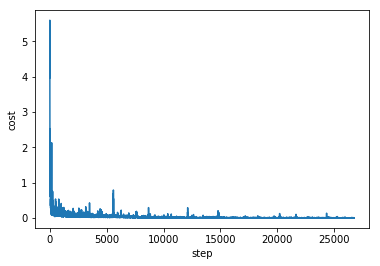

In [8]:
# Optional, print the cost per training step
import pylab
pylab.figure()
pylab.plot(costs)
pylab.xlabel('step')
pylab.ylabel('cost')
pylab.show()

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records/checkpoint-26749


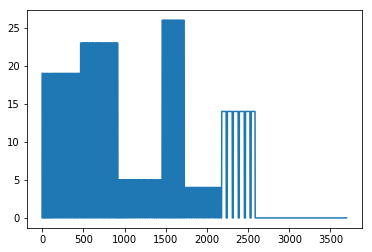

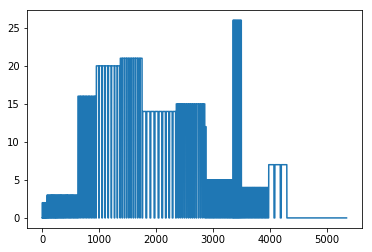

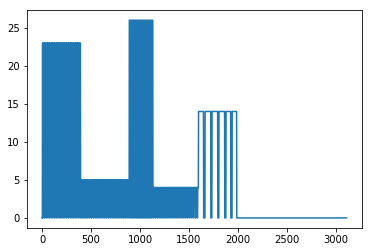

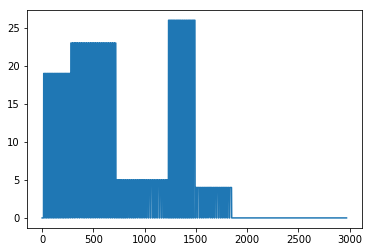

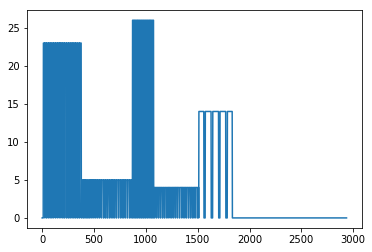

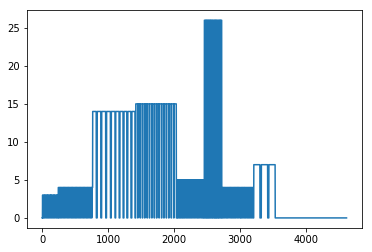

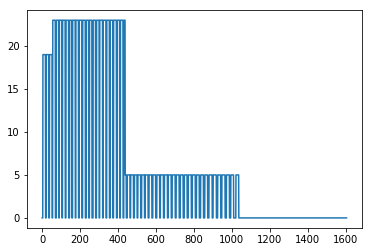

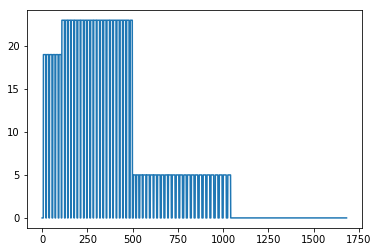

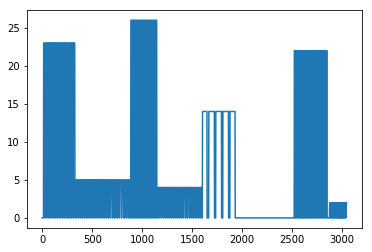

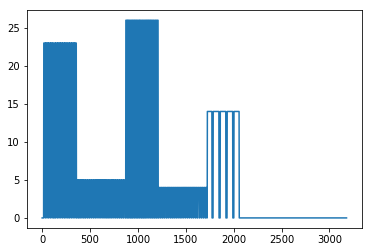

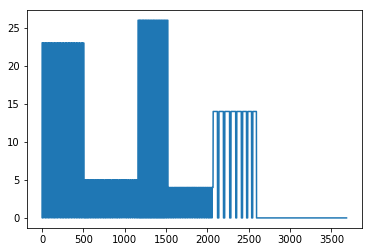

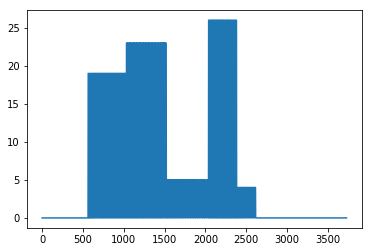

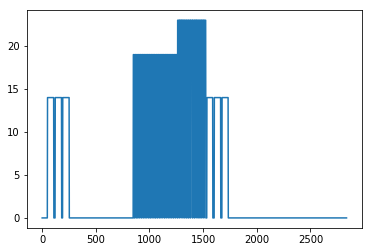

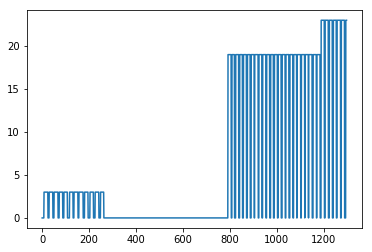

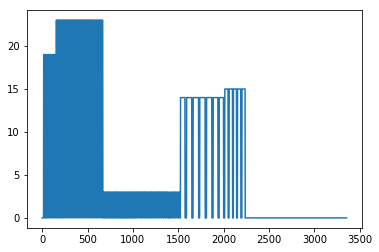

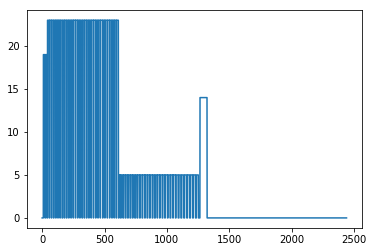

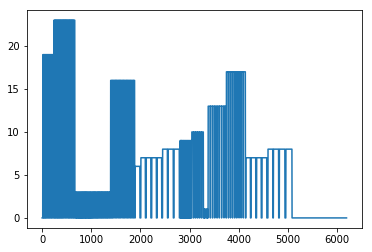

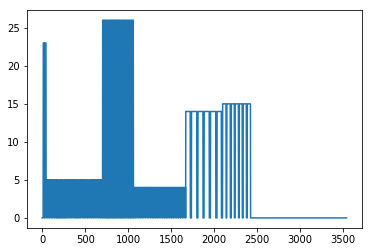

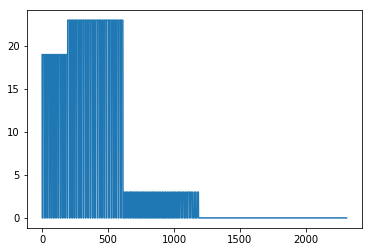

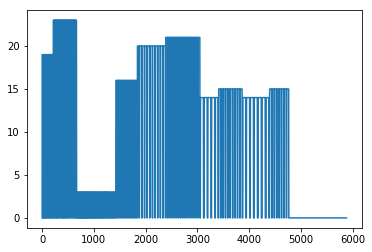

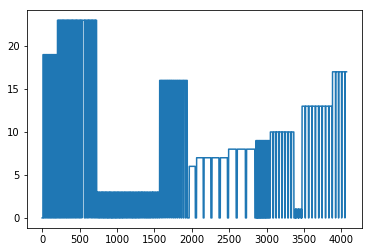

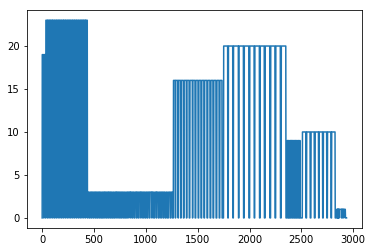

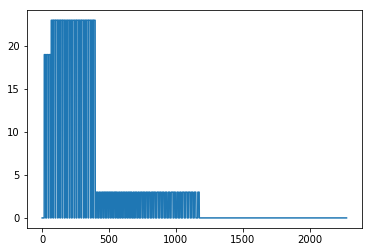

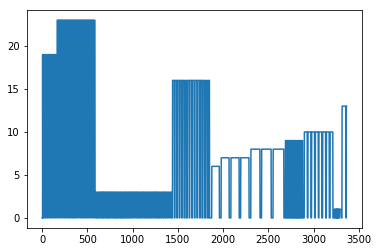

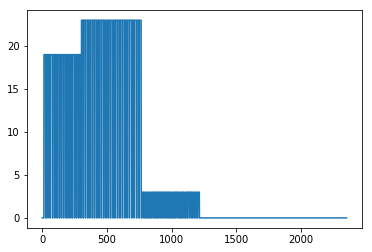

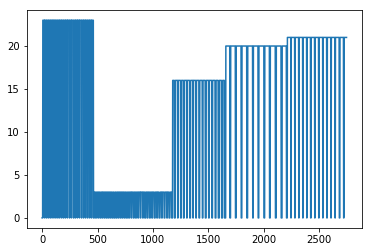

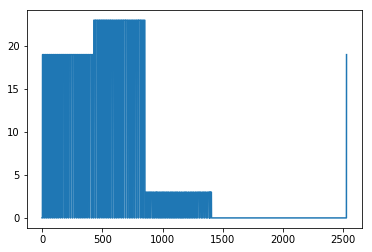

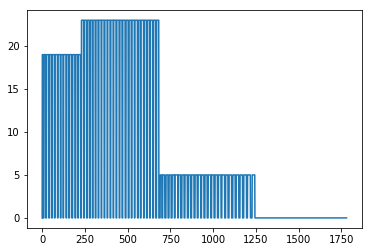

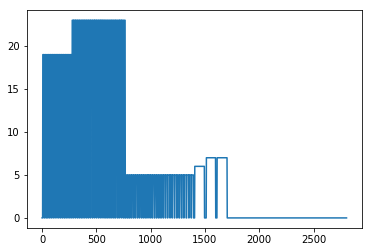

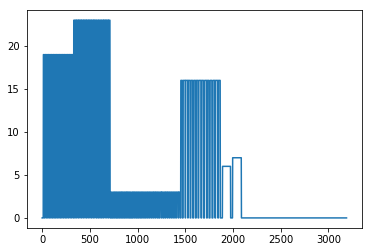

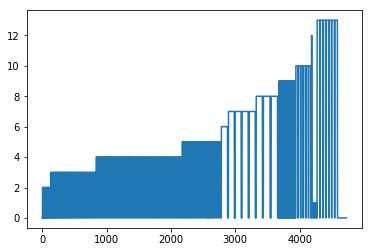

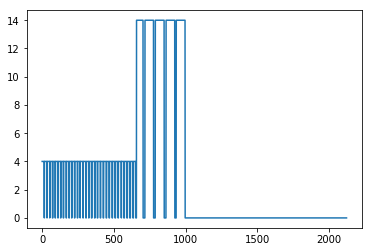

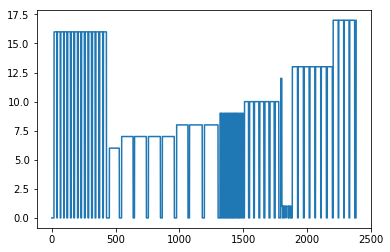

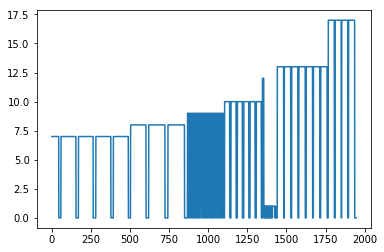

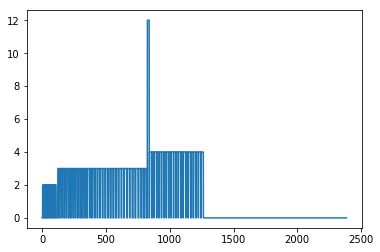

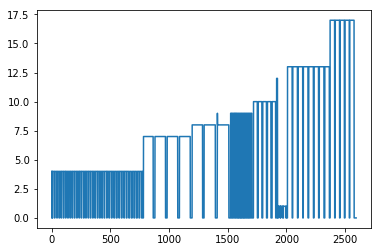

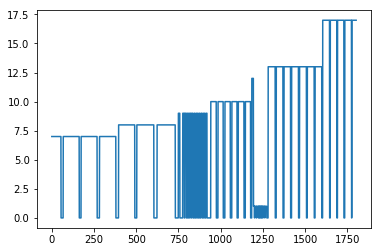

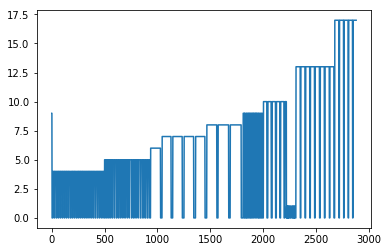

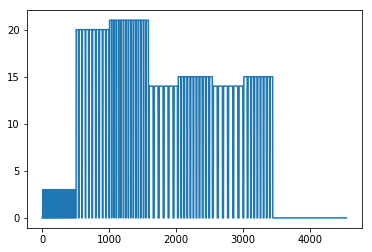

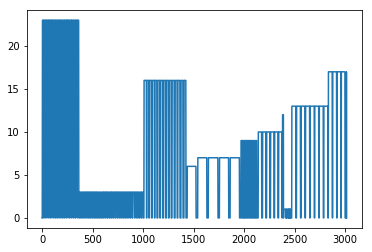

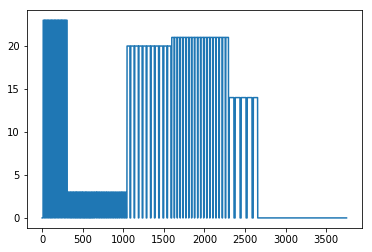

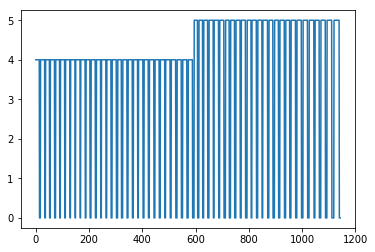

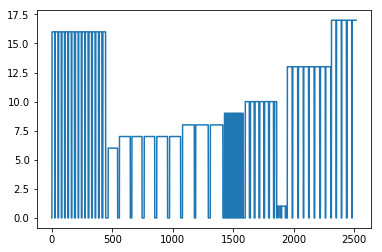

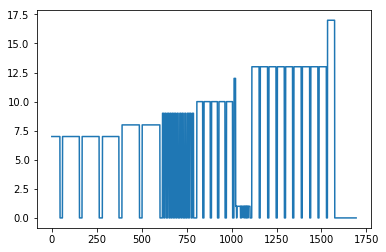

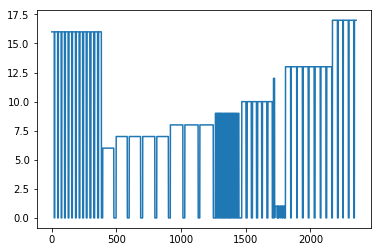

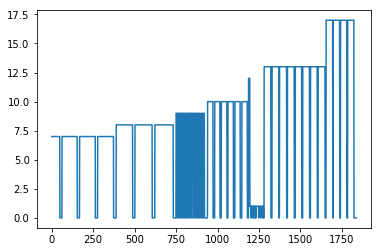

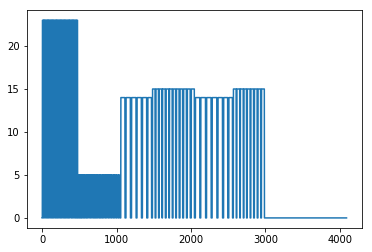

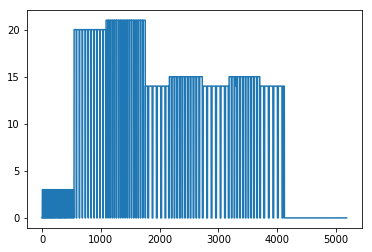

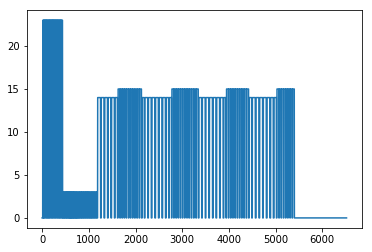

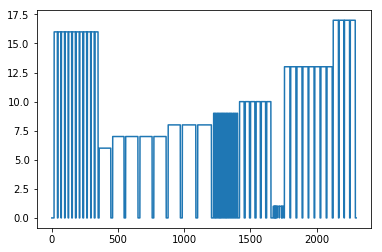

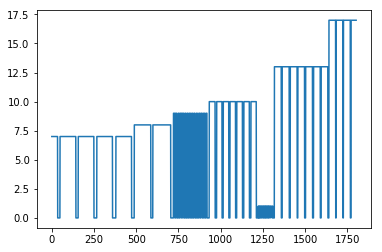

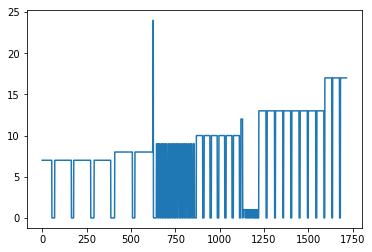

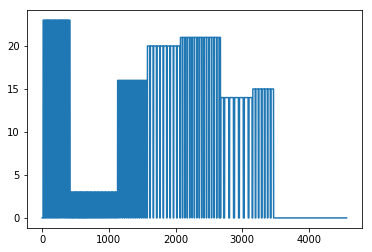

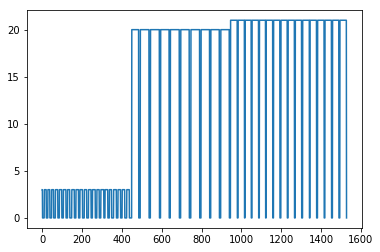

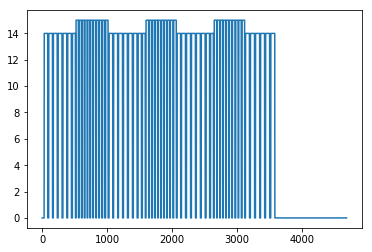

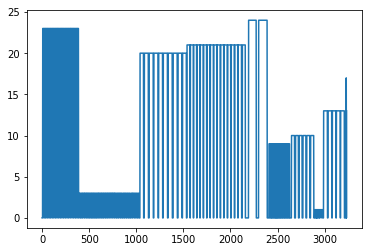

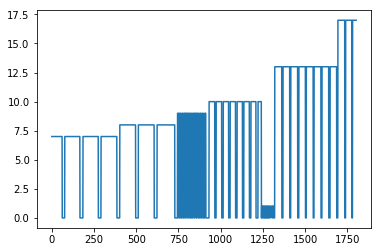

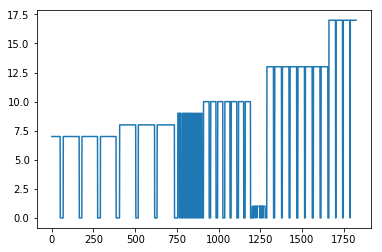

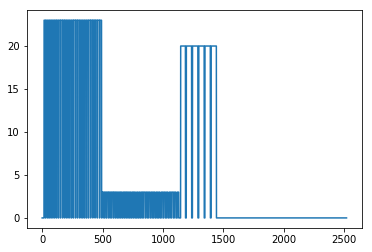

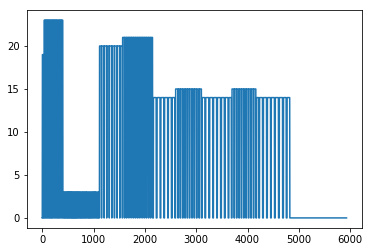

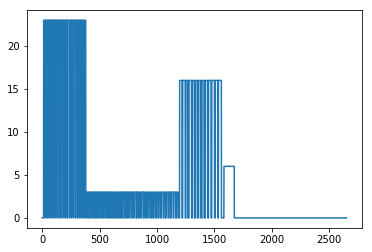

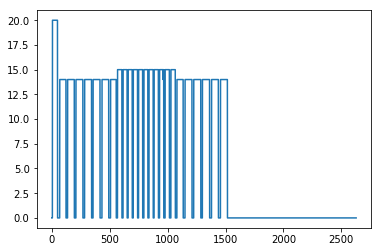

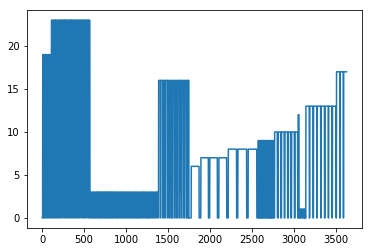

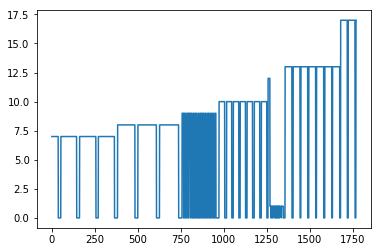

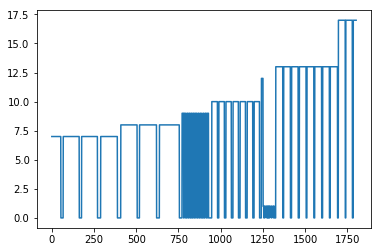

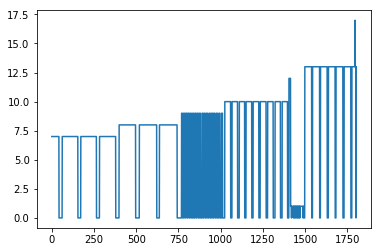

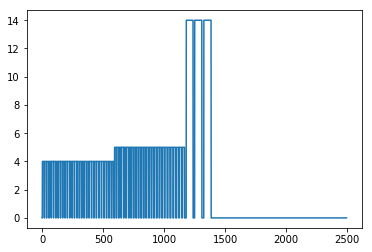

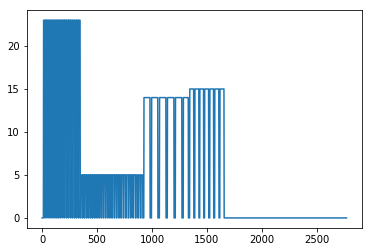

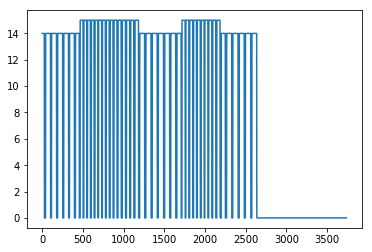

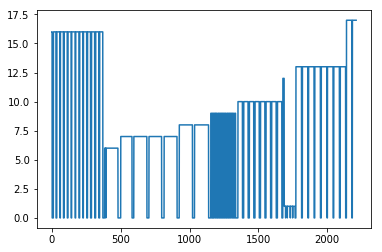

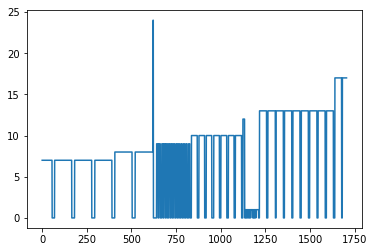

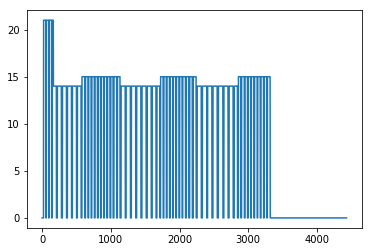

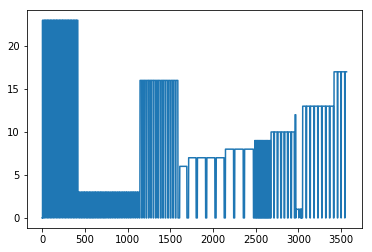

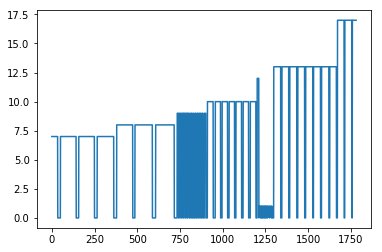

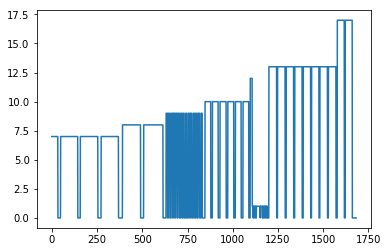

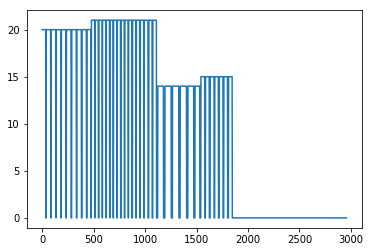

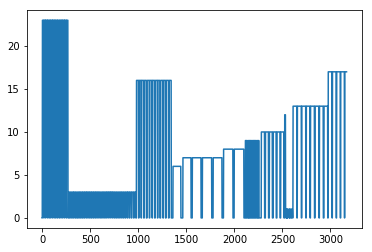

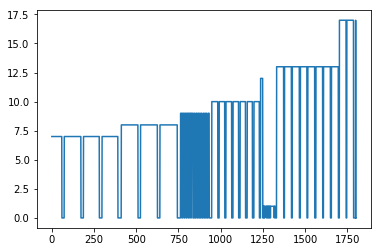

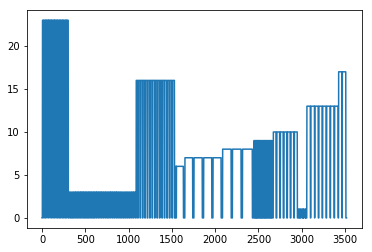

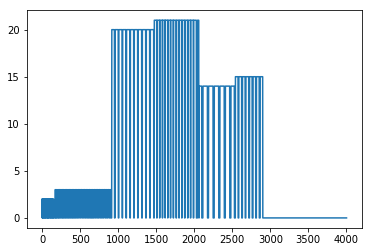

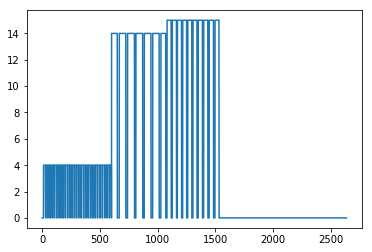

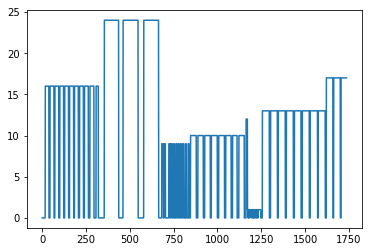

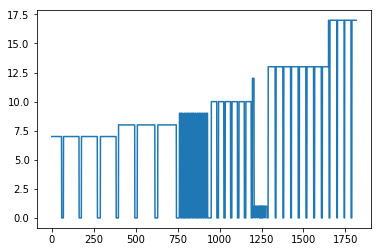

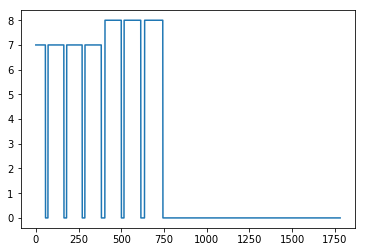

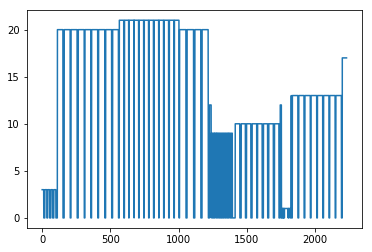

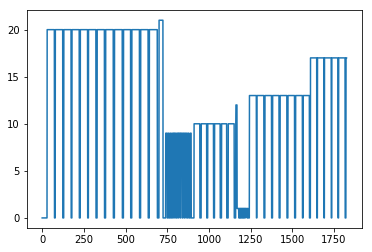

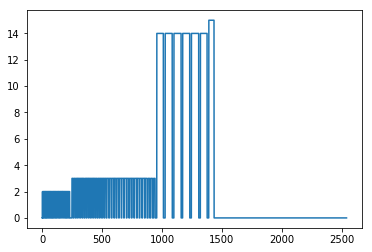

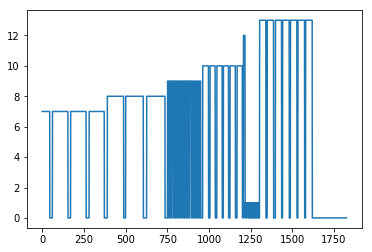

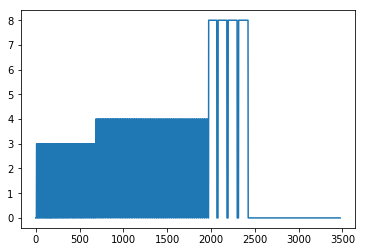

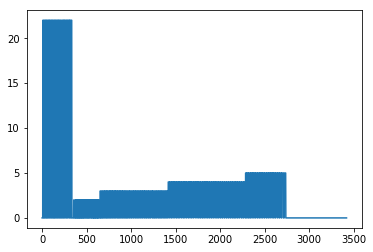

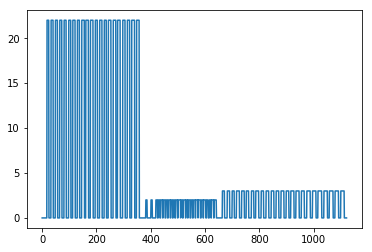

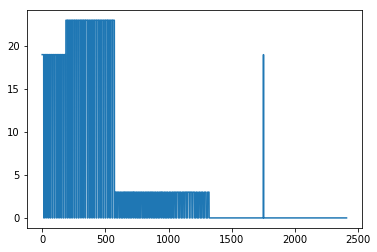

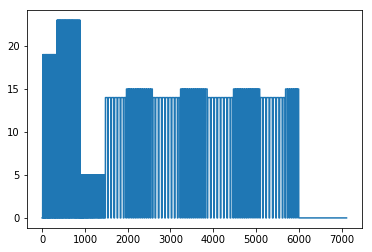

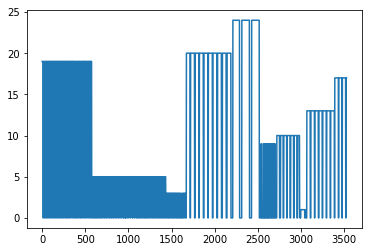

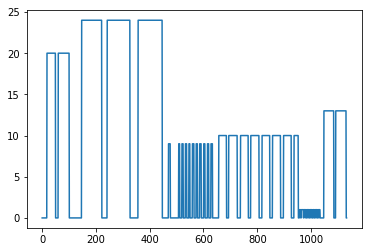

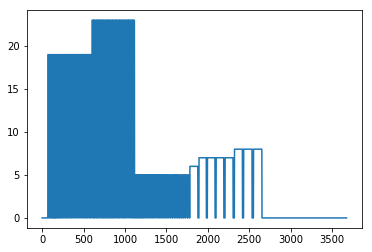

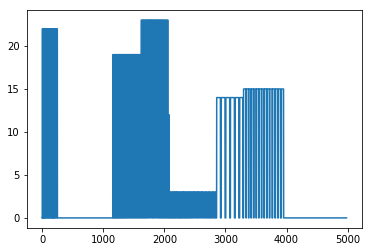

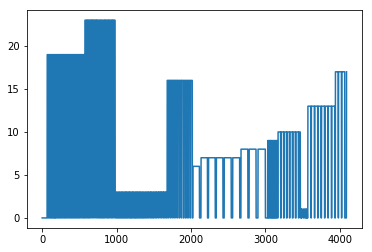

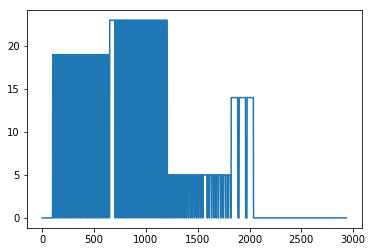

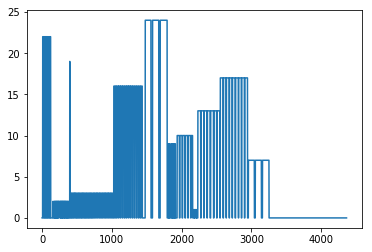

In [9]:
# Evaluate training set from a saved checkpoint. Remember to choose the correct checkpoint
import pylab

with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-26749.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-26749"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)
    
    # Run evaluation.
    errors = []
    for file_num in range(number_of_files):
        # load current training file
        fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
        data = cpio.loadmat(data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        intY = data['labels'][0]
        
        temp_n = len(intY)/batch_size
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
        
        # Optional code for zero padding. Can replace the 3 lines above.
        #temp_n = data1.shape[0]/batch_size
        #rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        #data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        #intY = np.append(intY,np.zeros((rows_to_append,1)),axis = 0)
        #temp_n = temp_n + 1
        #data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
         
        d = {X: data1,Y:intY, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        errors.append(np.abs(np.squeeze(pred[1]).reshape(-1)-intY.reshape(-1)) != 0)
        pylab.figure()
        pylab.plot(np.squeeze(pred[1]).reshape(-1))
       # pylab.plot(intY.reshape(-1))
        pylab.show()

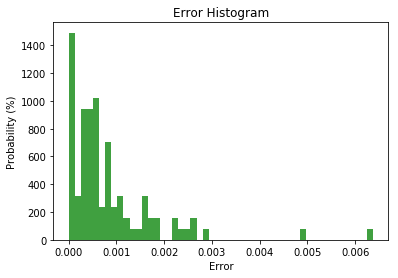

In [10]:
# Results on training set. Calculates the error histogram on the training set files. 
# Error is the fraction of mismatched bins.
pylab.figure()
n, bins, patches = pylab.hist([np.mean(err) for err in errors], 50, normed=True, facecolor='green', alpha=0.75)
pylab.xlabel('Error')
pylab.ylabel('Probability (%)')
pylab.title('Error Histogram')
pylab.show()
# print np.mean([np.mean(err) for err in errors]) # uncomment to calculate mean error

In [11]:
# Use the trained model to label the test set or unlabeled data.
# Remember to choose the correct checkpoint.
# test_data_directory = '/Users/yardenc/Documents/Experiments/SannesFinches/TrainingSet/k71o7_data/test'
import glob
os.chdir(test_data_directory)
file_list = glob.glob('*.mat')

# Evaluate training set from a saved checkpoint
with tf.Session(graph=tf.Graph()) as sess:
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-26749.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-26749"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]

    # Add an Op that chooses the top k predictions.
    eval_op = tf.nn.top_k(logits)

    # Run evaluation.
    # load current training file
    keys = np.zeros((len(file_list),), dtype=np.object)
    estimates = np.zeros((len(file_list),), dtype=np.object)
    file_num = 0
    for fname in file_list:
    #fname = file_list[file_num]
        print fname
        keys[file_num] = fname    
        data = cpio.loadmat(test_data_directory + '/' + fname)
        data1 = np.transpose(data['s'])
        print data1.shape
        temp_n = data1.shape[0]/batch_size
        rows_to_append = (temp_n + 1)*batch_size - data1.shape[0]
        data1 = np.append(data1,np.zeros((rows_to_append,input_vec_size)),axis = 0)
        print data1.shape
        temp_n = temp_n + 1
        data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
        print data1.shape
        d = {X: data1, lng:[temp_n]*batch_size} #*batch_size
        pred = sess.run(eval_op,feed_dict = d) #eval_op
        estim = np.squeeze(pred[1]).reshape(-1)
        estimates[file_num] = estim
        file_num = file_num + 1

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records/checkpoint-26749
lbr3022_0001_2017_04_01_07_34_07.mat
(544, 513)
(550, 513)
(11, 50, 513)
lbr3022_0002_2017_04_05_07_36_25.mat
(553, 513)
(561, 513)
(11, 51, 513)
lbr3022_0003_2017_04_05_07_55_15.mat
(521, 513)
(528, 513)
(11, 48, 513)
lbr3022_0004_2017_04_05_09_18_48.mat
(535, 513)
(539, 513)
(11, 49, 513)
lbr3022_0005_2017_04_05_09_21_17.mat
(568, 513)
(572, 513)
(11, 52, 513)
lbr3022_0006_2017_04_05_10_01_07.mat
(1669, 513)
(1672, 513)
(11, 152, 513)
lbr3022_0007_2017_04_05_10_01_14.mat
(1785, 513)
(1793, 513)
(11, 163, 513)
lbr3022_0008_2017_04_05_10_01_55.mat
(1656, 513)
(1661, 513)
(11, 151, 513)
lbr3022_0009_2017_04_05_10_02_02.mat
(1472, 513)
(1474, 513)
(11, 134, 513)
lbr3022_0010_2017_04_05_10_02_20.mat
(1980, 513)
(1991, 513)
(11, 181, 513)
lbr3022_0011_2017_04_05_10_02_28.mat
(3747, 513)
(3751, 513)
(11, 341, 513)
lbr3022_0012_2017_04_05_10_11_38.mat
(1

lbr3022_0108_2017_04_12_07_30_59.mat
(2060, 513)
(2068, 513)
(11, 188, 513)
lbr3022_0109_2017_04_12_07_39_00.mat
(1971, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0110_2017_04_12_07_39_08.mat
(3582, 513)
(3586, 513)
(11, 326, 513)
lbr3022_0111_2017_04_12_07_39_18.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_0112_2017_04_12_07_39_25.mat
(3496, 513)
(3498, 513)
(11, 318, 513)
lbr3022_0113_2017_04_12_07_39_36.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_0114_2017_04_12_07_42_26.mat
(4347, 513)
(4356, 513)
(11, 396, 513)
lbr3022_0115_2017_04_12_07_42_39.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0116_2017_04_12_07_42_48.mat
(1885, 513)
(1892, 513)
(11, 172, 513)
lbr3022_0117_2017_04_12_07_42_54.mat
(2957, 513)
(2959, 513)
(11, 269, 513)
lbr3022_0118_2017_04_12_07_43_33.mat
(2501, 513)
(2508, 513)
(11, 228, 513)
lbr3022_0119_2017_04_12_08_28_41.mat
(3589, 513)
(3597, 513)
(11, 327, 513)
lbr3022_0120_2017_04_12_08_28_51.mat
(3017, 513)
(3025, 513)
(11, 275, 513)
lbr3022_0121

lbr3022_0216_2017_04_20_07_23_08.mat
(1354, 513)
(1364, 513)
(11, 124, 513)
lbr3022_0217_2017_04_20_07_23_14.mat
(2256, 513)
(2266, 513)
(11, 206, 513)
lbr3022_0218_2017_04_20_07_23_22.mat
(2795, 513)
(2805, 513)
(11, 255, 513)
lbr3022_0219_2017_04_20_07_23_38.mat
(1545, 513)
(1551, 513)
(11, 141, 513)
lbr3022_0220_2017_04_20_07_23_49.mat
(7094, 513)
(7095, 513)
(11, 645, 513)
lbr3022_0221_2017_04_20_07_24_11.mat
(1551, 513)
(1562, 513)
(11, 142, 513)
lbr3022_0222_2017_04_20_07_24_18.mat
(1354, 513)
(1364, 513)
(11, 124, 513)
lbr3022_0223_2017_04_20_07_24_23.mat
(2757, 513)
(2761, 513)
(11, 251, 513)
lbr3022_0224_2017_04_20_07_24_33.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lbr3022_0225_2017_04_20_07_24_42.mat
(1330, 513)
(1331, 513)
(11, 121, 513)
lbr3022_0226_2017_04_20_07_24_49.mat
(2388, 513)
(2398, 513)
(11, 218, 513)
lbr3022_0227_2017_04_20_07_24_58.mat
(1607, 513)
(1617, 513)
(11, 147, 513)
lbr3022_0228_2017_04_20_07_25_05.mat
(2511, 513)
(2519, 513)
(11, 229, 513)
lbr3022_0229

lbr3022_0324_2017_04_20_08_13_28.mat
(2697, 513)
(2706, 513)
(11, 246, 513)
lbr3022_0325_2017_04_20_08_13_39.mat
(1778, 513)
(1782, 513)
(11, 162, 513)
lbr3022_0326_2017_04_20_08_13_45.mat
(1679, 513)
(1683, 513)
(11, 153, 513)
lbr3022_0327_2017_04_20_08_13_51.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0328_2017_04_20_08_14_20.mat
(1971, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0329_2017_04_20_08_15_20.mat
(1282, 513)
(1287, 513)
(11, 117, 513)
lbr3022_0330_2017_04_20_08_15_24.mat
(1467, 513)
(1474, 513)
(11, 134, 513)
lbr3022_0331_2017_04_20_08_15_29.mat
(1701, 513)
(1705, 513)
(11, 155, 513)
lbr3022_0332_2017_04_20_08_15_49.mat
(2046, 513)
(2057, 513)
(11, 187, 513)
lbr3022_0333_2017_04_20_08_15_58.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lbr3022_0334_2017_04_20_08_16_05.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lbr3022_0335_2017_04_20_08_16_11.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lbr3022_0336_2017_04_20_08_17_30.mat
(1559, 513)
(1562, 513)
(11, 142, 513)
lbr3022_0337

lbr3022_0432_2017_04_21_07_35_47.mat
(3442, 513)
(3443, 513)
(11, 313, 513)
lbr3022_0433_2017_04_21_07_36_01.mat
(2812, 513)
(2816, 513)
(11, 256, 513)
lbr3022_0434_2017_04_21_07_36_11.mat
(1961, 513)
(1969, 513)
(11, 179, 513)
lbr3022_0435_2017_04_21_07_36_24.mat
(4255, 513)
(4257, 513)
(11, 387, 513)
lbr3022_0436_2017_04_21_07_44_13.mat
(1174, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0437_2017_04_21_07_44_18.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lbr3022_0438_2017_04_21_07_44_25.mat
(1347, 513)
(1353, 513)
(11, 123, 513)
lbr3022_0439_2017_04_21_07_47_03.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0440_2017_04_21_07_47_10.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0441_2017_04_21_07_47_18.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_0442_2017_04_21_07_47_39.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lbr3022_0443_2017_04_21_07_47_47.mat
(2294, 513)
(2299, 513)
(11, 209, 513)
lbr3022_0444_2017_04_21_07_47_54.mat
(2731, 513)
(2739, 513)
(11, 249, 513)
lbr3022_0445

lbr3022_0540_2017_04_23_06_40_02.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0541_2017_04_23_06_40_20.mat
(2664, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0542_2017_04_23_06_40_33.mat
(1884, 513)
(1892, 513)
(11, 172, 513)
lbr3022_0543_2017_04_23_06_50_34.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_0544_2017_04_23_06_50_38.mat
(3349, 513)
(3355, 513)
(11, 305, 513)
lbr3022_0545_2017_04_23_06_50_48.mat
(2541, 513)
(2552, 513)
(11, 232, 513)
lbr3022_0546_2017_04_23_06_50_57.mat
(1935, 513)
(1936, 513)
(11, 176, 513)
lbr3022_0547_2017_04_23_06_51_03.mat
(1937, 513)
(1947, 513)
(11, 177, 513)
lbr3022_0548_2017_04_23_06_51_19.mat
(2637, 513)
(2640, 513)
(11, 240, 513)
lbr3022_0549_2017_04_23_06_51_34.mat
(2682, 513)
(2684, 513)
(11, 244, 513)
lbr3022_0550_2017_04_23_06_51_45.mat
(3081, 513)
(3091, 513)
(11, 281, 513)
lbr3022_0551_2017_04_23_06_51_58.mat
(3572, 513)
(3575, 513)
(11, 325, 513)
lbr3022_0552_2017_04_23_06_52_17.mat
(1974, 513)
(1980, 513)
(11, 180, 513)
lbr3022_0553

lbr3022_0648_2017_04_25_07_58_42.mat
(3709, 513)
(3718, 513)
(11, 338, 513)
lbr3022_0649_2017_04_25_07_58_53.mat
(3857, 513)
(3861, 513)
(11, 351, 513)
lbr3022_0650_2017_04_25_07_59_10.mat
(3767, 513)
(3773, 513)
(11, 343, 513)
lbr3022_0651_2017_04_25_08_53_05.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lbr3022_0652_2017_04_25_08_53_13.mat
(1767, 513)
(1771, 513)
(11, 161, 513)
lbr3022_0653_2017_04_25_08_53_22.mat
(2062, 513)
(2068, 513)
(11, 188, 513)
lbr3022_0654_2017_04_25_08_53_34.mat
(3520, 513)
(3531, 513)
(11, 321, 513)
lbr3022_0655_2017_04_25_08_53_51.mat
(1980, 513)
(1991, 513)
(11, 181, 513)
lbr3022_0656_2017_04_25_08_54_03.mat
(1847, 513)
(1848, 513)
(11, 168, 513)
lbr3022_0657_2017_04_25_08_54_22.mat
(1245, 513)
(1254, 513)
(11, 114, 513)
lbr3022_0658_2017_04_25_08_54_25.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lbr3022_0659_2017_04_25_08_54_35.mat
(2662, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0660_2017_04_25_08_54_55.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0661

lbr3022_0756_2017_04_30_07_00_44.mat
(2501, 513)
(2508, 513)
(11, 228, 513)
lbr3022_0757_2017_04_30_07_00_56.mat
(2356, 513)
(2365, 513)
(11, 215, 513)
lbr3022_0758_2017_04_30_07_11_48.mat
(1478, 513)
(1485, 513)
(11, 135, 513)
lbr3022_0759_2017_04_30_07_11_52.mat
(1143, 513)
(1144, 513)
(11, 104, 513)
lbr3022_0760_2017_04_30_07_28_13.mat
(2683, 513)
(2684, 513)
(11, 244, 513)
lbr3022_0761_2017_04_30_07_28_22.mat
(2730, 513)
(2739, 513)
(11, 249, 513)
lbr3022_0762_2017_04_30_07_28_46.mat
(1724, 513)
(1727, 513)
(11, 157, 513)
lbr3022_0763_2017_04_30_07_28_55.mat
(2759, 513)
(2761, 513)
(11, 251, 513)
lbr3022_0764_2017_04_30_07_29_06.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0765_2017_04_30_07_29_12.mat
(1331, 513)
(1342, 513)
(11, 122, 513)
lbr3022_0766_2017_04_30_07_29_19.mat
(1706, 513)
(1716, 513)
(11, 156, 513)
lbr3022_0767_2017_04_30_07_29_26.mat
(2612, 513)
(2618, 513)
(11, 238, 513)
lbr3022_0768_2017_04_30_07_29_41.mat
(2239, 513)
(2244, 513)
(11, 204, 513)
lbr3022_0769

lbr3022_0864_2017_05_03_08_38_35.mat
(1184, 513)
(1188, 513)
(11, 108, 513)
lbr3022_0865_2017_05_03_08_39_01.mat
(1430, 513)
(1441, 513)
(11, 131, 513)
lbr3022_0866_2017_05_03_08_40_40.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_0867_2017_05_03_08_43_36.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0868_2017_05_03_08_51_13.mat
(1229, 513)
(1232, 513)
(11, 112, 513)
lbr3022_0869_2017_05_04_06_05_36.mat
(3012, 513)
(3014, 513)
(11, 274, 513)
lbr3022_0870_2017_05_04_06_06_02.mat
(2600, 513)
(2607, 513)
(11, 237, 513)
lbr3022_0871_2017_05_04_06_10_24.mat
(5405, 513)
(5412, 513)
(11, 492, 513)
lbr3022_0872_2017_05_04_06_10_43.mat
(4158, 513)
(4169, 513)
(11, 379, 513)
lbr3022_0873_2017_05_04_06_11_00.mat
(4086, 513)
(4092, 513)
(11, 372, 513)
lbr3022_0874_2017_05_04_06_11_22.mat
(6110, 513)
(6116, 513)
(11, 556, 513)
lbr3022_0875_2017_05_04_06_11_50.mat
(4222, 513)
(4224, 513)
(11, 384, 513)
lbr3022_0876_2017_05_04_06_16_26.mat
(1176, 513)
(1177, 513)
(11, 107, 513)
lbr3022_0877

lbr3022_0972_2017_05_09_08_58_11.mat
(5035, 513)
(5038, 513)
(11, 458, 513)
lbr3022_0973_2017_05_10_08_29_45.mat
(4462, 513)
(4466, 513)
(11, 406, 513)
lbr3022_0974_2017_05_10_08_30_00.mat
(1343, 513)
(1353, 513)
(11, 123, 513)
lbr3022_0975_2017_05_10_08_30_11.mat
(2242, 513)
(2244, 513)
(11, 204, 513)
lbr3022_0976_2017_05_10_08_30_25.mat
(2974, 513)
(2981, 513)
(11, 271, 513)
lbr3022_0977_2017_05_10_08_31_23.mat
(1286, 513)
(1287, 513)
(11, 117, 513)
lbr3022_0978_2017_05_10_08_31_48.mat
(1384, 513)
(1386, 513)
(11, 126, 513)
lbr3022_0979_2017_05_11_06_21_30.mat
(2042, 513)
(2046, 513)
(11, 186, 513)
lbr3022_0980_2017_05_11_06_21_52.mat
(1906, 513)
(1914, 513)
(11, 174, 513)
lbr3022_0981_2017_05_11_06_21_59.mat
(2672, 513)
(2673, 513)
(11, 243, 513)
lbr3022_0982_2017_05_11_06_25_45.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_0983_2017_05_11_06_25_48.mat
(3165, 513)
(3168, 513)
(11, 288, 513)
lbr3022_0984_2017_05_11_06_26_03.mat
(7908, 513)
(7909, 513)
(11, 719, 513)
lbr3022_0985

lbr3022_1080_2017_05_16_06_25_27.mat
(4537, 513)
(4543, 513)
(11, 413, 513)
lbr3022_1081_2017_05_16_06_25_40.mat
(2360, 513)
(2365, 513)
(11, 215, 513)
lbr3022_1082_2017_05_16_06_26_28.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1083_2017_05_16_06_26_40.mat
(1173, 513)
(1177, 513)
(11, 107, 513)
lbr3022_1084_2017_05_16_06_30_03.mat
(2593, 513)
(2596, 513)
(11, 236, 513)
lbr3022_1085_2017_05_16_06_50_16.mat
(2553, 513)
(2563, 513)
(11, 233, 513)
lbr3022_1086_2017_05_16_06_50_29.mat
(4503, 513)
(4510, 513)
(11, 410, 513)
lbr3022_1087_2017_05_16_06_58_37.mat
(2038, 513)
(2046, 513)
(11, 186, 513)
lbr3022_1088_2017_05_16_06_58_43.mat
(1496, 513)
(1507, 513)
(11, 137, 513)
lbr3022_1089_2017_05_16_06_59_12.mat
(2447, 513)
(2453, 513)
(11, 223, 513)
lbr3022_1090_2017_05_16_07_16_28.mat
(1335, 513)
(1342, 513)
(11, 122, 513)
lbr3022_1091_2017_05_16_07_16_42.mat
(2408, 513)
(2409, 513)
(11, 219, 513)
lbr3022_1092_2017_05_16_08_58_45.mat
(4029, 513)
(4037, 513)
(11, 367, 513)
lbr3022_1093

lbr3022_1188_2017_05_22_07_56_19.mat
(2454, 513)
(2464, 513)
(11, 224, 513)
lbr3022_1189_2017_05_22_07_56_29.mat
(2714, 513)
(2717, 513)
(11, 247, 513)
lbr3022_1190_2017_05_22_07_56_37.mat
(2122, 513)
(2123, 513)
(11, 193, 513)
lbr3022_1191_2017_05_22_07_57_13.mat
(1184, 513)
(1188, 513)
(11, 108, 513)
lbr3022_1192_2017_05_22_07_57_19.mat
(1826, 513)
(1837, 513)
(11, 167, 513)
lbr3022_1193_2017_05_22_07_57_25.mat
(2736, 513)
(2739, 513)
(11, 249, 513)
lbr3022_1194_2017_05_22_07_57_36.mat
(1664, 513)
(1672, 513)
(11, 152, 513)
lbr3022_1195_2017_05_22_07_57_45.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_1196_2017_05_22_07_57_52.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_1197_2017_05_22_07_57_57.mat
(2913, 513)
(2915, 513)
(11, 265, 513)
lbr3022_1198_2017_05_22_07_58_09.mat
(3727, 513)
(3729, 513)
(11, 339, 513)
lbr3022_1199_2017_05_22_07_58_23.mat
(1156, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1200_2017_05_22_07_58_51.mat
(3549, 513)
(3553, 513)
(11, 323, 513)
lbr3022_1201

lbr3022_1296_2017_05_24_06_56_48.mat
(3909, 513)
(3916, 513)
(11, 356, 513)
lbr3022_1297_2017_05_24_06_57_01.mat
(2281, 513)
(2288, 513)
(11, 208, 513)
lbr3022_1298_2017_05_24_06_57_58.mat
(1570, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1299_2017_05_24_06_58_11.mat
(4307, 513)
(4312, 513)
(11, 392, 513)
lbr3022_1300_2017_05_24_06_58_33.mat
(4941, 513)
(4950, 513)
(11, 450, 513)
lbr3022_1301_2017_05_24_06_59_10.mat
(2091, 513)
(2101, 513)
(11, 191, 513)
lbr3022_1302_2017_05_24_06_59_17.mat
(3527, 513)
(3531, 513)
(11, 321, 513)
lbr3022_1303_2017_05_24_06_59_39.mat
(3322, 513)
(3333, 513)
(11, 303, 513)
lbr3022_1304_2017_05_24_06_59_48.mat
(1787, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1305_2017_05_24_06_59_54.mat
(1380, 513)
(1386, 513)
(11, 126, 513)
lbr3022_1306_2017_05_24_07_00_16.mat
(6505, 513)
(6512, 513)
(11, 592, 513)
lbr3022_1307_2017_05_24_07_00_59.mat
(5237, 513)
(5247, 513)
(11, 477, 513)
lbr3022_1308_2017_05_24_07_01_13.mat
(2341, 513)
(2343, 513)
(11, 213, 513)
lbr3022_1309

lbr3022_1405_2017_05_25_07_00_39.mat
(1356, 513)
(1364, 513)
(11, 124, 513)
lbr3022_1406_2017_05_25_07_02_37.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1407_2017_05_25_07_02_42.mat
(1601, 513)
(1606, 513)
(11, 146, 513)
lbr3022_1408_2017_05_25_07_02_50.mat
(1996, 513)
(2002, 513)
(11, 182, 513)
lbr3022_1409_2017_05_25_07_03_04.mat
(2369, 513)
(2376, 513)
(11, 216, 513)
lbr3022_1410_2017_05_25_07_03_18.mat
(1510, 513)
(1518, 513)
(11, 138, 513)
lbr3022_1411_2017_05_25_07_03_22.mat
(1928, 513)
(1936, 513)
(11, 176, 513)
lbr3022_1412_2017_05_25_07_03_28.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1413_2017_05_25_07_03_45.mat
(2831, 513)
(2838, 513)
(11, 258, 513)
lbr3022_1414_2017_05_25_07_04_00.mat
(2831, 513)
(2838, 513)
(11, 258, 513)
lbr3022_1415_2017_05_25_07_04_08.mat
(1922, 513)
(1925, 513)
(11, 175, 513)
lbr3022_1416_2017_05_25_07_04_34.mat
(2760, 513)
(2761, 513)
(11, 251, 513)
lbr3022_1417_2017_05_25_07_04_42.mat
(1614, 513)
(1617, 513)
(11, 147, 513)
lbr3022_1418

lbr3022_1514_2017_05_26_07_46_40.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_1515_2017_05_26_07_50_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1516_2017_05_26_07_53_24.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1517_2017_05_26_07_53_43.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1518_2017_05_26_07_57_53.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1519_2017_05_26_07_59_14.mat
(2809, 513)
(2816, 513)
(11, 256, 513)
lbr3022_1520_2017_05_26_07_59_29.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1521_2017_05_26_07_59_33.mat
(2551, 513)
(2552, 513)
(11, 232, 513)
lbr3022_1522_2017_05_26_08_00_02.mat
(3191, 513)
(3201, 513)
(11, 291, 513)
lbr3022_1523_2017_05_26_08_00_16.mat
(3673, 513)
(3674, 513)
(11, 334, 513)
lbr3022_1524_2017_05_26_08_01_50.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1525_2017_05_26_08_02_26.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_1526_2017_05_26_08_02_31.mat
(1797, 513)
(1804, 513)
(11, 164, 513)
lbr3022_1527

lbr3022_1623_2017_05_30_06_39_53.mat
(4571, 513)
(4576, 513)
(11, 416, 513)
lbr3022_1624_2017_05_30_06_40_29.mat
(1531, 513)
(1540, 513)
(11, 140, 513)
lbr3022_1625_2017_05_30_06_40_33.mat
(4690, 513)
(4697, 513)
(11, 427, 513)
lbr3022_1626_2017_05_30_06_41_26.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lbr3022_1627_2017_05_30_06_41_36.mat
(1812, 513)
(1815, 513)
(11, 165, 513)
lbr3022_1628_2017_05_30_06_41_42.mat
(1836, 513)
(1837, 513)
(11, 167, 513)
lbr3022_1629_2017_05_30_06_41_48.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1630_2017_05_30_06_42_09.mat
(2526, 513)
(2530, 513)
(11, 230, 513)
lbr3022_1631_2017_05_30_06_42_22.mat
(5933, 513)
(5940, 513)
(11, 540, 513)
lbr3022_1632_2017_05_30_06_42_59.mat
(2656, 513)
(2662, 513)
(11, 242, 513)
lbr3022_1633_2017_05_30_06_43_15.mat
(2634, 513)
(2640, 513)
(11, 240, 513)
lbr3022_1634_2017_05_30_06_43_50.mat
(3636, 513)
(3641, 513)
(11, 331, 513)
lbr3022_1635_2017_05_30_06_44_01.mat
(1775, 513)
(1782, 513)
(11, 162, 513)
lbr3022_1636

lbr3022_1731_2017_05_31_07_25_21.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1732_2017_05_31_07_43_07.mat
(1386, 513)
(1397, 513)
(11, 127, 513)
lbr3022_1733_2017_05_31_07_44_09.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_1734_2017_05_31_07_46_17.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1735_2017_05_31_07_46_57.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_1736_2017_05_31_07_51_34.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_1737_2017_05_31_07_51_37.mat
(1145, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1738_2017_05_31_07_51_43.mat
(1690, 513)
(1694, 513)
(11, 154, 513)
lbr3022_1739_2017_05_31_07_51_49.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lbr3022_1740_2017_05_31_08_18_47.mat
(1613, 513)
(1617, 513)
(11, 147, 513)
lbr3022_1741_2017_05_31_08_19_22.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_1742_2017_06_05_00_23_48.mat
(582, 513)
(583, 513)
(11, 53, 513)
lbr3022_1743_2017_06_05_00_30_01.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_1744_2017_

lbr3022_1841_2017_06_06_06_11_12.mat
(1163, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1842_2017_06_06_06_11_16.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1843_2017_06_06_06_11_24.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lbr3022_1844_2017_06_06_06_11_27.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1845_2017_06_06_06_11_31.mat
(1179, 513)
(1188, 513)
(11, 108, 513)
lbr3022_1846_2017_06_06_06_11_39.mat
(2378, 513)
(2387, 513)
(11, 217, 513)
lbr3022_1847_2017_06_06_06_11_50.mat
(2120, 513)
(2123, 513)
(11, 193, 513)
lbr3022_1848_2017_06_06_06_12_02.mat
(2729, 513)
(2739, 513)
(11, 249, 513)
lbr3022_1849_2017_06_06_06_12_18.mat
(1319, 513)
(1320, 513)
(11, 120, 513)
lbr3022_1850_2017_06_06_06_12_25.mat
(3022, 513)
(3025, 513)
(11, 275, 513)
lbr3022_1851_2017_06_06_06_13_10.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_1852_2017_06_06_06_20_08.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1853_2017_06_06_06_20_25.mat
(1161, 513)
(1166, 513)
(11, 106, 513)
lbr3022_1854

lbr3022_1949_2017_06_07_06_26_28.mat
(3189, 513)
(3190, 513)
(11, 290, 513)
lbr3022_1950_2017_06_07_06_26_37.mat
(1807, 513)
(1815, 513)
(11, 165, 513)
lbr3022_1951_2017_06_07_06_26_43.mat
(1563, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1952_2017_06_07_06_27_14.mat
(4200, 513)
(4202, 513)
(11, 382, 513)
lbr3022_1953_2017_06_07_06_27_27.mat
(1783, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1954_2017_06_07_06_27_33.mat
(1563, 513)
(1573, 513)
(11, 143, 513)
lbr3022_1955_2017_06_07_06_28_07.mat
(3577, 513)
(3586, 513)
(11, 326, 513)
lbr3022_1956_2017_06_07_06_28_18.mat
(1790, 513)
(1793, 513)
(11, 163, 513)
lbr3022_1957_2017_06_07_06_28_24.mat
(1912, 513)
(1914, 513)
(11, 174, 513)
lbr3022_1958_2017_06_07_06_28_31.mat
(1473, 513)
(1474, 513)
(11, 134, 513)
lbr3022_1959_2017_06_07_06_48_52.mat
(2412, 513)
(2420, 513)
(11, 220, 513)
lbr3022_1960_2017_06_07_06_49_10.mat
(2315, 513)
(2321, 513)
(11, 211, 513)
lbr3022_1961_2017_06_07_06_49_28.mat
(3289, 513)
(3300, 513)
(11, 300, 513)
lbr3022_1962

lbr3022_2057_2017_06_08_07_11_54.mat
(1519, 513)
(1529, 513)
(11, 139, 513)
lbr3022_2058_2017_06_08_07_34_36.mat
(3191, 513)
(3201, 513)
(11, 291, 513)
lbr3022_2059_2017_06_08_07_35_10.mat
(3206, 513)
(3212, 513)
(11, 292, 513)
lbr3022_2060_2017_06_09_07_23_57.mat
(1704, 513)
(1705, 513)
(11, 155, 513)
lbr3022_2061_2017_06_09_07_24_34.mat
(2723, 513)
(2728, 513)
(11, 248, 513)
lbr3022_2062_2017_06_09_07_24_43.mat
(1787, 513)
(1793, 513)
(11, 163, 513)
lbr3022_2063_2017_06_09_07_25_56.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_2064_2017_06_13_00_11_25.mat
(568, 513)
(572, 513)
(11, 52, 513)
lbr3022_2065_2017_06_13_00_25_32.mat
(592, 513)
(594, 513)
(11, 54, 513)
lbr3022_2066_2017_06_13_00_28_44.mat
(571, 513)
(572, 513)
(11, 52, 513)
lbr3022_2067_2017_06_13_00_31_46.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_2068_2017_06_13_01_17_43.mat
(591, 513)
(594, 513)
(11, 54, 513)
lbr3022_2069_2017_06_13_01_18_00.mat
(554, 513)
(561, 513)
(11, 51, 513)
lbr3022_2070_2017_06_13_01_18_

lbr3022_2166_2017_06_13_08_25_27.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2167_2017_06_13_08_28_08.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2168_2017_06_13_08_36_34.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2169_2017_06_13_23_22_50.mat
(1628, 513)
(1639, 513)
(11, 149, 513)
lbr3022_2170_2017_06_13_23_31_11.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2171_2017_06_13_23_41_10.mat
(1136, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2172_2017_06_13_23_45_50.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2173_2017_06_14_00_31_07.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2174_2017_06_14_00_38_28.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2175_2017_06_14_01_16_22.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2176_2017_06_14_01_21_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2177_2017_06_14_01_24_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2178_2017_06_14_02_30_37.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2179

lbr3022_2274_2017_06_14_05_59_08.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_2275_2017_06_14_05_59_58.mat
(7118, 513)
(7128, 513)
(11, 648, 513)
lbr3022_2276_2017_06_14_06_00_42.mat
(3942, 513)
(3949, 513)
(11, 359, 513)
lbr3022_2277_2017_06_14_06_00_54.mat
(2021, 513)
(2024, 513)
(11, 184, 513)
lbr3022_2278_2017_06_14_06_01_00.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lbr3022_2279_2017_06_14_06_01_18.mat
(5390, 513)
(5401, 513)
(11, 491, 513)
lbr3022_2280_2017_06_14_06_01_48.mat
(4041, 513)
(4048, 513)
(11, 368, 513)
lbr3022_2281_2017_06_14_06_01_59.mat
(1836, 513)
(1837, 513)
(11, 167, 513)
lbr3022_2282_2017_06_14_06_02_20.mat
(3925, 513)
(3927, 513)
(11, 357, 513)
lbr3022_2283_2017_06_14_06_02_32.mat
(1739, 513)
(1749, 513)
(11, 159, 513)
lbr3022_2284_2017_06_14_06_03_16.mat
(4451, 513)
(4455, 513)
(11, 405, 513)
lbr3022_2285_2017_06_14_06_03_29.mat
(1818, 513)
(1826, 513)
(11, 166, 513)
lbr3022_2286_2017_06_14_06_03_35.mat
(1391, 513)
(1397, 513)
(11, 127, 513)
lbr3022_2287

lbr3022_2383_2017_06_15_03_59_19.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_2384_2017_06_15_04_22_23.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2385_2017_06_15_05_07_01.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2386_2017_06_15_05_07_08.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2387_2017_06_15_05_07_42.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2388_2017_06_15_05_08_35.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2389_2017_06_15_05_08_52.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2390_2017_06_15_05_09_24.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2391_2017_06_15_05_09_34.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2392_2017_06_15_05_09_38.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2393_2017_06_15_05_09_53.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2394_2017_06_15_05_10_52.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2395_2017_06_15_05_11_36.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2396

lbr3022_2491_2017_06_15_06_43_05.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2492_2017_06_15_06_43_31.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2493_2017_06_15_06_43_45.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2494_2017_06_15_06_44_09.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2495_2017_06_15_06_44_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2496_2017_06_15_06_44_51.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2497_2017_06_15_06_45_08.mat
(1195, 513)
(1199, 513)
(11, 109, 513)
lbr3022_2498_2017_06_15_06_45_26.mat
(1947, 513)
(1958, 513)
(11, 178, 513)
lbr3022_2499_2017_06_15_06_45_37.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2500_2017_06_15_06_46_13.mat
(2211, 513)
(2222, 513)
(11, 202, 513)
lbr3022_2501_2017_06_15_06_46_19.mat
(1573, 513)
(1584, 513)
(11, 144, 513)
lbr3022_2502_2017_06_15_06_46_46.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2503_2017_06_15_06_47_00.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2504

lbr3022_2599_2017_06_15_08_04_41.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2600_2017_06_15_08_04_45.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2601_2017_06_15_08_05_21.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2602_2017_06_15_08_05_41.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2603_2017_06_15_08_05_48.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_2604_2017_06_15_08_05_59.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_2605_2017_06_15_08_06_08.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2606_2017_06_15_08_09_15.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2607_2017_06_15_08_11_11.mat
(1111, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2608_2017_06_15_08_12_55.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2609_2017_06_15_08_16_34.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2610_2017_06_15_08_16_56.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2611_2017_06_15_08_18_05.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2612

lbr3022_2707_2017_06_15_10_17_57.mat
(2059, 513)
(2068, 513)
(11, 188, 513)
lbr3022_2708_2017_06_15_10_18_14.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2709_2017_06_15_10_18_41.mat
(1100, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2710_2017_06_15_10_19_16.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2711_2017_06_15_10_19_45.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2712_2017_06_15_10_20_32.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2713_2017_06_15_10_21_26.mat
(1148, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2714_2017_06_15_10_21_48.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2715_2017_06_15_10_22_03.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2716_2017_06_15_10_22_10.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2717_2017_06_15_10_23_44.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2718_2017_06_15_10_24_52.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2719_2017_06_15_10_24_56.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2720

lbr3022_2815_2017_06_15_11_38_50.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2816_2017_06_15_11_39_56.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2817_2017_06_15_11_40_12.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_2818_2017_06_15_11_41_45.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_2819_2017_06_15_11_42_40.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2820_2017_06_15_11_43_15.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2821_2017_06_15_11_43_45.mat
(2526, 513)
(2530, 513)
(11, 230, 513)
lbr3022_2822_2017_06_15_11_45_44.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2823_2017_06_15_11_46_36.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_2824_2017_06_15_11_47_59.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2825_2017_06_15_11_48_48.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2826_2017_06_15_11_48_53.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_2827_2017_06_15_11_49_04.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2828

lbr3022_2923_2017_06_15_12_23_49.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2924_2017_06_15_12_23_55.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_2925_2017_06_15_12_23_58.mat
(4218, 513)
(4224, 513)
(11, 384, 513)
lbr3022_2926_2017_06_15_12_24_11.mat
(1286, 513)
(1287, 513)
(11, 117, 513)
lbr3022_2927_2017_06_15_12_24_23.mat
(3676, 513)
(3685, 513)
(11, 335, 513)
lbr3022_2928_2017_06_15_12_24_34.mat
(1857, 513)
(1859, 513)
(11, 169, 513)
lbr3022_2929_2017_06_15_12_24_40.mat
(1863, 513)
(1870, 513)
(11, 170, 513)
lbr3022_2930_2017_06_15_12_24_55.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_2931_2017_06_15_12_25_01.mat
(2867, 513)
(2871, 513)
(11, 261, 513)
lbr3022_2932_2017_06_15_12_25_09.mat
(3371, 513)
(3377, 513)
(11, 307, 513)
lbr3022_2933_2017_06_15_12_25_20.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_2934_2017_06_15_12_25_24.mat
(4731, 513)
(4741, 513)
(11, 431, 513)
lbr3022_2935_2017_06_15_12_25_50.mat
(3799, 513)
(3806, 513)
(11, 346, 513)
lbr3022_2936

lbr3022_3031_2017_06_15_12_47_11.mat
(11845, 513)
(11847, 513)
(11, 1077, 513)
lbr3022_3032_2017_06_15_12_47_44.mat
(2525, 513)
(2530, 513)
(11, 230, 513)
lbr3022_3033_2017_06_15_12_47_51.mat
(9628, 513)
(9636, 513)
(11, 876, 513)
lbr3022_3034_2017_06_15_12_48_17.mat
(7391, 513)
(7392, 513)
(11, 672, 513)
lbr3022_3035_2017_06_15_12_48_38.mat
(3142, 513)
(3146, 513)
(11, 286, 513)
lbr3022_3036_2017_06_15_12_48_47.mat
(1765, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3037_2017_06_15_12_48_52.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_3038_2017_06_15_12_49_01.mat
(4904, 513)
(4906, 513)
(11, 446, 513)
lbr3022_3039_2017_06_15_12_49_17.mat
(1216, 513)
(1221, 513)
(11, 111, 513)
lbr3022_3040_2017_06_15_12_49_30.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3041_2017_06_15_12_49_33.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_3042_2017_06_15_12_50_15.mat
(4206, 513)
(4213, 513)
(11, 383, 513)
lbr3022_3043_2017_06_15_12_50_27.mat
(2097, 513)
(2101, 513)
(11, 191, 513)
lbr3022_3

lbr3022_3139_2017_06_15_13_31_56.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3140_2017_06_15_13_32_14.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3141_2017_06_15_13_32_36.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3142_2017_06_15_13_33_39.mat
(1157, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3143_2017_06_15_13_33_52.mat
(1480, 513)
(1485, 513)
(11, 135, 513)
lbr3022_3144_2017_06_15_13_34_41.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3145_2017_06_15_13_34_52.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3146_2017_06_15_13_36_38.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3147_2017_06_15_13_37_23.mat
(1660, 513)
(1661, 513)
(11, 151, 513)
lbr3022_3148_2017_06_15_13_38_35.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3149_2017_06_15_13_39_21.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3150_2017_06_15_13_40_02.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3151_2017_06_15_13_40_50.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3152

lbr3022_3247_2017_06_15_14_59_39.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3248_2017_06_15_15_00_13.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3249_2017_06_15_15_00_39.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3250_2017_06_15_15_01_10.mat
(1379, 513)
(1386, 513)
(11, 126, 513)
lbr3022_3251_2017_06_15_15_01_22.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3252_2017_06_15_15_01_36.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3253_2017_06_15_15_02_53.mat
(1158, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3254_2017_06_15_15_03_29.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3255_2017_06_15_15_03_44.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3256_2017_06_15_15_05_38.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3257_2017_06_15_15_07_04.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3258_2017_06_15_15_08_56.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3259_2017_06_15_15_10_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3260

lbr3022_3355_2017_06_15_17_27_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3356_2017_06_15_17_31_40.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3357_2017_06_15_17_34_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3358_2017_06_15_17_34_26.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3359_2017_06_15_17_35_20.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3360_2017_06_15_17_35_27.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3361_2017_06_15_17_38_08.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3362_2017_06_15_17_38_54.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3363_2017_06_15_17_40_35.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3364_2017_06_15_17_40_44.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3365_2017_06_15_17_40_52.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3366_2017_06_15_17_42_19.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3367_2017_06_15_17_43_20.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3368

lbr3022_3463_2017_06_15_19_00_44.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3464_2017_06_15_19_00_50.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3465_2017_06_15_19_01_24.mat
(1221, 513)
(1232, 513)
(11, 112, 513)
lbr3022_3466_2017_06_15_19_01_47.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3467_2017_06_15_19_03_06.mat
(1762, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3468_2017_06_15_19_03_13.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3469_2017_06_15_19_03_22.mat
(1366, 513)
(1375, 513)
(11, 125, 513)
lbr3022_3470_2017_06_15_19_04_24.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3471_2017_06_15_19_11_41.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3472_2017_06_15_19_13_37.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3473_2017_06_15_19_21_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3474_2017_06_15_19_21_46.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3475_2017_06_15_19_22_26.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3476

lbr3022_3571_2017_06_15_23_09_15.mat
(1553, 513)
(1562, 513)
(11, 142, 513)
lbr3022_3572_2017_06_15_23_09_40.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3573_2017_06_15_23_10_48.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3574_2017_06_15_23_20_57.mat
(1072, 513)
(1078, 513)
(11, 98, 513)
lbr3022_3575_2017_06_15_23_23_30.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3576_2017_06_15_23_26_37.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3577_2017_06_15_23_48_50.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3578_2017_06_15_23_49_25.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3579_2017_06_15_23_53_23.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3580_2017_06_15_23_55_34.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3581_2017_06_15_23_59_43.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3582_2017_06_16_00_00_10.mat
(1160, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3583_2017_06_16_00_02_11.mat
(1553, 513)
(1562, 513)
(11, 142, 513)
lbr3022_3584_

lbr3022_3679_2017_06_16_05_40_06.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3680_2017_06_16_05_40_51.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3681_2017_06_16_05_41_58.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3682_2017_06_16_05_42_51.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3683_2017_06_16_05_44_48.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3684_2017_06_16_05_45_18.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3685_2017_06_16_05_45_36.mat
(1768, 513)
(1771, 513)
(11, 161, 513)
lbr3022_3686_2017_06_16_05_45_42.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3687_2017_06_16_05_45_46.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3688_2017_06_16_05_45_56.mat
(1151, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3689_2017_06_16_05_46_09.mat
(2304, 513)
(2310, 513)
(11, 210, 513)
lbr3022_3690_2017_06_16_05_46_30.mat
(1229, 513)
(1232, 513)
(11, 112, 513)
lbr3022_3691_2017_06_16_05_46_34.mat
(2177, 513)
(2178, 513)
(11, 198, 513)
lbr3022_3692

lbr3022_3787_2017_06_16_07_26_10.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3788_2017_06_16_07_34_26.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3789_2017_06_16_07_34_47.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3790_2017_06_16_07_35_16.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3791_2017_06_16_07_36_10.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3792_2017_06_16_07_38_36.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3793_2017_06_16_07_39_50.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3794_2017_06_16_07_48_36.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3795_2017_06_16_07_53_20.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3796_2017_06_16_08_01_22.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3797_2017_06_16_08_02_11.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_3798_2017_06_16_08_02_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3799_2017_06_16_08_03_47.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_3800

lbr3022_3896_2017_06_19_05_32_40.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3897_2017_06_19_05_33_00.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_3898_2017_06_19_05_33_17.mat
(1196, 513)
(1199, 513)
(11, 109, 513)
lbr3022_3899_2017_06_19_05_33_31.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3900_2017_06_19_05_34_14.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_3901_2017_06_19_05_35_00.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_3902_2017_06_19_05_35_56.mat
(1093, 513)
(1100, 513)
(11, 100, 513)
lbr3022_3903_2017_06_19_05_36_33.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_3904_2017_06_19_05_36_37.mat
(1081, 513)
(1089, 513)
(11, 99, 513)
lbr3022_3905_2017_06_19_05_36_54.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_3906_2017_06_19_05_38_32.mat
(2254, 513)
(2255, 513)
(11, 205, 513)
lbr3022_3907_2017_06_19_05_38_39.mat
(2221, 513)
(2222, 513)
(11, 202, 513)
lbr3022_3908_2017_06_19_05_38_45.mat
(1910, 513)
(1914, 513)
(11, 174, 513)
lbr3022_3909_

lbr3022_4004_2017_06_19_06_22_47.mat
(2046, 513)
(2057, 513)
(11, 187, 513)
lbr3022_4005_2017_06_19_06_22_56.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4006_2017_06_19_06_22_59.mat
(1358, 513)
(1364, 513)
(11, 124, 513)
lbr3022_4007_2017_06_19_06_23_17.mat
(1889, 513)
(1892, 513)
(11, 172, 513)
lbr3022_4008_2017_06_19_06_23_31.mat
(4048, 513)
(4059, 513)
(11, 369, 513)
lbr3022_4009_2017_06_19_06_23_42.mat
(2042, 513)
(2046, 513)
(11, 186, 513)
lbr3022_4010_2017_06_19_06_23_48.mat
(1530, 513)
(1540, 513)
(11, 140, 513)
lbr3022_4011_2017_06_19_06_25_00.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4012_2017_06_19_06_28_04.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4013_2017_06_19_06_29_08.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4014_2017_06_19_06_29_15.mat
(4165, 513)
(4169, 513)
(11, 379, 513)
lbr3022_4015_2017_06_19_06_29_47.mat
(2701, 513)
(2706, 513)
(11, 246, 513)
lbr3022_4016_2017_06_19_06_29_58.mat
(3241, 513)
(3245, 513)
(11, 295, 513)
lbr3022_4017

lbr3022_4112_2017_06_19_08_10_18.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4113_2017_06_19_08_10_54.mat
(2228, 513)
(2233, 513)
(11, 203, 513)
lbr3022_4114_2017_06_19_08_11_32.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4115_2017_06_19_08_11_44.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4116_2017_06_19_08_13_14.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4117_2017_06_19_08_13_18.mat
(1172, 513)
(1177, 513)
(11, 107, 513)
lbr3022_4118_2017_06_19_08_15_41.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4119_2017_06_19_08_19_39.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4120_2017_06_19_08_19_50.mat
(1404, 513)
(1408, 513)
(11, 128, 513)
lbr3022_4121_2017_06_19_08_19_57.mat
(3807, 513)
(3817, 513)
(11, 347, 513)
lbr3022_4122_2017_06_19_08_20_14.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4123_2017_06_19_08_20_18.mat
(1454, 513)
(1463, 513)
(11, 133, 513)
lbr3022_4124_2017_06_19_08_20_22.mat
(2551, 513)
(2552, 513)
(11, 232, 513)
lbr3022_4125

lbr3022_4220_2017_06_20_05_46_48.mat
(2189, 513)
(2200, 513)
(11, 200, 513)
lbr3022_4221_2017_06_20_05_46_54.mat
(1541, 513)
(1551, 513)
(11, 141, 513)
lbr3022_4222_2017_06_20_05_47_13.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4223_2017_06_20_05_47_24.mat
(5486, 513)
(5489, 513)
(11, 499, 513)
lbr3022_4224_2017_06_20_05_48_07.mat
(7331, 513)
(7337, 513)
(11, 667, 513)
lbr3022_4225_2017_06_20_05_48_38.mat
(4237, 513)
(4246, 513)
(11, 386, 513)
lbr3022_4226_2017_06_20_05_48_49.mat
(2193, 513)
(2200, 513)
(11, 200, 513)
lbr3022_4227_2017_06_20_05_48_56.mat
(1861, 513)
(1870, 513)
(11, 170, 513)
lbr3022_4228_2017_06_20_05_49_22.mat
(5264, 513)
(5269, 513)
(11, 479, 513)
lbr3022_4229_2017_06_20_05_50_33.mat
(5784, 513)
(5786, 513)
(11, 526, 513)
lbr3022_4230_2017_06_20_05_50_49.mat
(1873, 513)
(1881, 513)
(11, 171, 513)
lbr3022_4231_2017_06_20_05_57_28.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4232_2017_06_20_05_59_57.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4233

lbr3022_4328_2017_06_20_07_18_15.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4329_2017_06_20_07_20_50.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4330_2017_06_20_07_21_43.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4331_2017_06_20_07_22_32.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4332_2017_06_20_07_23_19.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4333_2017_06_20_07_25_19.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4334_2017_06_20_07_25_31.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_4335_2017_06_20_07_25_36.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_4336_2017_06_20_07_27_07.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4337_2017_06_20_07_28_01.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4338_2017_06_20_07_29_24.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4339_2017_06_20_07_31_20.mat
(1079, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4340_2017_06_20_07_31_39.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4341_

lbr3022_4437_2017_06_21_05_19_33.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4438_2017_06_21_05_21_11.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4439_2017_06_21_05_28_08.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4440_2017_06_21_05_29_03.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4441_2017_06_21_05_29_50.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4442_2017_06_21_05_29_55.mat
(1082, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4443_2017_06_21_05_30_10.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4444_2017_06_21_05_31_31.mat
(1136, 513)
(1144, 513)
(11, 104, 513)
lbr3022_4445_2017_06_21_05_31_36.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4446_2017_06_21_05_31_45.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4447_2017_06_21_05_31_56.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4448_2017_06_21_05_39_46.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4449_2017_06_21_05_43_33.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4450_

lbr3022_4545_2017_06_21_08_31_08.mat
(1083, 513)
(1089, 513)
(11, 99, 513)
lbr3022_4546_2017_06_21_08_36_46.mat
(2005, 513)
(2013, 513)
(11, 183, 513)
lbr3022_4547_2017_06_21_08_36_56.mat
(1208, 513)
(1210, 513)
(11, 110, 513)
lbr3022_4548_2017_06_21_08_37_10.mat
(2023, 513)
(2024, 513)
(11, 184, 513)
lbr3022_4549_2017_06_21_08_37_21.mat
(2964, 513)
(2970, 513)
(11, 270, 513)
lbr3022_4550_2017_06_21_08_37_39.mat
(1519, 513)
(1529, 513)
(11, 139, 513)
lbr3022_4551_2017_06_21_08_38_00.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4552_2017_06_22_00_22_52.mat
(512, 513)
(517, 513)
(11, 47, 513)
lbr3022_4553_2017_06_22_01_45_21.mat
(552, 513)
(561, 513)
(11, 51, 513)
lbr3022_4554_2017_06_22_01_45_33.mat
(554, 513)
(561, 513)
(11, 51, 513)
lbr3022_4555_2017_06_22_01_52_35.mat
(1230, 513)
(1232, 513)
(11, 112, 513)
lbr3022_4556_2017_06_22_05_08_58.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4557_2017_06_22_05_09_11.mat
(1090, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4558_2017_06_2

lbr3022_4654_2017_06_23_05_46_37.mat
(2068, 513)
(2079, 513)
(11, 189, 513)
lbr3022_4655_2017_06_23_05_46_43.mat
(1579, 513)
(1584, 513)
(11, 144, 513)
lbr3022_4656_2017_06_23_05_47_05.mat
(4364, 513)
(4367, 513)
(11, 397, 513)
lbr3022_4657_2017_06_23_05_47_17.mat
(2048, 513)
(2057, 513)
(11, 187, 513)
lbr3022_4658_2017_06_23_05_47_23.mat
(2121, 513)
(2123, 513)
(11, 193, 513)
lbr3022_4659_2017_06_23_05_47_29.mat
(1356, 513)
(1364, 513)
(11, 124, 513)
lbr3022_4660_2017_06_23_05_48_12.mat
(3770, 513)
(3773, 513)
(11, 343, 513)
lbr3022_4661_2017_06_23_05_48_23.mat
(1967, 513)
(1969, 513)
(11, 179, 513)
lbr3022_4662_2017_06_23_05_48_28.mat
(1692, 513)
(1694, 513)
(11, 154, 513)
lbr3022_4663_2017_06_23_05_48_58.mat
(5692, 513)
(5698, 513)
(11, 518, 513)
lbr3022_4664_2017_06_23_05_49_24.mat
(5052, 513)
(5060, 513)
(11, 460, 513)
lbr3022_4665_2017_06_23_05_50_05.mat
(5973, 513)
(5984, 513)
(11, 544, 513)
lbr3022_4666_2017_06_23_05_50_40.mat
(1220, 513)
(1221, 513)
(11, 111, 513)
lbr3022_4667

lbr3022_4762_2017_06_26_05_12_59.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_4763_2017_06_26_05_13_05.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4764_2017_06_26_05_14_19.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_4765_2017_06_26_05_17_31.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4766_2017_06_26_05_25_36.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4767_2017_06_26_05_27_50.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4768_2017_06_26_05_28_17.mat
(1122, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4769_2017_06_26_05_29_33.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_4770_2017_06_26_05_33_40.mat
(2292, 513)
(2299, 513)
(11, 209, 513)
lbr3022_4771_2017_06_26_05_33_49.mat
(2731, 513)
(2739, 513)
(11, 249, 513)
lbr3022_4772_2017_06_26_05_33_59.mat
(2623, 513)
(2629, 513)
(11, 239, 513)
lbr3022_4773_2017_06_26_05_34_10.mat
(2807, 513)
(2816, 513)
(11, 256, 513)
lbr3022_4774_2017_06_26_05_34_19.mat
(4481, 513)
(4488, 513)
(11, 408, 513)
lbr3022_4775

lbr3022_4870_2017_06_27_06_28_30.mat
(2659, 513)
(2662, 513)
(11, 242, 513)
lbr3022_4871_2017_06_27_06_28_41.mat
(2680, 513)
(2684, 513)
(11, 244, 513)
lbr3022_4872_2017_06_27_06_29_12.mat
(2742, 513)
(2750, 513)
(11, 250, 513)
lbr3022_4873_2017_06_27_06_29_30.mat
(2908, 513)
(2915, 513)
(11, 265, 513)
lbr3022_4874_2017_06_27_06_29_44.mat
(2218, 513)
(2222, 513)
(11, 202, 513)
lbr3022_4875_2017_06_27_06_30_00.mat
(3228, 513)
(3234, 513)
(11, 294, 513)
lbr3022_4876_2017_06_27_06_30_09.mat
(1959, 513)
(1969, 513)
(11, 179, 513)
lbr3022_4877_2017_06_27_06_30_50.mat
(3310, 513)
(3311, 513)
(11, 301, 513)
lbr3022_4878_2017_06_27_06_31_01.mat
(3659, 513)
(3663, 513)
(11, 333, 513)
lbr3022_4879_2017_06_27_06_31_18.mat
(4013, 513)
(4015, 513)
(11, 365, 513)
lbr3022_4880_2017_06_27_06_40_28.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lbr3022_4881_2017_06_27_08_02_30.mat
(1173, 513)
(1177, 513)
(11, 107, 513)
lbr3022_4882_2017_06_27_08_02_34.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4883_

lbr3022_4979_2017_07_03_05_41_36.mat
(592, 513)
(594, 513)
(11, 54, 513)
lbr3022_4980_2017_07_03_05_42_44.mat
(566, 513)
(572, 513)
(11, 52, 513)
lbr3022_4981_2017_07_03_05_42_50.mat
(566, 513)
(572, 513)
(11, 52, 513)
lbr3022_4982_2017_07_03_05_44_17.mat
(569, 513)
(572, 513)
(11, 52, 513)
lbr3022_4983_2017_07_03_05_44_27.mat
(569, 513)
(572, 513)
(11, 52, 513)
lbr3022_4984_2017_07_03_05_48_42.mat
(2282, 513)
(2288, 513)
(11, 208, 513)
lbr3022_4985_2017_07_03_05_48_55.mat
(3681, 513)
(3685, 513)
(11, 335, 513)
lbr3022_4986_2017_07_03_05_49_09.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_4987_2017_07_03_05_49_16.mat
(3084, 513)
(3091, 513)
(11, 281, 513)
lbr3022_4988_2017_07_03_05_49_26.mat
(4985, 513)
(4994, 513)
(11, 454, 513)
lbr3022_4989_2017_07_03_05_49_47.mat
(3771, 513)
(3773, 513)
(11, 343, 513)
lbr3022_4990_2017_07_03_05_51_59.mat
(2964, 513)
(2970, 513)
(11, 270, 513)
lbr3022_4991_2017_07_03_05_59_35.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_4992_2017_07_03_06_

lbr3022_5088_2017_07_03_08_58_13.mat
(2460, 513)
(2464, 513)
(11, 224, 513)
lbr3022_5089_2017_07_03_08_58_22.mat
(1101, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5090_2017_07_03_08_58_25.mat
(2457, 513)
(2464, 513)
(11, 224, 513)
lbr3022_5091_2017_07_03_08_58_38.mat
(2592, 513)
(2596, 513)
(11, 236, 513)
lbr3022_5092_2017_07_03_08_58_57.mat
(2774, 513)
(2783, 513)
(11, 253, 513)
lbr3022_5093_2017_07_03_08_59_24.mat
(4076, 513)
(4081, 513)
(11, 371, 513)
lbr3022_5094_2017_07_03_08_59_44.mat
(1476, 513)
(1485, 513)
(11, 135, 513)
lbr3022_5095_2017_07_03_09_01_12.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5096_2017_07_03_09_03_10.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5097_2017_07_03_09_03_26.mat
(1233, 513)
(1243, 513)
(11, 113, 513)
lbr3022_5098_2017_07_03_09_03_29.mat
(2723, 513)
(2728, 513)
(11, 248, 513)
lbr3022_5099_2017_07_03_09_03_38.mat
(2893, 513)
(2904, 513)
(11, 264, 513)
lbr3022_5100_2017_07_03_09_03_46.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5101

lbr3022_5197_2017_07_04_07_04_40.mat
(4100, 513)
(4103, 513)
(11, 373, 513)
lbr3022_5198_2017_07_04_07_04_52.mat
(1850, 513)
(1859, 513)
(11, 169, 513)
lbr3022_5199_2017_07_04_07_04_57.mat
(1382, 513)
(1386, 513)
(11, 126, 513)
lbr3022_5200_2017_07_04_07_05_21.mat
(4095, 513)
(4103, 513)
(11, 373, 513)
lbr3022_5201_2017_07_04_07_05_40.mat
(2023, 513)
(2024, 513)
(11, 184, 513)
lbr3022_5202_2017_07_04_07_05_56.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5203_2017_07_04_07_05_59.mat
(2533, 513)
(2541, 513)
(11, 231, 513)
lbr3022_5204_2017_07_04_07_06_11.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5205_2017_07_04_07_06_18.mat
(4747, 513)
(4752, 513)
(11, 432, 513)
lbr3022_5206_2017_07_04_07_06_39.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5207_2017_07_04_07_27_29.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5208_2017_07_04_07_34_03.mat
(5337, 513)
(5346, 513)
(11, 486, 513)
lbr3022_5209_2017_07_04_07_34_27.mat
(2097, 513)
(2101, 513)
(11, 191, 513)
lbr3022_5210

lbr3022_5305_2017_07_04_09_13_43.mat
(1824, 513)
(1826, 513)
(11, 166, 513)
lbr3022_5306_2017_07_04_09_13_49.mat
(1183, 513)
(1188, 513)
(11, 108, 513)
lbr3022_5307_2017_07_04_09_13_56.mat
(1826, 513)
(1837, 513)
(11, 167, 513)
lbr3022_5308_2017_07_04_09_14_01.mat
(1221, 513)
(1232, 513)
(11, 112, 513)
lbr3022_5309_2017_07_04_09_14_07.mat
(2171, 513)
(2178, 513)
(11, 198, 513)
lbr3022_5310_2017_07_04_09_14_34.mat
(1209, 513)
(1210, 513)
(11, 110, 513)
lbr3022_5311_2017_07_05_01_03_42.mat
(506, 513)
(517, 513)
(11, 47, 513)
lbr3022_5312_2017_07_05_01_30_51.mat
(517, 513)
(528, 513)
(11, 48, 513)
lbr3022_5313_2017_07_05_01_32_20.mat
(522, 513)
(528, 513)
(11, 48, 513)
lbr3022_5314_2017_07_05_01_33_26.mat
(523, 513)
(528, 513)
(11, 48, 513)
lbr3022_5315_2017_07_05_01_33_53.mat
(572, 513)
(583, 513)
(11, 53, 513)
lbr3022_5316_2017_07_05_01_36_48.mat
(572, 513)
(583, 513)
(11, 53, 513)
lbr3022_5317_2017_07_05_02_15_31.mat
(509, 513)
(517, 513)
(11, 47, 513)
lbr3022_5318_2017_07_05_02_45_34.

lbr3022_5414_2017_07_05_07_22_14.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5415_2017_07_05_07_23_00.mat
(1073, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5416_2017_07_05_07_23_29.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5417_2017_07_05_07_24_20.mat
(1175, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5418_2017_07_05_07_24_26.mat
(1207, 513)
(1210, 513)
(11, 110, 513)
lbr3022_5419_2017_07_05_07_24_51.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5420_2017_07_05_07_25_02.mat
(1066, 513)
(1067, 513)
(11, 97, 513)
lbr3022_5421_2017_07_05_07_27_27.mat
(1072, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5422_2017_07_05_07_29_55.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5423_2017_07_05_07_32_12.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5424_2017_07_05_07_32_42.mat
(1615, 513)
(1617, 513)
(11, 147, 513)
lbr3022_5425_2017_07_05_07_34_42.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5426_2017_07_05_07_35_10.mat
(1071, 513)
(1078, 513)
(11, 98, 513)
lbr3022_5427_201

lbr3022_5523_2017_07_06_03_55_34.mat
(1104, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5524_2017_07_06_04_01_14.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5525_2017_07_06_05_09_05.mat
(1155, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5526_2017_07_06_05_19_08.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5527_2017_07_06_05_19_23.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5528_2017_07_06_05_26_46.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5529_2017_07_06_05_27_00.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5530_2017_07_06_05_28_24.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5531_2017_07_06_05_28_50.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5532_2017_07_06_05_29_08.mat
(1114, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5533_2017_07_06_05_30_18.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5534_2017_07_06_05_49_00.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5535_2017_07_06_05_52_58.mat
(1160, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5536

lbr3022_5632_2017_07_07_06_43_57.mat
(1567, 513)
(1573, 513)
(11, 143, 513)
lbr3022_5633_2017_07_07_06_44_25.mat
(1134, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5634_2017_07_07_06_45_11.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5635_2017_07_07_06_51_26.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5636_2017_07_07_06_51_31.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5637_2017_07_07_06_52_21.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5638_2017_07_07_06_55_47.mat
(1091, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5639_2017_07_07_06_56_48.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5640_2017_07_07_07_02_54.mat
(1159, 513)
(1166, 513)
(11, 106, 513)
lbr3022_5641_2017_07_07_07_11_40.mat
(1098, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5642_2017_07_07_07_28_53.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5643_2017_07_07_07_50_01.mat
(1087, 513)
(1089, 513)
(11, 99, 513)
lbr3022_5644_2017_07_07_08_05_14.mat
(1103, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5645_

lbr3022_5741_2017_07_10_08_12_21.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5742_2017_07_10_08_12_55.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5743_2017_07_10_08_13_36.mat
(1097, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5744_2017_07_10_08_15_13.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5745_2017_07_10_08_16_02.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5746_2017_07_10_08_16_45.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5747_2017_07_10_08_16_54.mat
(1124, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5748_2017_07_10_08_19_21.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5749_2017_07_10_08_19_32.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5750_2017_07_10_08_22_10.mat
(1126, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5751_2017_07_10_08_22_24.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5752_2017_07_10_08_22_45.mat
(1180, 513)
(1188, 513)
(11, 108, 513)
lbr3022_5753_2017_07_10_08_22_55.mat
(1170, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5754

lbr3022_5851_2017_07_11_07_53_00.mat
(1146, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5852_2017_07_11_07_55_05.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5853_2017_07_11_07_55_22.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5854_2017_07_11_08_19_41.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5855_2017_07_11_08_36_18.mat
(1094, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5856_2017_07_11_08_37_08.mat
(1099, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5857_2017_07_11_08_37_54.mat
(1133, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5858_2017_07_11_08_51_46.mat
(1127, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5859_2017_07_11_08_54_16.mat
(1119, 513)
(1122, 513)
(11, 102, 513)
lbr3022_5860_2017_07_12_01_17_29.mat
(567, 513)
(572, 513)
(11, 52, 513)
lbr3022_5861_2017_07_12_01_28_29.mat
(583, 513)
(594, 513)
(11, 54, 513)
lbr3022_5862_2017_07_12_02_33_25.mat
(578, 513)
(583, 513)
(11, 53, 513)
lbr3022_5863_2017_07_12_02_57_01.mat
(561, 513)
(572, 513)
(11, 52, 513)
lbr3022_5864_2017_07_12_

lbr3022_5961_2017_07_13_08_16_42.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5962_2017_07_13_08_16_47.mat
(1168, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5963_2017_07_13_08_16_58.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5964_2017_07_13_08_17_05.mat
(1154, 513)
(1155, 513)
(11, 105, 513)
lbr3022_5965_2017_07_13_08_19_29.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5966_2017_07_13_08_20_32.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5967_2017_07_13_08_20_36.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_5968_2017_07_13_08_20_50.mat
(1141, 513)
(1144, 513)
(11, 104, 513)
lbr3022_5969_2017_07_13_08_20_57.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5970_2017_07_13_08_21_01.mat
(1189, 513)
(1199, 513)
(11, 109, 513)
lbr3022_5971_2017_07_13_08_31_28.mat
(1089, 513)
(1100, 513)
(11, 100, 513)
lbr3022_5972_2017_07_13_08_36_42.mat
(1176, 513)
(1177, 513)
(11, 107, 513)
lbr3022_5973_2017_07_13_08_40_14.mat
(1107, 513)
(1111, 513)
(11, 101, 513)
lbr3022_5974

lbr3022_6069_2017_07_18_07_14_36.mat
(1106, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6070_2017_07_18_07_21_37.mat
(1135, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6071_2017_07_18_07_37_38.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6072_2017_07_18_07_38_27.mat
(1137, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6073_2017_07_18_07_39_29.mat
(1130, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6074_2017_07_18_07_44_15.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6075_2017_07_18_07_46_09.mat
(1128, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6076_2017_07_18_07_46_33.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6077_2017_07_18_07_47_10.mat
(1105, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6078_2017_07_18_07_47_58.mat
(1118, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6079_2017_07_18_08_06_25.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6080_2017_07_18_08_09_05.mat
(1132, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6081_2017_07_18_08_09_57.mat
(1149, 513)
(1155, 513)
(11, 105, 513)
lbr3022_6082

lbr3022_6179_2017_07_20_00_47_44.mat
(1138, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6180_2017_07_20_00_49_35.mat
(1112, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6181_2017_07_20_00_57_23.mat
(1123, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6182_2017_07_20_00_57_58.mat
(1108, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6183_2017_07_20_00_58_04.mat
(1142, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6184_2017_07_20_00_58_40.mat
(1116, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6185_2017_07_20_01_00_21.mat
(1140, 513)
(1144, 513)
(11, 104, 513)
lbr3022_6186_2017_07_20_01_01_06.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6187_2017_07_20_01_25_42.mat
(1147, 513)
(1155, 513)
(11, 105, 513)
lbr3022_6188_2017_07_20_02_24_06.mat
(1129, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6189_2017_07_20_02_25_06.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6190_2017_07_20_02_31_01.mat
(1109, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6191_2017_07_20_02_31_14.mat
(1110, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6192

lbr3022_6288_2017_07_21_05_39_45.mat
(550, 513)
(561, 513)
(11, 51, 513)
lbr3022_6289_2017_07_21_05_39_56.mat
(589, 513)
(594, 513)
(11, 54, 513)
lbr3022_6290_2017_07_21_05_40_05.mat
(580, 513)
(583, 513)
(11, 53, 513)
lbr3022_6291_2017_07_21_05_40_14.mat
(617, 513)
(627, 513)
(11, 57, 513)
lbr3022_6292_2017_07_21_05_40_18.mat
(555, 513)
(561, 513)
(11, 51, 513)
lbr3022_6293_2017_07_21_05_40_56.mat
(588, 513)
(594, 513)
(11, 54, 513)
lbr3022_6294_2017_07_21_05_40_58.mat
(565, 513)
(572, 513)
(11, 52, 513)
lbr3022_6295_2017_07_21_05_42_45.mat
(560, 513)
(561, 513)
(11, 51, 513)
lbr3022_6296_2017_07_21_05_42_56.mat
(560, 513)
(561, 513)
(11, 51, 513)
lbr3022_6297_2017_07_21_05_44_19.mat
(567, 513)
(572, 513)
(11, 52, 513)
lbr3022_6298_2017_07_21_05_51_40.mat
(591, 513)
(594, 513)
(11, 54, 513)
lbr3022_6299_2017_07_21_06_01_24.mat
(562, 513)
(572, 513)
(11, 52, 513)
lbr3022_6300_2017_07_21_06_01_47.mat
(544, 513)
(550, 513)
(11, 50, 513)
lbr3022_6301_2017_07_21_06_03_56.mat
(568, 513)
(57

lbr3022_6397_2017_07_21_07_52_38.mat
(1096, 513)
(1100, 513)
(11, 100, 513)
lbr3022_6398_2017_07_21_07_53_15.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6399_2017_07_21_07_54_06.mat
(1120, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6400_2017_07_21_08_15_11.mat
(2901, 513)
(2904, 513)
(11, 264, 513)
lbr3022_6401_2017_07_21_08_17_03.mat
(1093, 513)
(1100, 513)
(11, 100, 513)
lbr3022_6402_2017_07_21_08_17_21.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6403_2017_07_21_08_27_59.mat
(1125, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6404_2017_07_21_08_50_42.mat
(1121, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6405_2017_07_21_08_52_45.mat
(1117, 513)
(1122, 513)
(11, 102, 513)
lbr3022_6406_2017_07_21_09_08_23.mat
(1102, 513)
(1111, 513)
(11, 101, 513)
lbr3022_6407_2017_07_21_09_13_40.mat
(1131, 513)
(1133, 513)
(11, 103, 513)
lbr3022_6408_2017_07_21_09_13_46.mat
(2164, 513)
(2167, 513)
(11, 197, 513)
lbr3022_6409_2017_07_21_09_14_20.mat
(2186, 513)
(2189, 513)
(11, 199, 513)
lbr3022_6410

In [12]:
# Save results
#results_file = 'Results_Sep_07_2017'
cpio.savemat(results_dir + '/' + results_file ,{'keys':keys,'estimates':estimates})

In [16]:
print np.shape(estimates)

(954,)


In [6]:
# Train on more files (start at a saved point)
# remember to create new list (new_file_list.mat) and a new results file
# remember to move the training records
data_list = cpio.loadmat(data_directory + '/new_file_list.mat')
number_of_files = len(data_list['keys'][0])
print "There are ", number_of_files, " entries for training." 

results_dir = '/Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/mat/test_data'
results_file = 'Results_Aug_23_2017'
new_results_file = 'Results_Oct_06_2017'

There are  100  entries for training.


In [7]:
# Prepare training dataset. All training data is loaded to memory
# Go over all training files and load data
file_num = 0
fname = data_list['keys'][0][file_num][0][0:-3]+'mat'
data = cpio.loadmat(data_directory + '/' + fname)
data1 = np.transpose(data['s'])
intY = data['labels'][0]
for file_num in range(number_of_files-1):
    # load current training file
    fname = data_list['keys'][0][file_num+1][0][0:-3]+'mat'
    bdata = cpio.loadmat(data_directory + '/' + fname)
    bdata1 = np.transpose(bdata['s'])
    bintY = bdata['labels'][0]
    data1 = np.concatenate((data1,bdata1),axis = 0)
    intY = np.concatenate((intY,bintY),axis = 0)
    
print 'Original dataset shape: '+ str(data1.shape)
temp_n = len(intY)/batch_size
data1 = data1[0:temp_n*batch_size].reshape((batch_size,temp_n,-1))
intY = intY[0:temp_n*batch_size].reshape((batch_size,-1))
iter_order = np.random.permutation(data1.shape[1]-time_steps)
if (len(iter_order) > n_max_iter):
    iter_order = iter_order[0:n_max_iter]
print 'Training dataset shape: ' + str(data1.shape) +', #iterations: ' + str(len(iter_order))

Original dataset shape: (298299, 513)
Training dataset shape: (11, 27118, 513), #iterations: 26748


In [8]:
n_syllables

27

In [9]:
with tf.Session(graph=full_graph,config = tf.ConfigProto(intra_op_parallelism_threads = 512)) as sess:
    #,config = tf.ConfigProto(intra_op_parallelism_threads = 1)
    # Run the Op to initialize the variables.
    saver = tf.train.import_meta_graph(
        os.path.join(training_records_dir, "checkpoint-18048.meta"))
    saver.restore(
        sess, os.path.join(training_records_dir, "checkpoint-18048"))

    # Retrieve the Ops we 'remembered'.
    logits = tf.get_collection("logits")[0]
    X = tf.get_collection("specs")[0]
    Y = tf.get_collection("labels")[0]
    lng = tf.get_collection("lng")[0]
    
    # Start the training loop.
    costs = []
    step = 1  
    for iternum in iter_order:
        d = {X: data1[:,iternum:iternum+time_steps,:] ,Y: intY[:,iternum:iternum+time_steps] ,lng:[time_steps]*batch_size}
        _cost,_ = sess.run((cost,train_op),feed_dict = d)
        costs.append(_cost)
        print([step,iternum,_cost])
        step = step + 1
        if (step % 100 == 0):
            checkpoint_file = os.path.join(training_records_dir, 'checkpoint2')
            saver.save(sess, checkpoint_file, global_step=step)
            print np.mean(costs[-10:-1])
    checkpoint_file = os.path.join(training_records_dir, 'checkpoint2')
    saver.save(sess, checkpoint_file, global_step=step)

INFO:tensorflow:Restoring parameters from /Users/yardenc/Documents/Experiments/Imaging/CanaryData/lbr3022/training_records/checkpoint-18048


InvalidArgumentError: Assign requires shapes of both tensors to match. lhs shape= [512,27] rhs shape= [512,25]
	 [[Node: save/Assign_1 = Assign[T=DT_FLOAT, _class=["loc:@Projection/Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Projection/Variable/Adam, save/RestoreV2_1)]]

Caused by op u'save/Assign_1', defined at:
  File "/Users/yardenc/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/yardenc/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-5-f17558a34197>", line 22, in <module>
    saver = tf.train.Saver(max_to_keep = 10)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1056, in __init__
    self.build()
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 1086, in build
    restore_sequentially=self._restore_sequentially)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 419, in _AddRestoreOps
    assign_ops.append(saveable.restore(tensors, shapes))
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 155, in restore
    self.op.get_shape().is_fully_defined())
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/state_ops.py", line 270, in assign
    validate_shape=validate_shape)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_state_ops.py", line 47, in assign
    use_locking=use_locking, name=name)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 768, in apply_op
    op_def=op_def)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2336, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/yardenc/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1228, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Assign requires shapes of both tensors to match. lhs shape= [512,27] rhs shape= [512,25]
	 [[Node: save/Assign_1 = Assign[T=DT_FLOAT, _class=["loc:@Projection/Variable"], use_locking=true, validate_shape=true, _device="/job:localhost/replica:0/task:0/cpu:0"](Projection/Variable/Adam, save/RestoreV2_1)]]
